# Standard modules

In [1]:
import tracemalloc
import psutil
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import pandas as pd
import numpy as np
from time import time
pd.options.display.max_colwidth = 1000
from joblib import Parallel, delayed
from sklearn import show_versions
show_versions()


System:
    python: 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21)  [GCC 10.3.0]
executable: /home/mauricio/miniconda3/envs/dev/bin/python
   machine: Linux-5.15.0-48-generic-x86_64-with-glibc2.35

Python dependencies:
      sklearn: 1.1.2
          pip: 22.2.2
   setuptools: 60.10.0
        numpy: 1.22.0
        scipy: 1.9.1
       Cython: None
       pandas: 1.4.4
   matplotlib: 3.6.0
       joblib: 1.2.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: mkl
         prefix: libmkl_rt
       filepath: /home/mauricio/miniconda3/envs/dev/lib/libmkl_rt.so.2
        version: 2022.1-Product
threading_layer: intel
    num_threads: 8

       user_api: openmp
   internal_api: openmp
         prefix: libomp
       filepath: /home/mauricio/miniconda3/envs/dev/lib/libomp.so
        version: None
    num_threads: 16


In [2]:
np.show_config()

blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
    language = c
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    language = f77
lapack_opt_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas', 'cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    language = c
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
Supported SIM

In [3]:
from scipy import show_config
show_config()

lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
  NOT AVAILABLE
openblas_clapack_info:
  NOT AVAILABLE
flame_info:
  NOT AVAILABLE
atlas_3_10_threads_info:
  NOT AVAILABLE
atlas_3_10_info:
  NOT AVAILABLE
atlas_threads_info:
  NOT AVAILABLE
atlas_info:
  NOT AVAILABLE
accelerate_info:
  NOT AVAILABLE
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    language = f77
blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
  NOT AVAILABLE
atlas_3_10_blas_threads_info:
  NOT AVAILABLE
atlas_3_10_blas_info:
  NOT AVAILABLE
atlas_blas_threads_info:
  NOT AVAILABLE
atlas_blas_info:
  NOT AVAILABLE
blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_

# Custom modules

In [4]:
# Custom modules: add the 'lib' directory as one where we can import modules
lib_src = '../../machine-learning'
sys.path.insert(1, lib_src)
from size import size
from to_csv_to_zip import to_csv_to_zip
from fit_cache import fit_cache
lib_src = '../../homewise/ds-core/'
sys.path.insert(1, lib_src)
from tools import glimpse, correlation_heatmap, numeric_statistics

# Exploring training data

## Load and view training data

In [5]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

### Multi-class multi-label

[https://www.drivendata.org/competitions/4/box-plots-for-education/page/15/#labels_list]

`Object_Type` describes what the spending "is" while the other 8 categories describe what the spending "does", which groups of students benefit, and where the funds come from.

In [6]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
df[LABELS].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Function          400277 non-null  object
 1   Object_Type       400277 non-null  object
 2   Operating_Status  400277 non-null  object
 3   Position_Type     400277 non-null  object
 4   Pre_K             400277 non-null  object
 5   Reporting         400277 non-null  object
 6   Sharing           400277 non-null  object
 7   Student_Type      400277 non-null  object
 8   Use               400277 non-null  object
dtypes: object(9)
memory usage: 30.5+ MB


There is a hierarchical relationship for these labels. If a line is marked as `'Non-Operating'` in the `Operating_Status` category, then all of the other labels should be marked as `'NO_LABEL'` since ERS does not analyze and compare non-operating budget items.

Checking which `Operating_Status` come along with all other labels marked as `'NO_LABEL'`.

In [7]:
other_labels = [l for l in LABELS if l !='Operating_Status']
df[(df[other_labels]=='NO_LABEL').all(axis=1)].groupby(['Operating_Status'] + other_labels,).size()

Operating_Status        Function  Object_Type  Position_Type  Pre_K     Reporting  Sharing   Student_Type  Use     
Non-Operating           NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL    48034
Operating, Not PreK-12  NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL     8665
dtype: int64

### Features

* `FTE` If an employee, the percentage of full-time that the employee works.
* `Facility_or_Department` - If expenditure is tied to a department/facility, that department/facility.
* `Function_Description` - A description of the function the expenditure was serving.
* `Fund_Description` - A description of the source of the funds.
* `Job_Title_Description` - If this is an employee, a description of that employee's job title.
* `Location_Description` - A description of where the funds were spent.
* `Object_Description` - A description of what the funds were used for.
* `Position_Extra` - Any extra information about the position that we have.
* `Program_Description` - A description of the program that the funds were used for.
* `SubFund_Description` - More detail on Fund_Description
* `Sub_Object_Description` - More detail on Object_Description
* `Text_1` - Any additional text supplied by the district.
* `Text_2` - Any additional text supplied by the district.
* `Text_3` - Any additional text supplied by the district.
* `Text_4` - Any additional text supplied by the district.
* `Total` The total cost of the expenditure.

In [8]:
FEATURES = [feature for feature in df.columns if feature not in LABELS]
df[FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Object_Description      375493 non-null  object 
 1   Text_2                  88217 non-null   object 
 2   SubFund_Description     306855 non-null  object 
 3   Job_Title_Description   292743 non-null  object 
 4   Text_3                  109152 non-null  object 
 5   Text_4                  53746 non-null   object 
 6   Sub_Object_Description  91603 non-null   object 
 7   Location_Description    162054 non-null  object 
 8   FTE                     126071 non-null  float64
 9   Function_Description    342195 non-null  object 
 10  Facility_or_Department  53886 non-null   object 
 11  Position_Extra          264764 non-null  object 
 12  Total                   395722 non-null  float64
 13  Program_Description     304660 non-null  object 
 14  Fund_Descriptio

### Numeric features

In [9]:
NUMERIC_FEATURES = ['FTE', 'Total']
df[NUMERIC_FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     126071 non-null  float64
 1   Total   395722 non-null  float64
dtypes: float64(2)
memory usage: 9.2 MB


### Text features

In [10]:
TEXT_FEATURES = [text_feature for text_feature in FEATURES if text_feature not in NUMERIC_FEATURES]
df[TEXT_FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Object_Description      375493 non-null  object
 1   Text_2                  88217 non-null   object
 2   SubFund_Description     306855 non-null  object
 3   Job_Title_Description   292743 non-null  object
 4   Text_3                  109152 non-null  object
 5   Text_4                  53746 non-null   object
 6   Sub_Object_Description  91603 non-null   object
 7   Location_Description    162054 non-null  object
 8   Function_Description    342195 non-null  object
 9   Facility_or_Department  53886 non-null   object
 10  Position_Extra          264764 non-null  object
 11  Program_Description     304660 non-null  object
 12  Fund_Description        202877 non-null  object
 13  Text_1                  292285 non-null  object
dtypes: object(14)
memory usage: 45.

## Missing values

Overall count and proportion of missing data

In [11]:
missing = df.isnull()
missing.sum().sum(), missing.mean().mean()

(2942109, 0.2940072999447882)

In [12]:
# plt.figure(figsize=(25,12))
# sns.heatmap(~missing, cbar=False)
# plt.show()

### Missing features

Missing report function: Count and proportion of missing data per column

In [13]:
def missing_report(df):
    area = (df.shape[0]*(df.shape[1]))
    proportion = lambda x: x.sum() / area
    missing = df.isnull().agg(['sum', 'mean', proportion]).transpose()
    missing = missing.sort_values('sum', ascending=False)
    missing.columns = ['missing', 'column proportion', 'overall proportion']
    missing['missing'] = missing.missing.astype('int')
    return missing

In [14]:
missing_report(df[FEATURES])

,missing,column proportion,overall proportion
Text_4,346531,0.865728,0.054108
Facility_or_Department,346391,0.865378,0.054086
Text_2,312060,0.779610,0.048726
Sub_Object_Description,308674,0.771151,0.048197
Text_3,291125,0.727309,0.045457
FTE,274206,0.685041,0.042815
Location_Description,238223,0.595145,0.037197
Fund_Description,197400,0.493158,0.030822
Position_Extra,135513,0.338548,0.021159
Text_1,107992,0.269793,0.016862


The numeric variable `FTE` lacks `68%` and `Total` lacks only `1%`.  The most frequent text feature is `Object Description`.

### **No missing labels**

No label has missing data

In [15]:
missing[LABELS].all().all()

False

### **Missing `FTE`**

Let's subtotal missing `FTE` by `Object Description`.

One can see high ocurrences of missing `FTE` for `Object_Descritption` such as `"EMPLOYEE BENEFITS"`, similar ones, `"SUPPLIES"` and so on.

In [16]:
# .fillna({'Object_Description':'NaN'})
df.loc[df.FTE.isnull()].groupby('Object_Description', dropna=False).size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                 47495
CONTRA BENEFITS                   19381
ADDITIONAL/EXTRA DUTY PAY/STIP    16841
SUPPLIES                          13117
RETIREMENT CONTRIB.               13073
                                  ...  
PMT REFUNDED BOND ESCROW AGENT        1
FOOD ACQUISITIONS - USDA              1
Custodial  Supplies                   1
FILMS PURCHASED                       1
Land Purchase And Improvement         1
Length: 555, dtype: int64

### **Missing `Total`**

Let's subtotal missing `Total` by `Object Description`.

One can see less high occurrences of missing `Total` for `Object_description` such as `"EMPLOYEE BENEFITS"` and so on.

In [17]:
# .fillna({'Object_Description':'NaN'})
df.loc[df.Total.isnull()].groupby('Object_Description', dropna=False).size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                                     1184
SALARIES OF REGULAR EMPLOYEES                          876
EMPLOYER PD MED CONTRIBUTION                           295
Salaries And Wages For Teachers And Other Professi     288
NaN                                                    261
                                                      ... 
PURCHASED PROFESSIONAL AND TECH SVCS-CPA                 1
PURCHASED PROF AND TECH SVC-TEMPORARY SVCS               1
Instructional Materials                                  1
PURCHASE OR LEASE - PURCHASE OF COMPUTERS                1
Other                                                    1
Length: 217, dtype: int64

### Missing `Total` and `FTE` relationship

For missing `FTE` we can see very high `Total` values, like 129,7 millions, possibly an outlier.

In [18]:
f'{df.Total.max():,.2f}'

'129,699,999.22'

In [19]:
df.loc[df.FTE.isnull(), ['Total', 'FTE', 'Object_Description']].sort_values('Total', ascending=False)

,Total,FTE,Object_Description
358538,1.297000e+08,NaN,Payments to a Community School*
322149,5.323797e+07,NaN,Other Purchased Services
390959,4.789057e+07,NaN,PAYMENTS TO ESCROW AGENTS
177775,3.956446e+07,NaN,INTEREST ON LEASES
331752,3.645094e+07,NaN,BUILDINGS
...,...,...,...
300250,NaN,NaN,EMPLOYEE BENEFITS
289753,NaN,NaN,SALARIES OF REGULAR EMPLOYEES
438970,NaN,NaN,EMPLOYEE BENEFITS
334668,NaN,NaN,EMPLOYEE BENEFITS


For missing `Total` we can see `FTE` values, likely inliers.

In [20]:
f'{df.FTE.max():,.2f}'

'46.80'

In [21]:
df.loc[df.Total.isnull(), ['FTE', 'Total', 'Object_Description']].sort_values('FTE', ascending=False)

,FTE,Total,Object_Description
392540,1.127804,NaN,SALARIES OF REGULAR EMPLOYEES
147244,1.016335,NaN,SALARIES OF REGULAR EMPLOYEES
91088,1.012847,NaN,SALARIES OF REGULAR EMPLOYEES
60354,1.012223,NaN,SALARIES OF REGULAR EMPLOYEES
203019,1.009218,NaN,SALARIES OF REGULAR EMPLOYEES
...,...,...,...
300250,NaN,NaN,EMPLOYEE BENEFITS
289753,NaN,NaN,SALARIES OF REGULAR EMPLOYEES
438970,NaN,NaN,EMPLOYEE BENEFITS
334668,NaN,NaN,EMPLOYEE BENEFITS


## Continuous variables: FTE and Total

**`FTE`: full-time equivalent** - If the budget item is associated to an employee, this number tells us the **percent** of full-time that the employee works.
* A value of 1 suggests an associated employee works full-time.
* A value greater than 1 suggests overtime or multiple headcount
* A value smaller than 1 suggests a part-time or contracted employee.

**`Total`: total cost of the expenditure** - This number tells us how much the budget item cost.

The reason of negative values is currently unknown.

### Disambiguation of Total when having FTE

In [22]:
from preprocessing.disambiguate import disambiguate

In [23]:
numeric_statistics(df[NUMERIC_FEATURES])

,count,mean,std,min,25%,50%,75%,max,missing,miss_ratio,sum,range,skewness,kurtosis,iqr,lo_outlier,hi_outlier
FTE,126071,0.426794,0.573576,-8.755064e-02,0.000792,0.130927,1.0000,4.680000e+01,274206,0.685041,5.380634e+04,4.688755e+01,19.273698,1172.951126,0.999208,-1.49802,2.498812
Total,395722,13105.856828,368225.392358,-8.746631e+07,73.797700,461.230000,3652.6625,1.297000e+08,4555,0.011380,5.186276e+09,2.171663e+08,100.319800,51040.801730,3578.864800,-5294.49950,9020.959700


In [24]:
df[['FTE', 'Total', 'Total_FTE']] = disambiguate(df[NUMERIC_FEATURES], 'FTE', 'Total')
NUMERIC_FEATURES = ['FTE', 'Total', 'Total_FTE']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES
df[NUMERIC_FEATURES]

,FTE,Total,Total_FTE
134338,1.00000,NaN,50471.808594
206341,NaN,3477.860107,NaN
326408,1.00000,NaN,62237.128906
364634,NaN,22.299999,NaN
47683,NaN,54.166000,NaN
...,...,...,...
109283,NaN,48.619999,NaN
102430,0.00431,NaN,128.824982
413949,1.00000,NaN,4902.290039
433672,NaN,4020.290039,NaN


In [25]:
df[NUMERIC_FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   FTE        126071 non-null  float32
 1   Total      302248 non-null  float32
 2   Total_FTE  93474 non-null   float32
dtypes: float32(3)
memory usage: 15.7 MB


In [25]:
numeric_statistics(df)

,count,mean,std,min,25%,50%,75%,max,missing,miss_ratio,sum,range,skewness,kurtosis,iqr,lo_outlier,hi_outlier
FTE,126071,0.426794,0.573575,-8.755064e-02,0.000792,0.130927,1.000000,4.680000e+01,274206,0.685041,5.380634e+04,4.688755e+01,19.273699,1172.951294,0.999208,-1.498020,2.498812
Total,302248,7349.923340,420744.343750,-8.746630e+07,36.334320,259.119995,1166.959961,1.297000e+08,98029,0.244903,2.221500e+09,2.171663e+08,88.084709,39207.949219,1130.625641,-1659.604141,2862.898422
Total_FTE,93474,31717.650391,33972.351562,-4.876100e+03,1034.974121,22124.984375,53287.390625,8.458357e+05,306803,0.766477,2.964776e+09,8.507118e+05,1.540053,10.574129,52252.416504,-77343.650635,131666.015381


Function to plot a panel with a scatter, density and box plots:

In [26]:
from scipy.stats import zscore
def density_plots(x, label=None, outlying = True, zthreshold = 3, bins=None, figsize=(19,4)):

    label = x.name if label is None else label
    if outlying:
        x_mean = x.mean()
        x_std = x.std()
        lower_limit = x_mean - zthreshold * x_std
        upper_limit = x_mean + zthreshold * x_std
        zscr = zscore(x, nan_policy='omit')
        outliers = x[(zscr < -zthreshold) | (zscr > zthreshold)]

    plt.figure(figsize=figsize)

    # scatter plot
    plt.subplot(1,3,1); plt.grid(False)
    plt.plot(x, marker='.', linestyle='none', color='green', label='inlier')
    plt.ylabel(label); plt.xlabel('row')
    if outlying:
        plt.plot(outliers, marker='.', linestyle='none', color='red', label='outlier')
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    # density plot
    plt.subplot(1,3,2); plt.grid(False)
    plt.hist(x, bins=bins)
    plt.xlabel(label); plt.ylabel('PDF')

    if outlying:
        plt.axvline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axvline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    # box plot
    plt.subplot(1,3,3); plt.grid(False)
    plt.boxplot(x.dropna())
    plt.ylabel(label)

    if outlying:
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

### `FTE` univariate analysis

In [27]:
df.FTE.describe()

count    126071.000000
mean          0.426794
std           0.573575
min          -0.087551
25%           0.000792
50%           0.130927
75%           1.000000
max          46.799999
Name: FTE, dtype: float64

`FTE` contains bi-modal skewed data with upper outliers

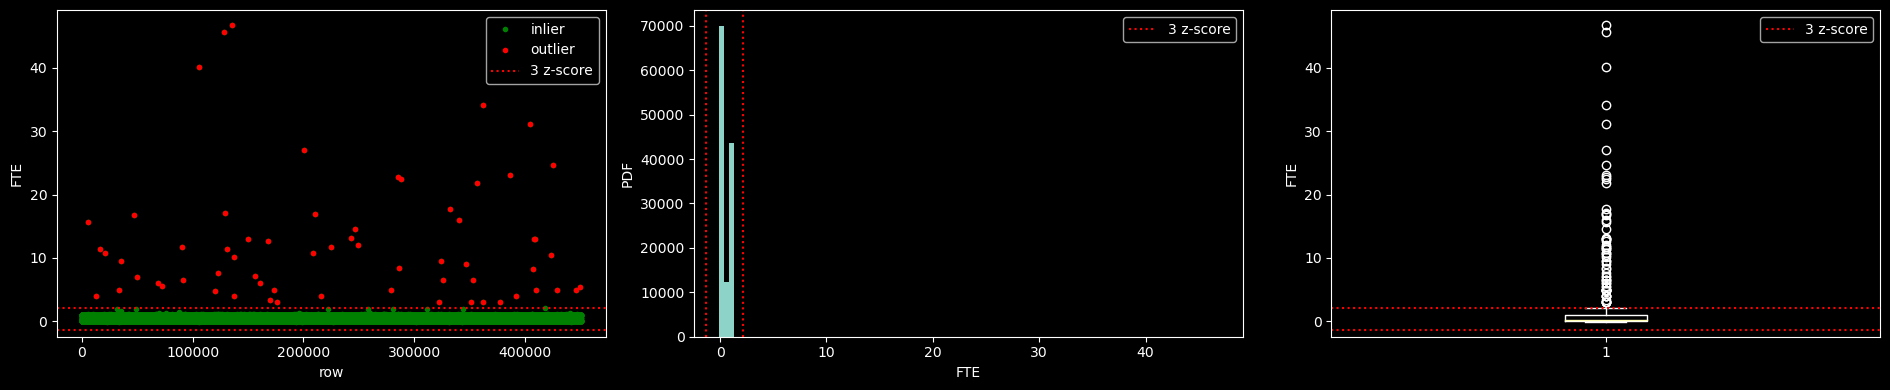

Upper outliers: 64
Lower outliers: 0


In [28]:
density_plots(df.FTE, bins=100)
zscores = zscore(df.FTE, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

`FTE` outliers hold values up to`46.8` and are assumed to be multiple headcount.

In [29]:
relevant = ['FTE', 'Total_FTE', 'Total', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[(zscores < -3) | (zscores > 3), relevant].sort_values('FTE', ascending=False)

,FTE,Total_FTE,Total,Fund_Description,Object_Description,Job_Title_Description
135371,46.799999,528192.000000,NaN,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
128399,45.599998,478476.906250,NaN,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
105857,40.200001,580900.062500,NaN,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
362251,34.200001,484744.875000,NaN,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
404264,31.100000,352252.937500,NaN,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
...,...,...,...,...,...,...
362443,3.000000,280332.906250,NaN,General,Regular *,"TCHR, OCC THERAPIST"
377132,3.000000,149857.500000,NaN,General,Regular *,EDUCATIONAL AIDE I
351528,3.000000,162472.656250,NaN,General,Regular *,MOBILE DEPUTY
176122,3.000000,130486.445312,NaN,General,Regular *,PARA (MF)


What if to remove outliers?

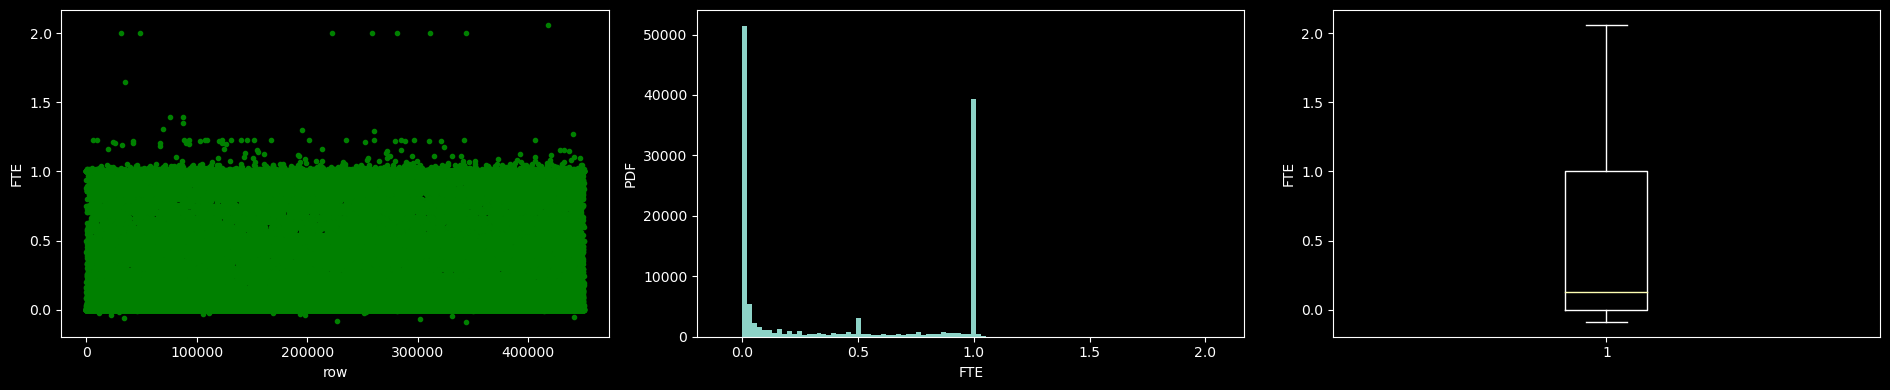

In [30]:
density_plots(df.FTE[(zscores >= -3) & (zscores <= 3)], outlying=False, bins=100)

Binning with and without outliers

In [31]:
pd.cut(df.FTE, bins=4).dtype

CategoricalDtype(categories=[(-0.134, 11.634], (11.634, 23.356], (23.356, 35.078], (35.078, 46.8]], ordered=True)

In [32]:
pd.cut(df.FTE[(zscores >= -3) & (zscores <= 3)], bins=4).dtype

CategoricalDtype(categories=[(-0.0897, 0.449], (0.449, 0.986], (0.986, 1.523], (1.523, 2.06]], ordered=True)

### `Total_FTE` univariate analysis

In [33]:
df.Total_FTE.describe()

count     93474.000000
mean      31717.650391
std       33972.351562
min       -4876.099609
25%        1034.974121
50%       22124.984375
75%       53287.390625
max      845835.687500
Name: Total_FTE, dtype: float64

`Total_FTE` contains upper and lower outliers with magnitude of 800,000.

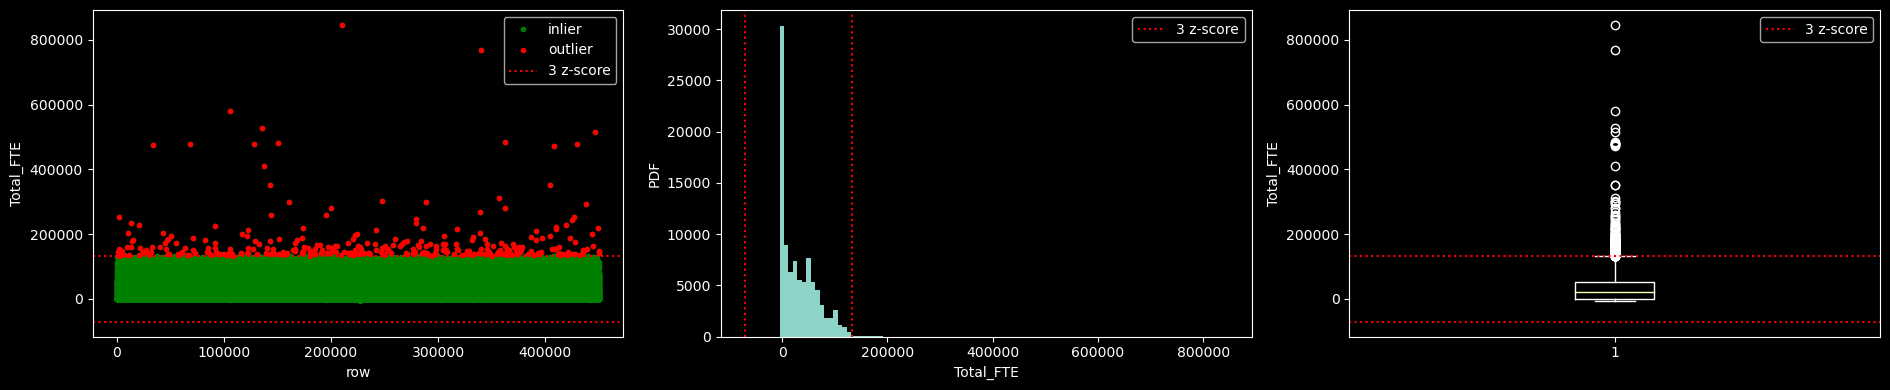

Upper outliers: 312
Lower outliers: 0


In [34]:
density_plots(df.Total_FTE, bins=100)
zscores = zscore(df.Total_FTE, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

In [35]:
df.loc[(zscores < -3) | (zscores > 3), relevant].sort_values('Total_FTE', ascending=False)

,FTE,Total_FTE,Total,Fund_Description,Object_Description,Job_Title_Description
210055,17.000000,845835.687500,NaN,General,Regular *,EDUCATIONAL AIDE I - Preschool Supplemental
340130,16.000000,768873.250000,NaN,General,Regular *,LEAD DRIVER
105857,40.200001,580900.062500,NaN,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
135371,46.799999,528192.000000,NaN,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
446104,5.000000,514157.656250,NaN,Improving Teacher Quality,Regular *,CLASSROOM TEACHERS - TITLE II A
...,...,...,...,...,...,...
294188,1.000000,134038.515625,NaN,General,Regular *,SENIOR HIGH PRINCIPAL
180640,1.000000,134038.171875,NaN,General,Regular *,SENIOR HIGH PRINCIPAL
108020,1.000000,134037.953125,NaN,General,Regular *,SENIOR HIGH PRINCIPAL
2516,1.000000,133867.187500,NaN,General Fund,NaN,Principal-Elementary


What if to remove outliers?

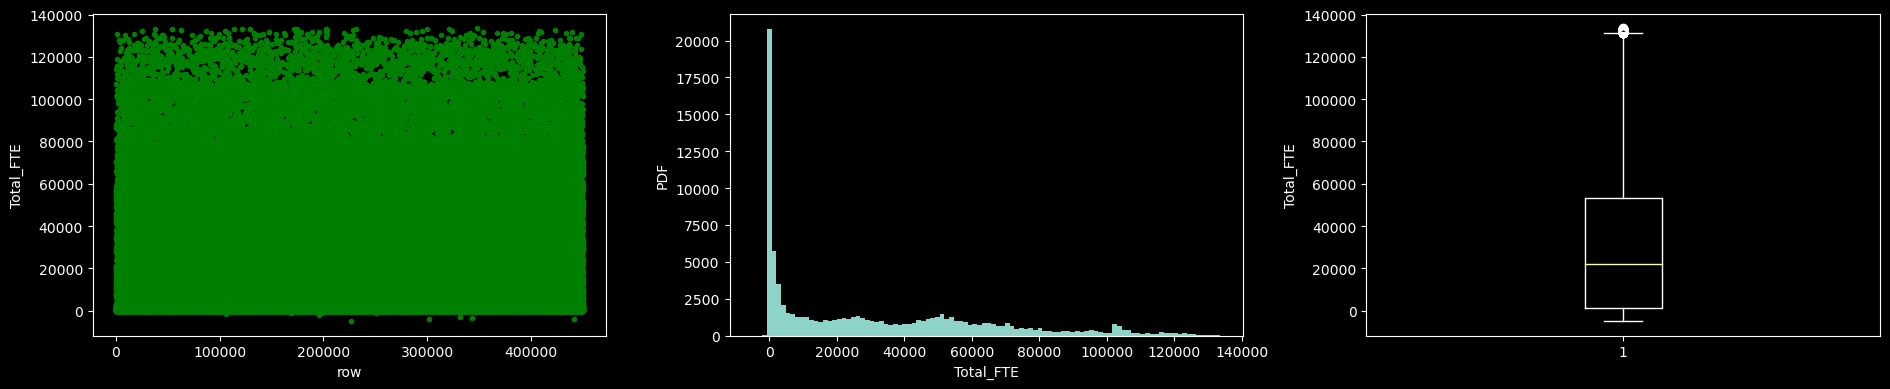

In [36]:
density_plots(df.Total_FTE[(zscores >= -3) & (zscores <= 3)], outlying=False, bins=100)

Binning with and without outliers

In [37]:
pd.cut(df.Total_FTE, bins=3).dtype

CategoricalDtype(categories=[(-5726.811, 278694.496], (278694.496, 562265.092], (562265.092, 845835.688]], ordered=True)

In [38]:
pd.cut(df.Total_FTE[(zscores >= -3) & (zscores <= 3)], bins=3).dtype

CategoricalDtype(categories=[(-5014.438, 41236.595], (41236.595, 87349.29], (87349.29, 133461.984]], ordered=True)

Under the hyphotesis that negative values are sign mistakes, what if to fix them by flipping their signs? **It would move most of the lower outliers to be upper outliers.**

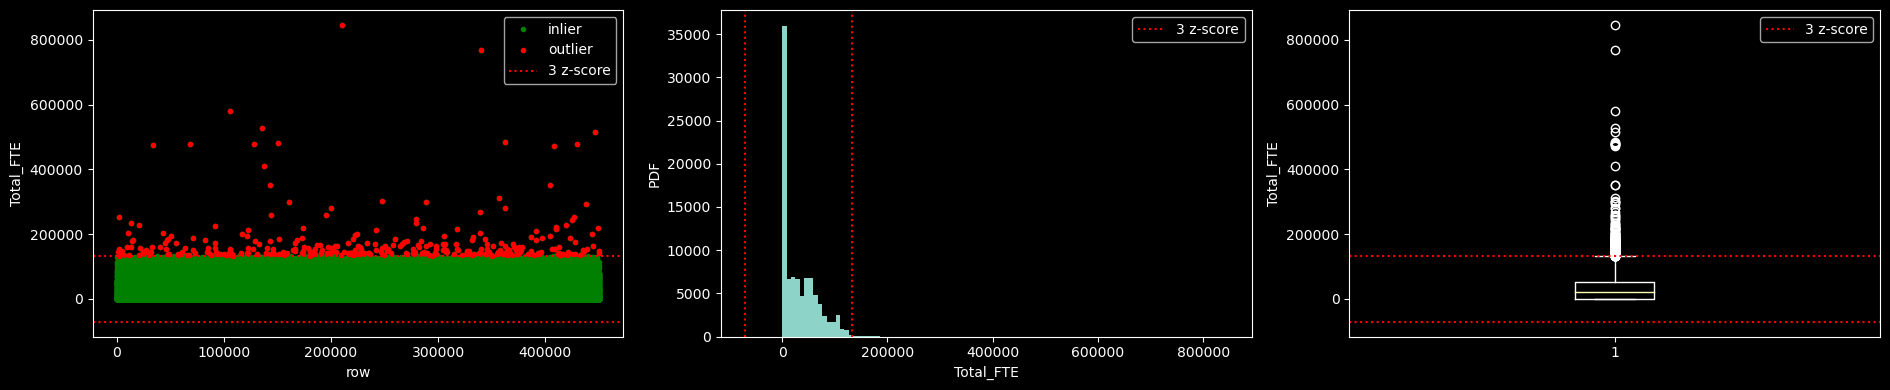

Upper outliers: 312
Lower outliers: 0


In [39]:
density_plots(df.Total_FTE.abs(), bins=100)
zscores_fixed = zscore(df.Total_FTE.abs(), nan_policy='omit')
print('Upper outliers:', sum(zscores_fixed > 3))
print('Lower outliers:', sum(zscores_fixed < -3))

### `Total` univariate analysis

In [40]:
df.Total.describe()

count    3.022480e+05
mean     7.349923e+03
std      4.207443e+05
min     -8.746630e+07
25%      3.633432e+01
50%      2.591200e+02
75%      1.166960e+03
max      1.297000e+08
Name: Total, dtype: float64

`Total` contains upper and lower outliers with magnitude or +/- 100 millions.

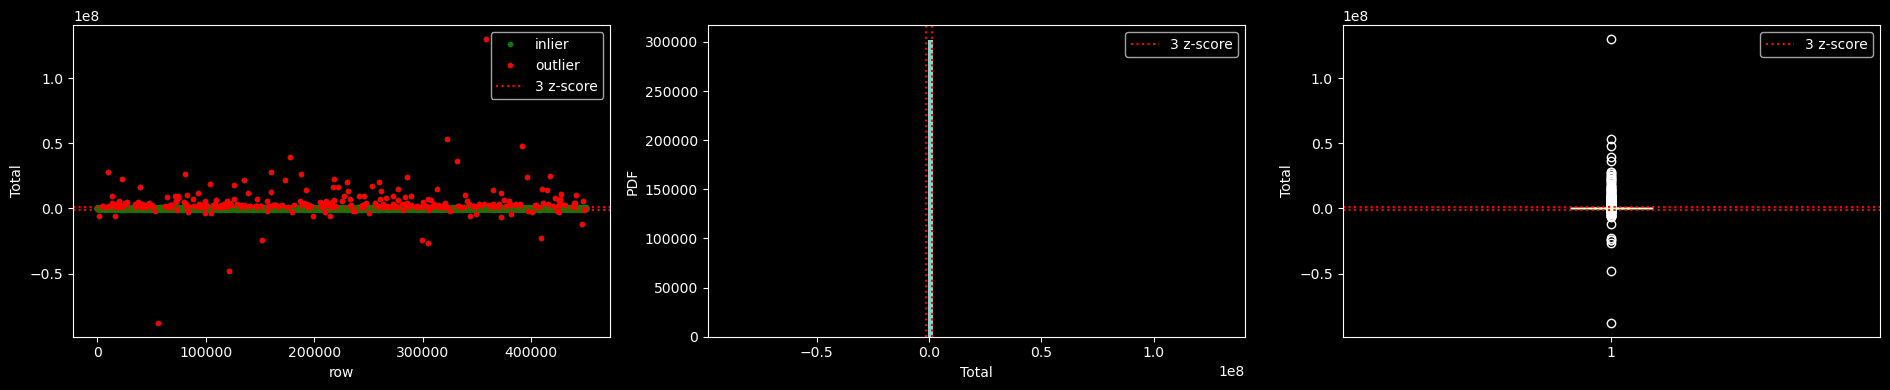

Upper outliers: 280
Lower outliers: 34


In [41]:
density_plots(df.Total, bins=100)
zscores = zscore(df.Total, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

In [42]:
df.loc[(zscores < -3) | (zscores > 3), relevant].sort_values('Total', ascending=False)

,FTE,Total_FTE,Total,Fund_Description,Object_Description,Job_Title_Description
358538,NaN,NaN,129700000.0,General,Payments to a Community School*,NaN
322149,NaN,NaN,53237976.0,Employee Benefits Self-Insurance,Other Purchased Services,NaN
390959,NaN,NaN,47890568.0,NaN,PAYMENTS TO ESCROW AGENTS,(blank)
177775,NaN,NaN,39564460.0,NaN,INTEREST ON LEASES,(blank)
331752,NaN,NaN,36450944.0,NaN,BUILDINGS,(blank)
...,...,...,...,...,...,...
152005,NaN,NaN,-23999664.0,General Fund,OPERATING TRANSFERS TO OTHER FUNDS,NaN
299589,NaN,NaN,-24000000.0,Capital Projects Fund,OPERATING TRANSFERS TO OTHER FUNDS,NaN
304649,NaN,NaN,-26465000.0,NaN,REDEMPTION OF PRINCIPAL,(blank)
121092,NaN,NaN,-47890568.0,NaN,PAYMENTS TO ESCROW AGENTS,(blank)


What if to remove outliers?

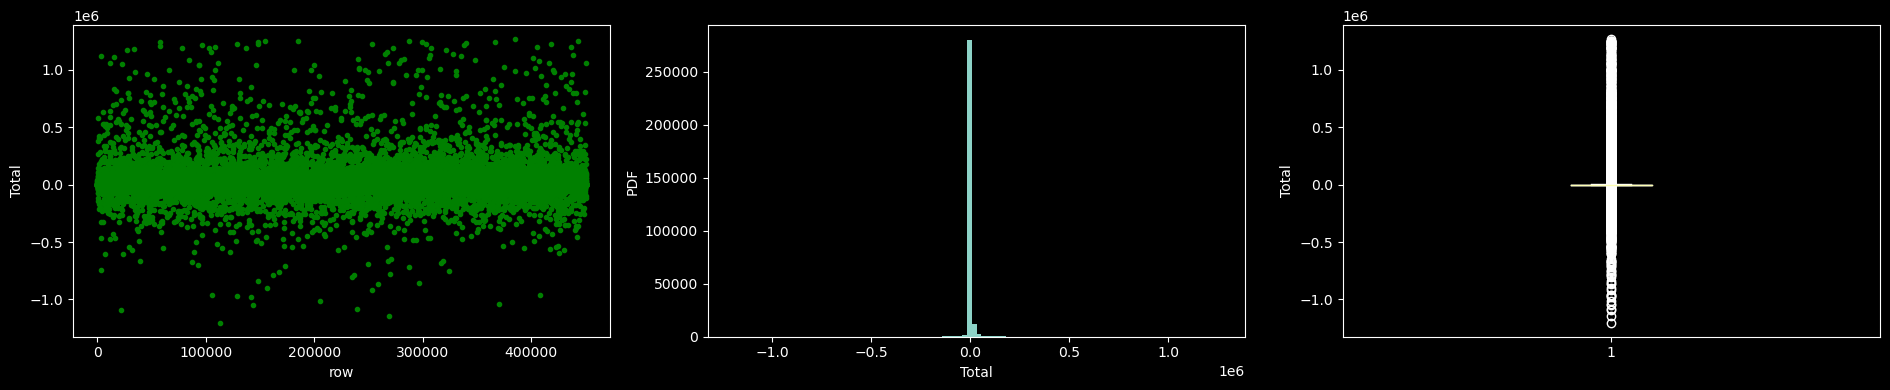

In [43]:
density_plots(df.Total[(zscores >= -3) & (zscores <= 3)], outlying=False, bins=100)

Binning with and without outliers

In [44]:
pd.cut(df.Total, bins=3).dtype

CategoricalDtype(categories=[(-87683470.304, -15077536.0], (-15077536.0, 57311232.0], (57311232.0, 129700000.0]], ordered=True)

In [45]:
pd.cut(df.Total[(zscores >= -3) & (zscores <= 3)], bins=3).dtype

CategoricalDtype(categories=[(-1204431.07, -379189.5], (-379189.5, 443583.75], (443583.75, 1266357.0]], ordered=True)

Under the hyphotesis that negative values are sign mistakes, what if to fix them by flipping their signs? **It would move most of the lower outliers to be upper outliers.**

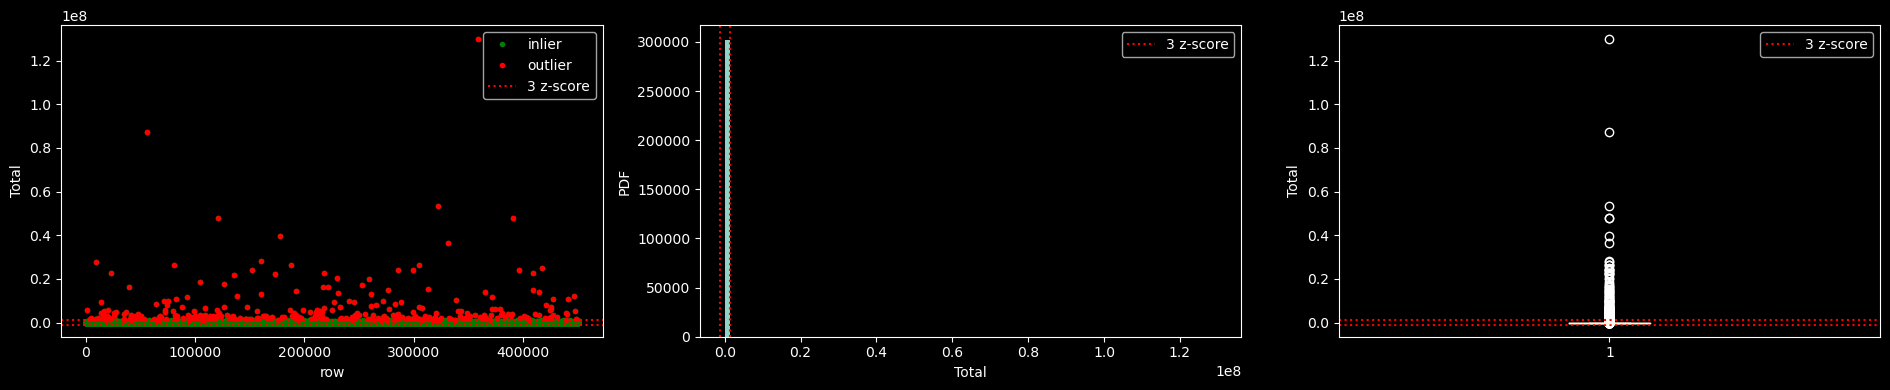

Upper outliers: 314
Lower outliers: 0


In [46]:
density_plots(df.Total.abs(), bins=100)
zscores_fixed = zscore(df.Total.abs(), nan_policy='omit')
print('Upper outliers:', sum(zscores_fixed > 3))
print('Lower outliers:', sum(zscores_fixed < -3))

### Regression and correlation by imputation strategy

In [47]:
def plot_regression_correlation_imputation(df, x, y, figsize=None):
    zero_imputed_df = df[[x, y]].fillna(0)
    mean_imputed_df = df[[x, y]].fillna(df[[x, y]].mean())
    median_imputed_df = df[[x, y]].fillna(df[[x, y]].median())

    plt.figure(figsize=figsize)
    xytext = (0.05, 0.5)
    textcoords='axes fraction'

    plt.subplot(2,2,1)
    sns.regplot(x=x, y=y, data=df[[x,y]])
    plt.annotate('Pearson = {:.12f}'.format(df[[x,y]].corr().iloc[0,1]), xy=xytext, xytext=xytext, textcoords=textcoords)
    plt.title('Raw')

    plt.subplot(2,2,2)
    sns.regplot(x=x, y=y, data=zero_imputed_df)
    plt.title('Zero imputed')
    plt.annotate('Pearson = {:.12f}'.format(zero_imputed_df[[x,y]].corr().iloc[0,1]), xy=xytext, xytext=xytext, textcoords=textcoords)

    plt.subplot(2,2,3)
    sns.regplot(x=x, y=y, data=mean_imputed_df)
    plt.title('Mean imputed')
    plt.annotate('Pearson = {:.12f}'.format(mean_imputed_df[[x,y]].corr().iloc[0,1]), xy=xytext, xytext=xytext, textcoords=textcoords)

    plt.subplot(2,2,4)
    sns.regplot(x=x, y=y, data=median_imputed_df)
    plt.title('Median imputed')
    plt.annotate('Pearson = {:.12f}'.format(median_imputed_df[[x,y]].corr().iloc[0,1]), xy=xytext, xytext=xytext, textcoords=textcoords)

    plt.tight_layout()
    plt.show()

In [48]:
# plot_regression_correlation_imputation(df, 'FTE', 'Total_FTE')

### Correlations grouped by labels by imputation strategy

In [49]:
def plot_grouped_correlation_imputation(df, x, y, by, figsize=(7,7)):
    grouped_corr = df[[by, x, y]]\
        .groupby(by).corr().unstack().iloc[:,2].to_frame('raw')
    
    grouped_corr['zero imputed'] = df[[by, x, y]].fillna({x: 0, y: 0})\
        .groupby(by).corr().unstack().iloc[:,2].rename('zero imputed')
    
    grouped_corr['mean imputed'] = df[[by, x, y]].fillna({x: df[x].mean(), y: df[y].mean()})\
        .groupby(by).corr().unstack().iloc[:,2].rename('mean imputed')
    
    grouped_corr['median imputed'] = df[[by, x, y]].fillna({x: df[x].median(), y:df[y].median()})\
        .groupby(by).corr().unstack().iloc[:,2].rename('median imputed')

    grouped_corr.sort_values('raw', ascending=True, na_position='first').plot(kind='barh', figsize=figsize, xlim=(-1,1))
    
    plt.title(f'{x} and {y} correlations grouped by {by}')
    plt.xlabel('Pearson Correlation')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

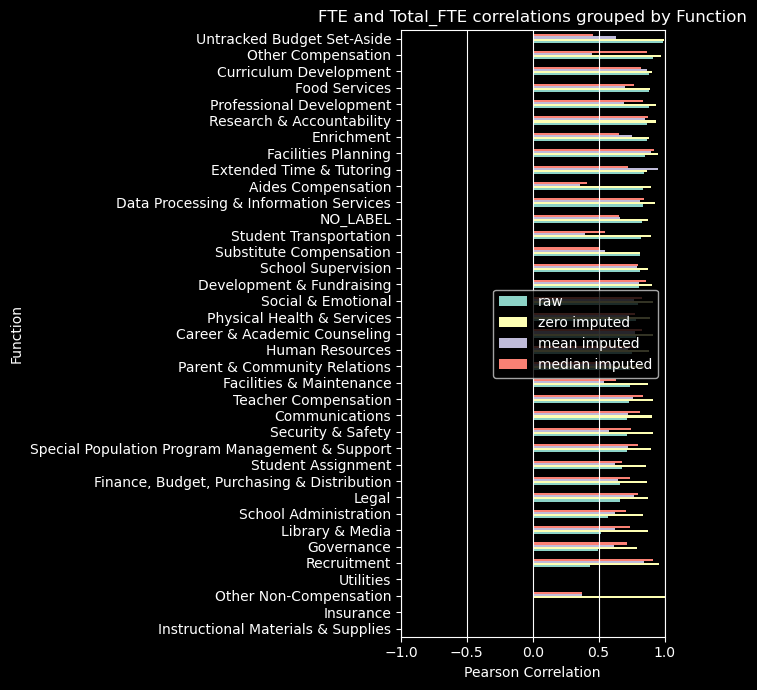

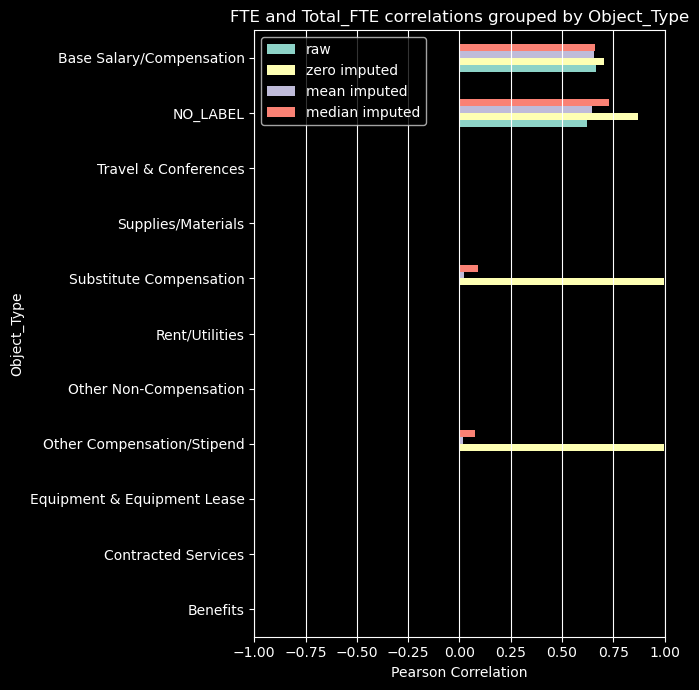

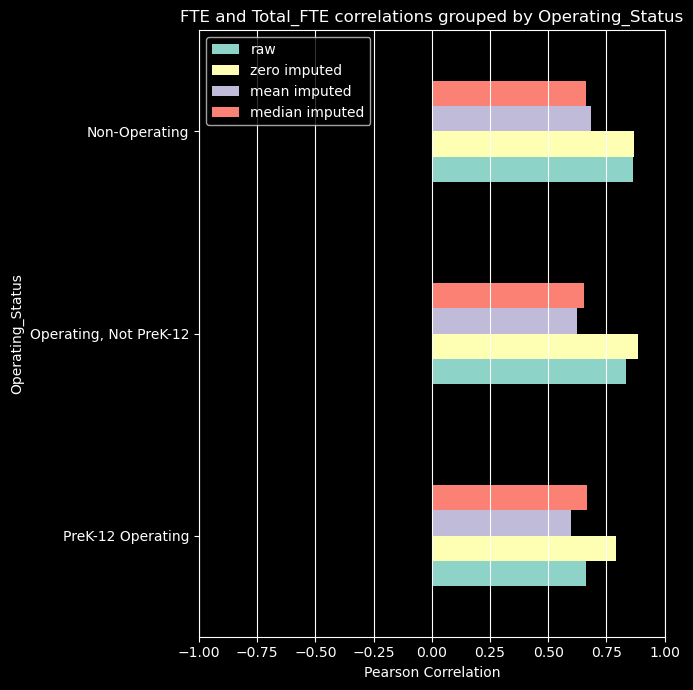

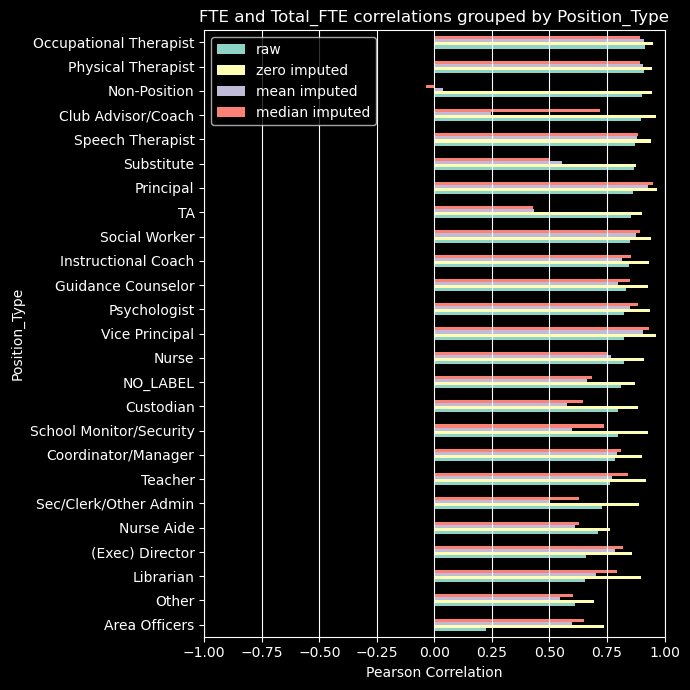

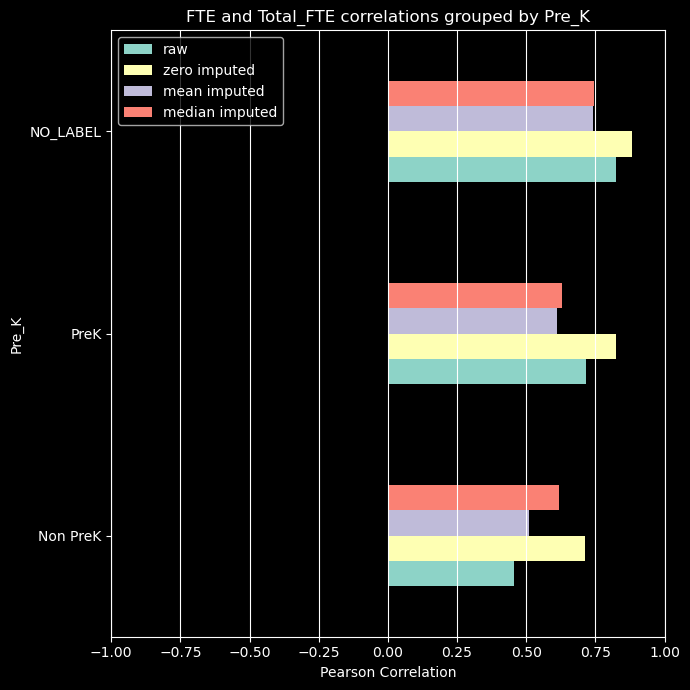

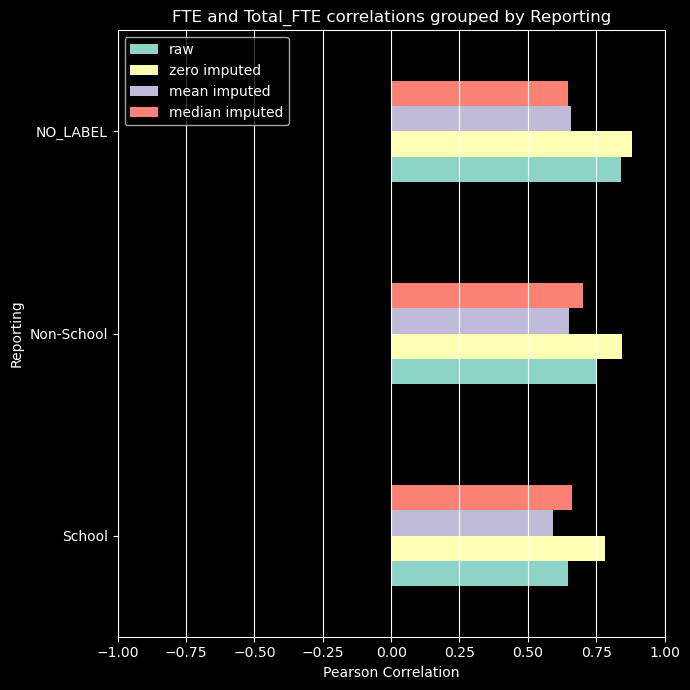

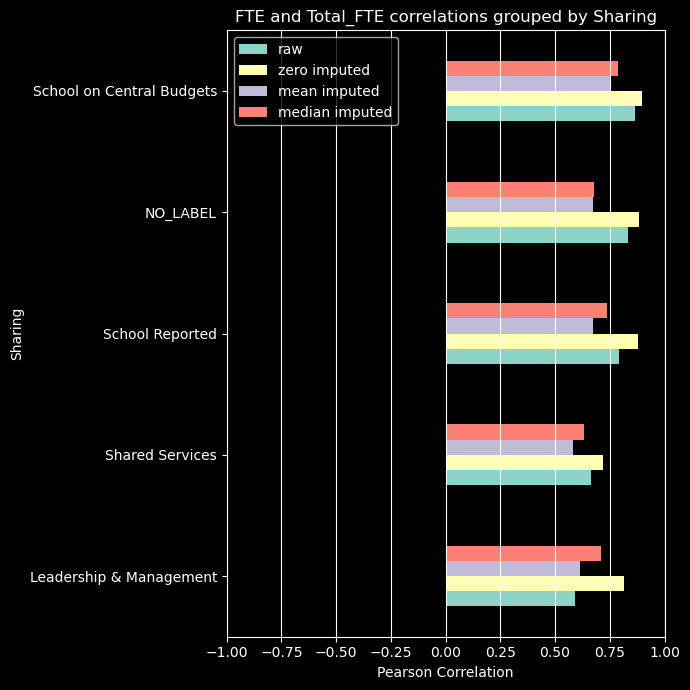

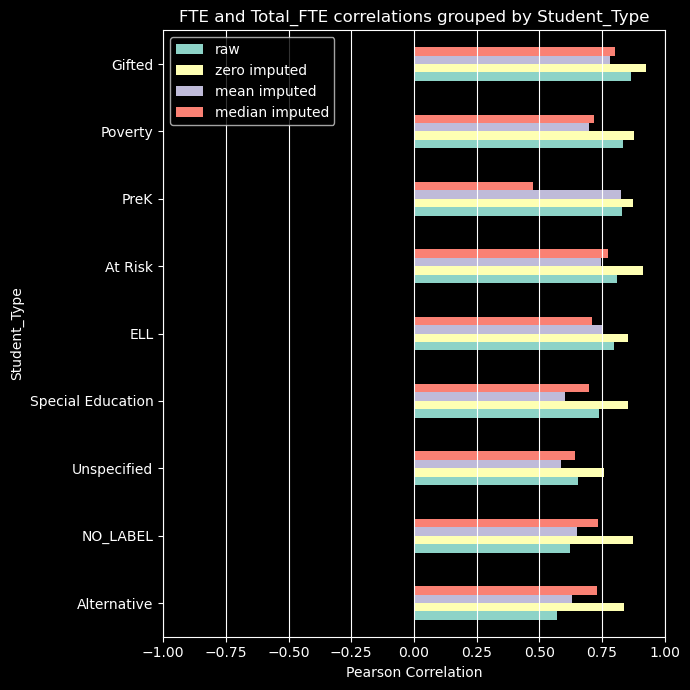

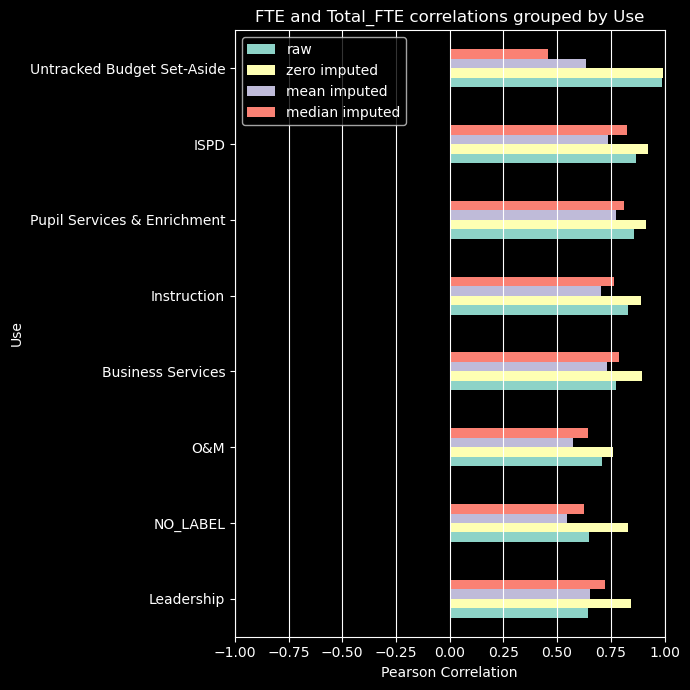

In [50]:
for label in LABELS:
    plot_grouped_correlation_imputation(df=df, x='FTE', y='Total_FTE', by=label)

### Statistics grouped by labels

In [51]:
def plot_grouped_statistics(df, cols, by=None, func=['median', 'mean'], figsize=(14,7)):
    fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=figsize)
    fig.suptitle(f'Grouped by [{by}] subset [{", ".join(cols)}] aggregation [{", ".join(func)}]')

    df.groupby(by)[cols[0]].agg(func).plot(kind='barh', ax=axes[0], legend=False)
    fig.legend(loc='upper left')
    axes[0].set_xlabel(cols[0])

    for i in range(1, len(cols)):
        df.groupby(by)[cols[i]].agg(func).plot(kind='barh', ax=axes[i], legend=False)
        axes[i].set_xlabel(cols[i])
        axes[i].set_ylabel(None)
        axes[i].set_yticks([])
    
    plt.tight_layout()
    plt.show()

In [52]:
# for label in LABELS:
#     plot_grouped_statistics(df, cols=['FTE', 'Total_FTE', 'Total'], by=label)

## Free text form variables

The `cross_value_counts()` function includes missing counts.

In [53]:
def cross_value_counts(df):
    #cvc = df.replace('(\s+|[^\w+])',' ',regex=True)#.apply(lambda x: x.str.strip())
    # cvc = df.replace('[^\w]+',' ',regex=True).apply(lambda x: x.str.strip().str.upper())
    cvc = df.replace('[^\w]+',' ',regex=True).apply(lambda x: x.str.strip().str.lower())
    cvc = cvc.apply(lambda x: x.value_counts(dropna=False)).fillna(0).apply(pd.to_numeric, downcast='unsigned')
    cvc.index.name = 'text'
    cvc.columns.name = 'columns'
    cvc.index = cvc.index.fillna('NaN')
    # sorting value counts by rows than by columns
    decreasing_row_index = cvc.sum(axis=1).sort_values(ascending=False).index
    decreasing_col_index = cvc.loc[cvc.index!='NaN'].sum(axis=0).sort_values(ascending=False).index

    return cvc.loc[decreasing_row_index, decreasing_col_index]

def cross_value_counts_summary(df):
    percent_with_nan = lambda x: x.sum() / (df.shape[0] * df.shape[1]) * 100
    cvc = cross_value_counts(df).replace(0, np.nan)
    cvcs = cvc.agg(['sum', 'count', percent_with_nan], axis='columns')
    cvcs.index.name = 'text'
    cvcs.columns=['Ocurrences', 'Columns', '% w/NaN']

    saved = cvcs.loc['NaN','Ocurrences']
    cvcs.loc['NaN','Ocurrences'] = np.nan
    cvcs['% wo/NaN'] = (cvcs.Ocurrences / cvcs.Ocurrences.sum() * 100)#.fillna(0)
    cvcs['Cumulated % wo/NaN'] = cvcs['% wo/NaN'].cumsum()
    cvcs.loc['NaN','Ocurrences'] = saved
    cvcs['words'] = cvcs.index.str.split().map(len).tolist()
    cvcs.loc['NaN','words'] = np.nan

    cvcs = cvcs.apply(pd.to_numeric, downcast='float')
    cvcs = cvcs.apply(pd.to_numeric, downcast='unsigned')

    return cvcs

### Text counts by feature

In [54]:
cvc = cross_value_counts(df[TEXT_FEATURES].set_axis(df[TEXT_FEATURES].columns.str.replace('_', ' '), axis=1))
cvc.shape

(7604, 14)

In [55]:
cvc.head(50).style.bar()

columns,Object Description,Function Description,SubFund Description,Program Description,Job Title Description,Text 1,Position Extra,Fund Description,Location Description,Text 3,Sub Object Description,Text 2,Facility or Department,Text 4
text,,,,,,,,,,,,,,
NaN,24784,58082,93422,95617,107534,107992,135513,197400,238223,291125,308674,312060,346391,346531
general fund,0,0,123327,0,0,0,0,57212,0,0,0,0,0,0
employee benefits,47495,54,0,32669,0,32669,0,0,83,0,0,54,0,0
regular,9270,0,0,0,0,0,0,0,0,94462,0,0,0,0
professional instructional,0,0,0,0,0,0,92136,0,0,0,0,0,0,0
regular instruction,0,54,3071,0,0,64896,0,0,0,0,0,0,0,10762
non project,0,76890,0,0,0,0,0,0,0,0,0,0,0,0
school,0,0,0,0,0,0,0,0,65524,0,0,0,0,0
undesignated,0,0,0,610,0,610,48273,0,0,0,0,76,0,0


### Text count totals by feature

In [56]:
cvc.iloc[1:].sum().to_frame('Totals').style.bar()

,Totals
columns,
Object Description,375493
Function Description,342195
SubFund Description,306855
Program Description,304660
Job Title Description,292743
Text 1,292285
Position Extra,264764
Fund Description,202877
Location Description,162054


### Text features frequency summary

In [57]:
cvcs = cross_value_counts_summary(df[TEXT_FEATURES])
cvcs.head(18).style.bar()

,Ocurrences,Columns,% w/NaN,% wo/NaN,Cumulated % wo/NaN,words
text,,,,,,
NaN,2663348,14,47.526875,nan,nan,nan
general fund,180539,2,3.221680,6.139676,6.139676,2.000000
employee benefits,113024,6,2.016889,3.843661,9.983336,2.000000
regular,103732,2,1.851075,3.527663,13.511000,1.000000
professional instructional,92136,1,1.644147,3.133313,16.644312,2.000000
regular instruction,78783,4,1.405866,2.679211,19.323523,2.000000
non project,76890,1,1.372086,2.614835,21.938358,2.000000
school,65524,1,1.169262,2.228306,24.166664,1.000000
undesignated,49569,4,0.884548,1.685717,25.852381,1.000000


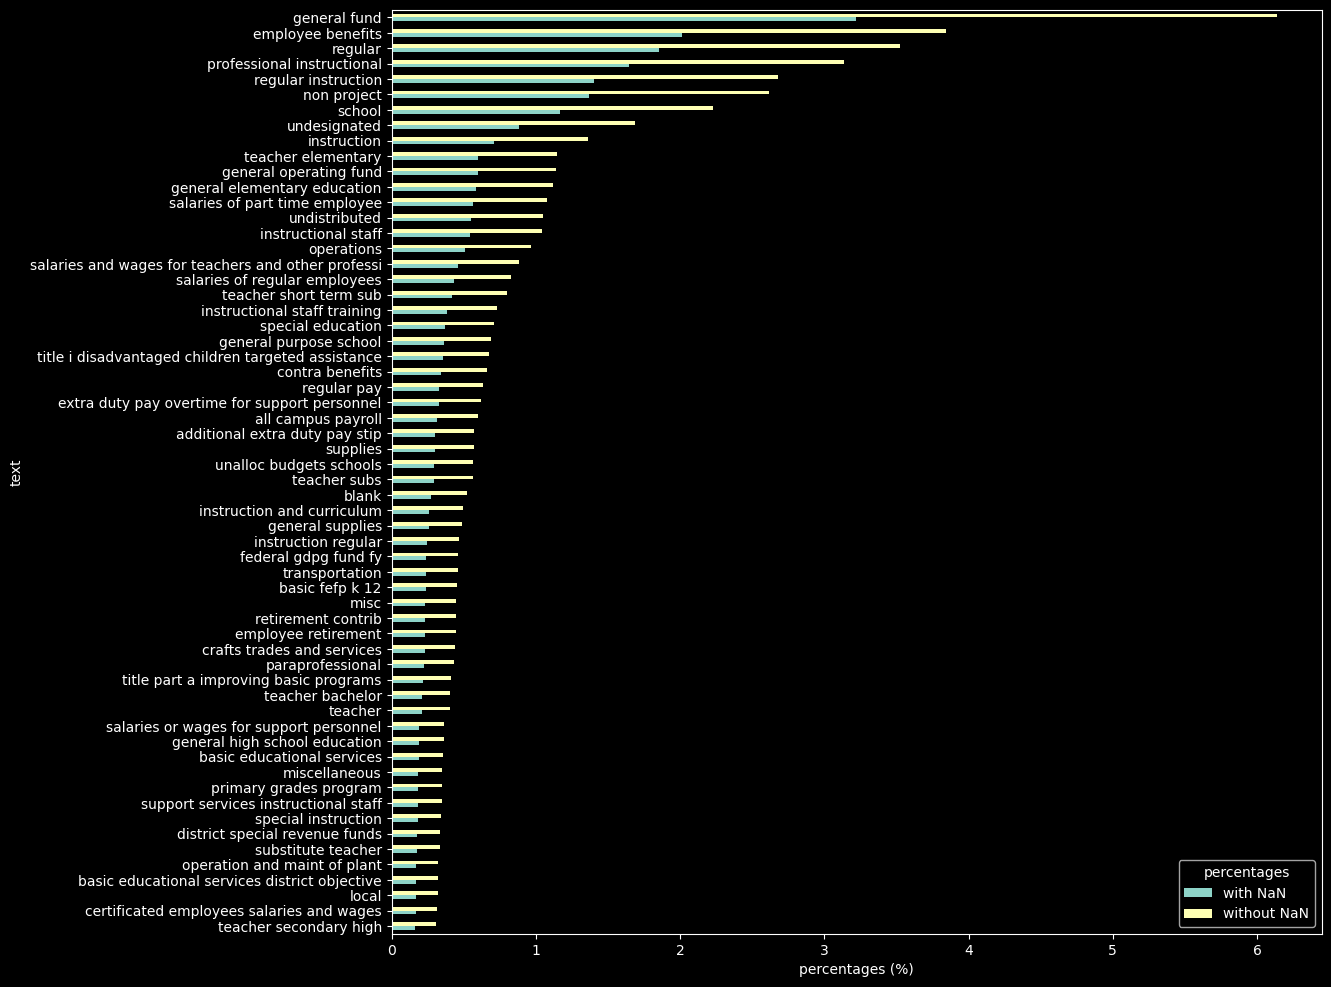

In [58]:
wwo_nan_cvcs = pd.concat({'with NaN': cvcs['% w/NaN'].drop('NaN'),
                          'without NaN': cvcs['% wo/NaN'].drop('NaN')},
                         axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
wwo_nan_cvcs.index.name='text'
wwo_nan_cvcs.columns.name='percentages'
wwo_nan_cvcs.tail(60).plot(kind='barh', stacked=False, figsize=(12, 12))
plt.xlabel('percentages (%)')
plt.show()

## Categorical variables

### Unique classes per label

In [59]:
num_unique_labels = df[LABELS].nunique()
num_unique_labels

Function            37
Object_Type         11
Operating_Status     3
Position_Type       25
Pre_K                3
Reporting            3
Sharing              5
Student_Type         9
Use                  8
dtype: int64

Total number of unique labels

In [60]:
num_unique_labels.sum()

104

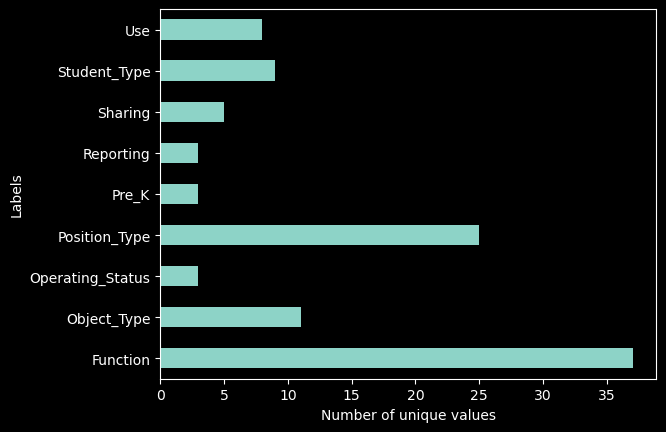

In [61]:
num_unique_labels.plot(kind='barh')
plt.xlabel('Number of unique values')
plt.ylabel('Labels')
plt.show()

### Encoding labels as categories to optimize memory and performance

In [62]:
#Converting label columns to category type
print('Memory before encoding: {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after encoding : {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))

Memory before encoding: 85.9 MB (555.1 MB deep)
Memory after encoding : 61.9 MB (319.5 MB deep)


### Observations per groups of labels

In [63]:
df[LABELS].value_counts().to_frame('value_counts')

value_counts
Function                   Object_Type                Operating_Status  Position_Type         Pre_K    Reporting  Sharing                 Student_Type Use                                      
NO_LABEL                   NO_LABEL                   Non-Operating     NO_LABEL              NO_LABEL NO_LABEL   NO_LABEL                NO_LABEL     NO_LABEL                            48034
Teacher Compensation       Benefits                   PreK-12 Operating Teacher               NO_LABEL School     School Reported         Unspecified  Instruction                         22169
Substitute Compensation    Base Salary/Compensation   PreK-12 Operating Substitute            NO_LABEL School     School Reported         Unspecified  Instruction                         16130
                           Benefits                   PreK-12 Operating Substitute            NO_LABEL School     School Reported         Unspecified  Instruction                         14110
Teacher Compensation       Base Salary/Compensation   PreK-12 Operating Teacher               NO_LABEL School     School Reported         Unspecified  Instruction                         13551
...                                                                                                                                                                                          ...
Physical Health & Services Other Compensation/Stipend PreK-12 Operating Non-Position          Non PreK Non-School Leadership & Management Unspecified  Pupil Services & Enrichment             1
                                                                        Instructional Coach   NO_LABEL Non-School Shared Services         Unspecified  Pupil Services & Enrichment             1
                                                                        Coordinator/Manager   NO_LABEL Non-School Shared Services         Unspecified  Pupil Services & Enrichment             1
                           NO_LABEL                   PreK-12 Operating Sec/Clerk/Other Admin NO_LABEL Non-School NO_LABEL                NO_LABEL     NO_LABEL                                1
Utilities                  Supplies/Materials         PreK-12 Operating Non-Position          NO_LABEL Non-School Shared Services         Unspecified  O&M                                     1

[5489 rows x 1 columns]

### Converting labels in dummy variables

Double underscore conventioned by the competition

In [64]:
# Converting labels in dummy variables
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
dummy_labels

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
206341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
326408,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
364634,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109283,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
102430,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
413949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
433672,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


### Class count

In [65]:
dummy_labels.sum().sort_values(ascending=False)

Operating_Status__PreK-12 Operating    343578
Pre_K__NO_LABEL                        306425
Reporting__School                      257258
Sharing__School Reported               254433
Student_Type__Unspecified              223026
                                        ...  
Function__Legal                           117
Position_Type__Nurse Aide                  95
Function__Development & Fundraising        93
Function__Insurance                        57
Function__Facilities Planning              29
Length: 104, dtype: int64

### Class proportions

In [66]:
dummy_labels.mean().sort_values(ascending=False)

Operating_Status__PreK-12 Operating    0.858351
Pre_K__NO_LABEL                        0.765532
Reporting__School                      0.642700
Sharing__School Reported               0.635642
Student_Type__Unspecified              0.557179
                                         ...   
Function__Legal                        0.000292
Position_Type__Nurse Aide              0.000237
Function__Development & Fundraising    0.000232
Function__Insurance                    0.000142
Function__Facilities Planning          0.000072
Length: 104, dtype: float64

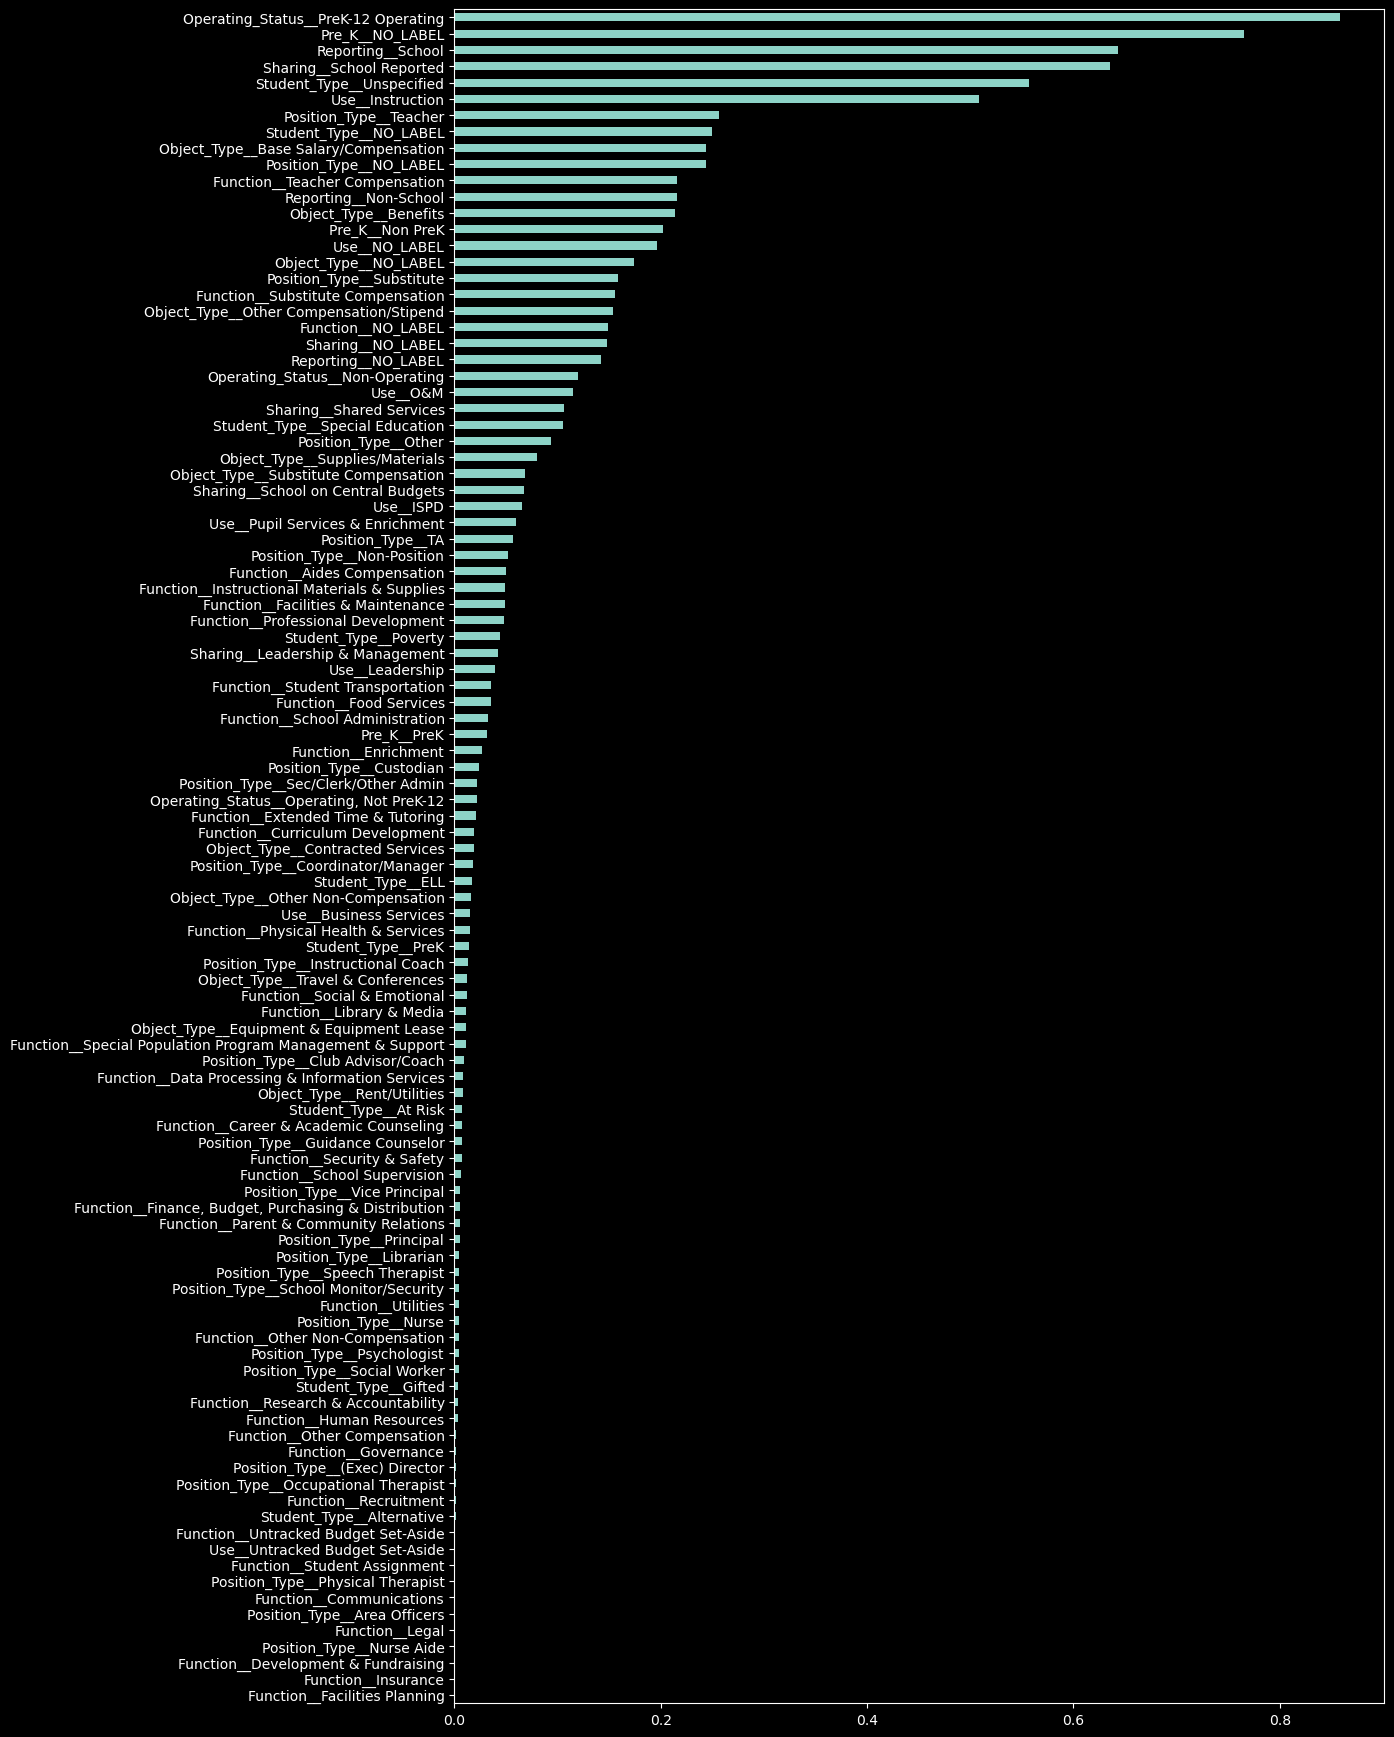

In [67]:
dummy_labels.mean().sort_values().plot(kind='barh', figsize=(12,22)); plt.show()

# Exploring holdout data

This holdout dataset has no labels due to the secrecy of the competition

In [68]:
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)
holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50064 entries, 180042 to 249087
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Object_Description      48330 non-null  object 
 1   Program_Description     44811 non-null  object 
 2   SubFund_Description     16111 non-null  object 
 3   Job_Title_Description   32317 non-null  object 
 4   Facility_or_Department  2839 non-null   object 
 5   Sub_Object_Description  33612 non-null  object 
 6   Location_Description    37316 non-null  object 
 7   FTE                     19605 non-null  float64
 8   Function_Description    46866 non-null  object 
 9   Position_Extra          13813 non-null  object 
 10  Text_4                  2814 non-null   object 
 11  Total                   49404 non-null  float64
 12  Text_2                  4641 non-null   object 
 13  Text_3                  5784 non-null   object 
 14  Fund_Description        39586 no

## Missing data

Overall count and proportion of missing holdout features compared to missing training features:

In [69]:
missing = df[FEATURES].isnull()
missing_holdout = holdout.isnull()
pd.DataFrame({'dataset':  ['training', 'holdout'],
              'missing':    [missing.sum().sum(), missing_holdout.sum().sum()],
              'proportion': [missing.mean().mean(),
                             missing_holdout.mean().mean()]}).set_index('dataset')

,missing,proportion
dataset,,
training,3342386,0.491187
holdout,387797,0.484127


**The proportion of missing data in the holdout set is bigger.**

Comparing missing feature heatmaps.  The columns of both datasets are ordered by the features of the training set with less missing data first. The idea is to compare some sort of missing proportion clusters.

In [70]:
# freq_col_order = missing.sum().sort_values().index.to_list()
# plt.figure(figsize=(25,6))
# sns.heatmap(~missing.loc[: , # missing.sum(axis=1).sort_values().index.to_list(),
#     freq_col_order].sort_values(freq_col_order), cbar=False, xticklabels=False)
# plt.title('Training set')
# plt.figure(figsize=(25,6))
# sns.heatmap(~missing_holdout.loc[:, # missing_holdout.sum(axis=1).sort_values().index.to_list(),
#     freq_col_order].sort_values(freq_col_order), cbar=False)
# plt.title('Holdout set')
# plt.show()

Comparing the heatmaps became suspect that the holdout dataset is not just a fair random sample because it's missing data pattern differs a lot from the training dataset.

Some missing value areas are proportionally bigger in the holdout set, which is confirmed by the missing ratio which differs a lot.

In [71]:
(holdout.isnull().mean() / df[FEATURES].isnull().mean()).sort_values(ascending=False)

SubFund_Description       2.905789
Text_1                    2.568016
Position_Extra            2.138819
Job_Title_Description     1.319515
Text_3                    1.216083
Text_2                    1.163785
Text_4                    1.090171
Facility_or_Department    1.090035
FTE                       0.888124
Object_Description        0.559388
Function_Description      0.440222
Program_Description       0.439246
Location_Description      0.427852
Sub_Object_Description    0.426141
Fund_Description          0.424391
Total                     0.053830
Total_FTE                      NaN
dtype: float64

## Disambiguation of Total when having FTE

In [72]:
holdout[['FTE', 'Total', 'Total_FTE']] = disambiguate(holdout, 'FTE', 'Total')
holdout[NUMERIC_FEATURES]

,FTE,Total,Total_FTE
180042,NaN,3999.909912,NaN
28872,NaN,3447.320312,NaN
186915,1.00,NaN,52738.781250
412396,1.00,NaN,69729.265625
427740,1.00,NaN,29492.833984
...,...,...,...
169063,0.49,NaN,1542.839966
433255,0.50,NaN,9943.969727
232204,1.00,NaN,14674.360352
171685,0.50,NaN,11006.139648


In [73]:
numeric_statistics(holdout)

,count,mean,std,min,25%,50%,75%,max,missing,miss_ratio,sum,range,skewness,kurtosis,iqr,lo_outlier,hi_outlier
FTE,19605,1.349004,8.468634e+01,-1.917398e-07,0.500000,1.000000,1.000000,1.185725e+04,30459,0.608401,2.644722e+04,1.185725e+04,139.979126,19597.732422,0.500000,-0.250000,1.750000
Total,31697,19603.748047,7.870683e+05,-2.370180e+06,96.249283,708.997131,3000.120117,1.117399e+08,18367,0.366870,6.213800e+08,1.141100e+08,110.119133,14010.268555,2903.870834,-4259.556969,7355.926369
Total_FTE,17707,107644.968750,8.668858e+06,-3.614359e-01,26257.117188,45797.152344,55692.675781,1.153578e+09,32357,0.646313,1.906070e+09,1.153578e+09,133.064590,17706.457031,29435.558594,-17896.220703,99846.013672


## `FTE` univariate analysis

In [74]:
holdout.FTE.describe()

count    1.960500e+04
mean     1.349004e+00
std      8.468634e+01
min     -1.917398e-07
25%      5.000000e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.185725e+04
Name: FTE, dtype: float64

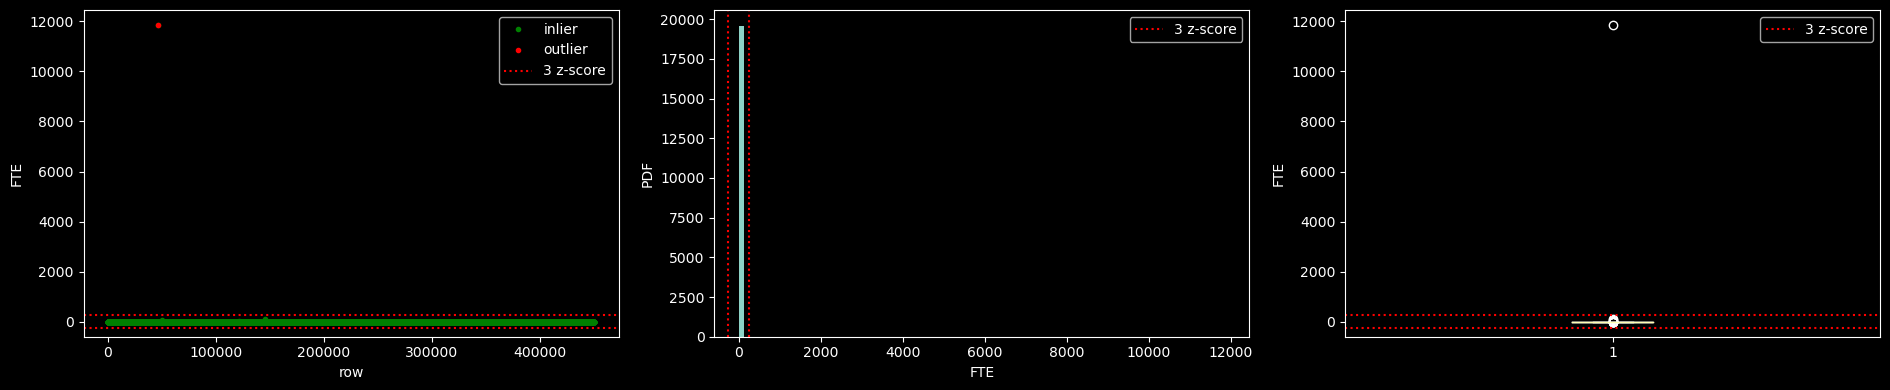

Upper outliers: 1
Lower outliers: 0


In [75]:
density_plots(holdout.FTE, bins=100)
zscores = zscore(holdout.FTE, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has only one `FTE` outlier with a value never seen so high in the whole training set: near `11857.24`, while the max `FTE` in training set is `46.8`.

This specific outlier has no textual data.

In [76]:
holdout[holdout.FTE == holdout.FTE.max()].transpose()

,46063
Object_Description,NaN
Program_Description,NaN
SubFund_Description,NaN
Job_Title_Description,NaN
Facility_or_Department,NaN
Sub_Object_Description,NaN
Location_Description,NaN
FTE,11857.245117
Function_Description,NaN
Position_Extra,NaN


Searching for holdout observations with no textual data: There are 116 other holdout observations without textual data.

In [77]:
holdout.loc[holdout[TEXT_FEATURES].isnull().all(axis=1), NUMERIC_FEATURES].sort_values(['FTE', 'Total'], ascending=False)

,FTE,Total,Total_FTE
46063,11857.245117,NaN,1.153578e+09
45795,NaN,36483.488281,NaN
156857,NaN,29225.599609,NaN
47394,NaN,15943.169922,NaN
312570,NaN,15160.440430,NaN
...,...,...,...
354927,NaN,41.990002,NaN
103425,NaN,18.910000,NaN
71261,NaN,NaN,NaN
230738,NaN,NaN,NaN


Searching for training observations with no textual data: There are 1874 other training observations without textual data.

In [78]:
df.loc[df[TEXT_FEATURES].isnull().all(axis=1), LABELS+NUMERIC_FEATURES].sort_values(['FTE', 'Total'], ascending=False)

,Function,Object_Type,Operating_Status,Position_Type,Pre_K,Reporting,Sharing,Student_Type,Use,FTE,Total,Total_FTE
108731,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Substitute,NO_LABEL,Non-School,NO_LABEL,NO_LABEL,Instruction,NaN,48876.089844,NaN
205873,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Substitute,NO_LABEL,Non-School,NO_LABEL,NO_LABEL,Instruction,NaN,37433.308594,NaN
105293,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Substitute,NO_LABEL,Non-School,NO_LABEL,NO_LABEL,Instruction,NaN,35955.320312,NaN
36835,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Substitute,NO_LABEL,Non-School,NO_LABEL,NO_LABEL,Instruction,NaN,32213.990234,NaN
350915,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Substitute,NO_LABEL,Non-School,NO_LABEL,NO_LABEL,Instruction,NaN,31920.970703,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
314104,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Substitute,NO_LABEL,Non-School,NO_LABEL,NO_LABEL,Instruction,NaN,NaN,NaN
276236,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Substitute,NO_LABEL,Non-School,NO_LABEL,NO_LABEL,Instruction,NaN,NaN,NaN
196727,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Substitute,NO_LABEL,Non-School,NO_LABEL,NO_LABEL,Instruction,NaN,NaN,NaN
266312,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Substitute,NO_LABEL,Non-School,NO_LABEL,NO_LABEL,Instruction,NaN,NaN,NaN


Stats of training observations with no textual, data grouped by labels

In [79]:
df.loc[df[TEXT_FEATURES].isnull().all(axis=1), LABELS+NUMERIC_FEATURES].sort_values(['FTE', 'Total'], ascending=False)\
    .groupby(LABELS, observed=True).agg(['count', 'sum'])#.to_frame('count')

FTE  \
                                                                                                                                             count   
Function                Object_Type             Operating_Status  Position_Type Pre_K    Reporting  Sharing         Student_Type Use                 
Substitute Compensation Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     Instruction     0   
                                                                                         School     School Reported NO_LABEL     Instruction     0   
NO_LABEL                Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     NO_LABEL        0   
                        NO_LABEL                Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL        NO_LABEL     NO_LABEL        0   

                                                                                                                                                   \
                                                                                                                                              sum   
Function                Object_Type             Operating_Status  Position_Type Pre_K    Reporting  Sharing         Student_Type Use                
Substitute Compensation Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     Instruction  0.0   
                                                                                         School     School Reported NO_LABEL     Instruction  0.0   
NO_LABEL                Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     NO_LABEL     0.0   
                        NO_LABEL                Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL        NO_LABEL     NO_LABEL     0.0   

                                                                                                                                             Total  \
                                                                                                                                             count   
Function                Object_Type             Operating_Status  Position_Type Pre_K    Reporting  Sharing         Student_Type Use                 
Substitute Compensation Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     Instruction  1727   
                                                                                         School     School Reported NO_LABEL     Instruction   131   
NO_LABEL                Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     NO_LABEL        1   
                        NO_LABEL                Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL        NO_LABEL     NO_LABEL        0   

                                                                                                                                                            \
                                                                                                                                                       sum   
Function                Object_Type             Operating_Status  Position_Type Pre_K    Reporting  Sharing         Student_Type Use                         
Substitute Compensation Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     Instruction  9.048462e+06   
                                                                                         School     School Reported NO_LABEL     Instruction  3.762721e+05   
NO_LABEL                Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     NO_LABEL     2.107600e+02   
                        NO_LABEL                N

## `Total_FTE` univariate analysis

In [80]:
holdout.Total_FTE.describe()

count    1.770700e+04
mean     1.076450e+05
std      8.668858e+06
min     -3.614359e-01
25%      2.625712e+04
50%      4.579715e+04
75%      5.569268e+04
max      1.153578e+09
Name: Total_FTE, dtype: float64

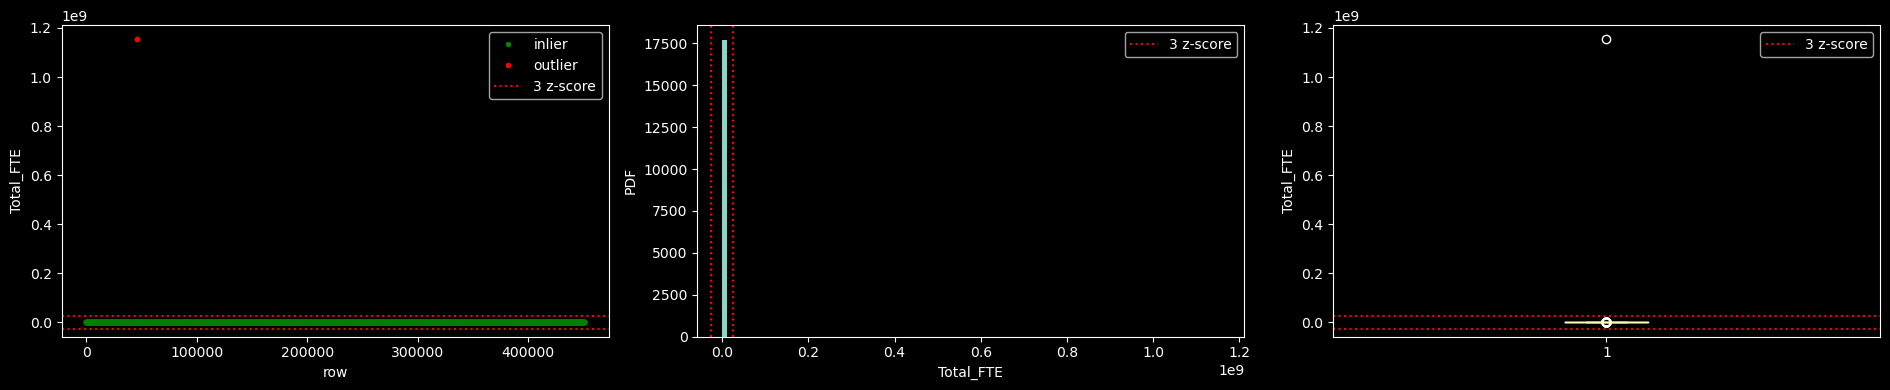

Upper outliers: 1
Lower outliers: 0


In [81]:
density_plots(holdout.Total_FTE, bins=100)
zscores = zscore(holdout.Total_FTE, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has a huge Total outlier close to 1.2 billion while the max in training is 129 million and in fact, this `Total` outlier is the same as the `FTE` outlier.

The highest outlier has not textual data.

In [82]:
holdout[(zscores < -3) | (zscores > 3)].transpose()

,46063
Object_Description,NaN
Program_Description,NaN
SubFund_Description,NaN
Job_Title_Description,NaN
Facility_or_Department,NaN
Sub_Object_Description,NaN
Location_Description,NaN
FTE,11857.245117
Function_Description,NaN
Position_Extra,NaN


## `Total` univariate analysis

In [83]:
holdout.Total.describe()

count    3.169700e+04
mean     1.960375e+04
std      7.870683e+05
min     -2.370180e+06
25%      9.624928e+01
50%      7.089971e+02
75%      3.000120e+03
max      1.117399e+08
Name: Total, dtype: float64

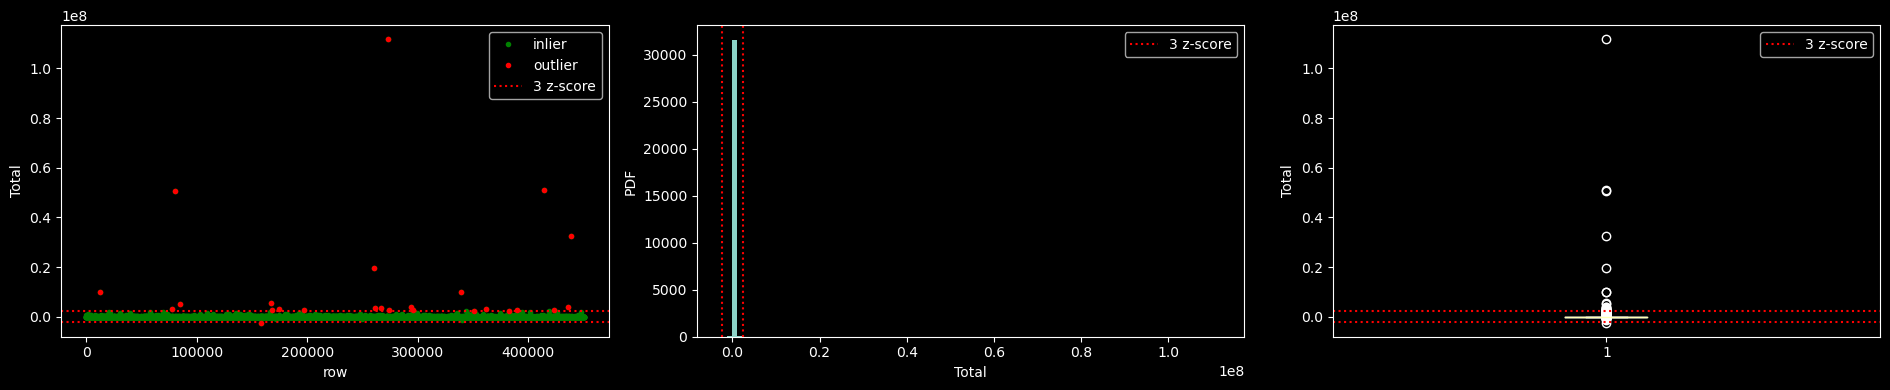

Upper outliers: 24
Lower outliers: 1


In [84]:
density_plots(holdout.Total, bins=100)
zscores = zscore(holdout.Total, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has a huge Total outlier close to 1.2 billion while the max in training is 129 million and in fact, this `Total` outlier is the same as the `FTE` outlier.

The highest outlier has not textual data.

In [85]:
holdout[(zscores < -3) | (zscores > 3)].transpose()

,293744,273904,197099,78059,174306,351109,438567,414647,80621,84673,...,390203,295382,382925,158160,261273,167265,423330,12330,267228,362192
Object_Description,Tax Appraisal & Collection,Professional Salaries,Gasoline & Other Fuels,Federal Revenue,Professional Services,On Behalf Payments,Federal Revenue,Bond Principal,Interest on Bonds,Miscellaneous Contracted Srvcs,...,ENERGY,INTEREST,PAYMENTS TO CHARTER SCHOOLS,OTHER PROFESSIONAL SERVICES,TECHNOLOGY EQUIPMENT,OTHER PURCHASED SERVICES,CONTRACTUAL SERVICES - OTHER,BUILDINGS *,Insurance And Bonding Costs,Interest On Bonds
Program_Description,Undistributed,Basic Educational Services,Undistributed,NaN,Accelerated Education,Undistributed,NaN,Undistributed,Undistributed,Accelerated Education,...,PUPIL TRANSPORTATION,Misc,Misc,DEBT SERVICE,INFORMATION SYSTEMS SERVICES,OTHER GENERAL EDUCATION,SPECIAL EDUCATION LOCAL,NaN,Undistributed,Undistributed
SubFund_Description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,PUPIL TRANSPORTATION,DEBT SERVICE,MISCELLANEOUS,LONG-TERM DEBT GROUP OF ACCOUN,BOND,GENERAL FUND,NaN,Building Acquisitions And Construction Services *,NaN,NaN
Job_Title_Description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,(blank),(blank),(blank),NaN,NaN,NaN,NaN
Facility_or_Department,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Finance Department,Finance Department
Sub_Object_Description,Property Appraisal Srvc,General,General,General,General,General,General,General,General,Supplemental Tutoring,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Buildings *,Insurance And Bonding Costs,Bond Issue
Location_Description,Tax Collections,Unallocated Cost Budget,Transportation Office,NaN,Health Services,Undistributed Organization,NaN,Finance- Debt Payments,Finance- Debt Payments,State/Federal Compliance & Accountability,...,ADMIN. SERVICES,ADMIN. SERVICES,NaN,DISTRICT WIDE ORGANIZATION UNI,NaN,NaN,OSE RESOLUTION,NaN,Undistributed,Undistributed
FTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Function_Description,Other Intergovernmental Charges,Instruction,Student Transportation,Miscellaneous,Health Services,School Leadership,Miscellaneous,Debt Service,Debt Service,Instruction,...,STUDENT TRANSPORT SERVICE,DEBT SERVICES,OTHER SUPPORT SERVICES,NON-PROJECT,TECH GOB,NON-PROJECT,NaN,Building Acquisitions And Construction Services *,Facilities Maintenance And Operations,Debt Service
Position_Extra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,UNDESIGNATED,UNDESIGNATED,UNDESIGNATED,CONTRACTUAL SERVICES - OTHER,NaN,NaN,NaN


## Regression and correlation by imputation strategy

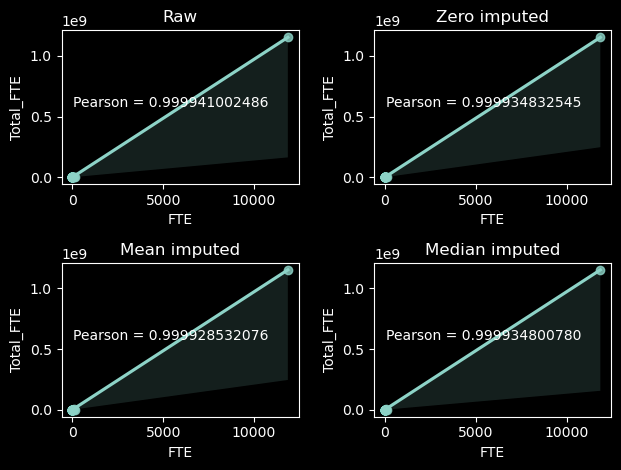

In [86]:
plot_regression_correlation_imputation(holdout, 'FTE', 'Total_FTE')

## Free text form variables

### Text counts by feature

In [87]:
holdout_cvc = cross_value_counts(holdout[TEXT_FEATURES].set_axis(holdout[TEXT_FEATURES].columns.str.replace('_', ' '), axis=1))
holdout_cvc.shape

(5042, 14)

In [88]:
holdout_cvc.head(50).style.bar()

columns,Object Description,Function Description,Program Description,Fund Description,Location Description,Sub Object Description,Job Title Description,SubFund Description,Text 1,Position Extra,Text 3,Text 2,Facility or Department,Text 4
text,,,,,,,,,,,,,,
NaN,1734,3198,5253,10478,12748,16452,17747,33953,34686,36251,44280,45423,47225,47250
general fund,0,0,0,25151,0,0,0,6525,0,0,0,0,0,0
school,0,0,0,0,25531,0,0,0,0,0,0,0,0,0
general,1,0,0,413,0,19704,0,0,0,0,0,0,0,0
instruction,0,15655,0,0,0,0,0,0,0,0,0,0,0,0
undistributed,0,0,10959,0,229,0,0,0,0,0,0,0,0,366
professional salaries,8400,0,0,0,0,0,0,0,0,0,0,0,0,0
basic educational services,0,0,6245,0,0,0,0,0,0,0,0,0,0,0
employee benefits,2520,1,1745,0,3,0,0,0,1745,0,0,1,0,0


### Text count totals by feature

In [89]:
holdout_cvc.iloc[1:].sum().to_frame('Totals').style.bar()

,Totals
columns,
Object Description,48330
Function Description,46866
Program Description,44811
Fund Description,39586
Location Description,37316
Sub Object Description,33612
Job Title Description,32317
SubFund Description,16111
Text 1,15378


### Text features frequency summary

In [90]:
holdout_cvcs = cross_value_counts_summary(holdout[TEXT_FEATURES])
holdout_cvcs.head(18).style.bar()

,Ocurrences,Columns,% w/NaN,% wo/NaN,Cumulated % wo/NaN,words
text,,,,,,
NaN,356678,14,50.888863,nan,nan,nan
general fund,31676,2,4.519358,9.202308,9.202308,2.000000
school,25531,1,3.642623,7.417102,16.619410,1.000000
general,20118,3,2.870326,5.844552,22.463963,1.000000
instruction,15655,1,2.233570,4.547990,27.011951,1.000000
undistributed,11554,3,1.648461,3.356594,30.368546,1.000000
professional salaries,8400,1,1.198466,2.440314,32.808861,2.000000
basic educational services,6245,1,0.891002,1.814257,34.623116,3.000000
employee benefits,6015,6,0.858187,1.747439,36.370556,2.000000


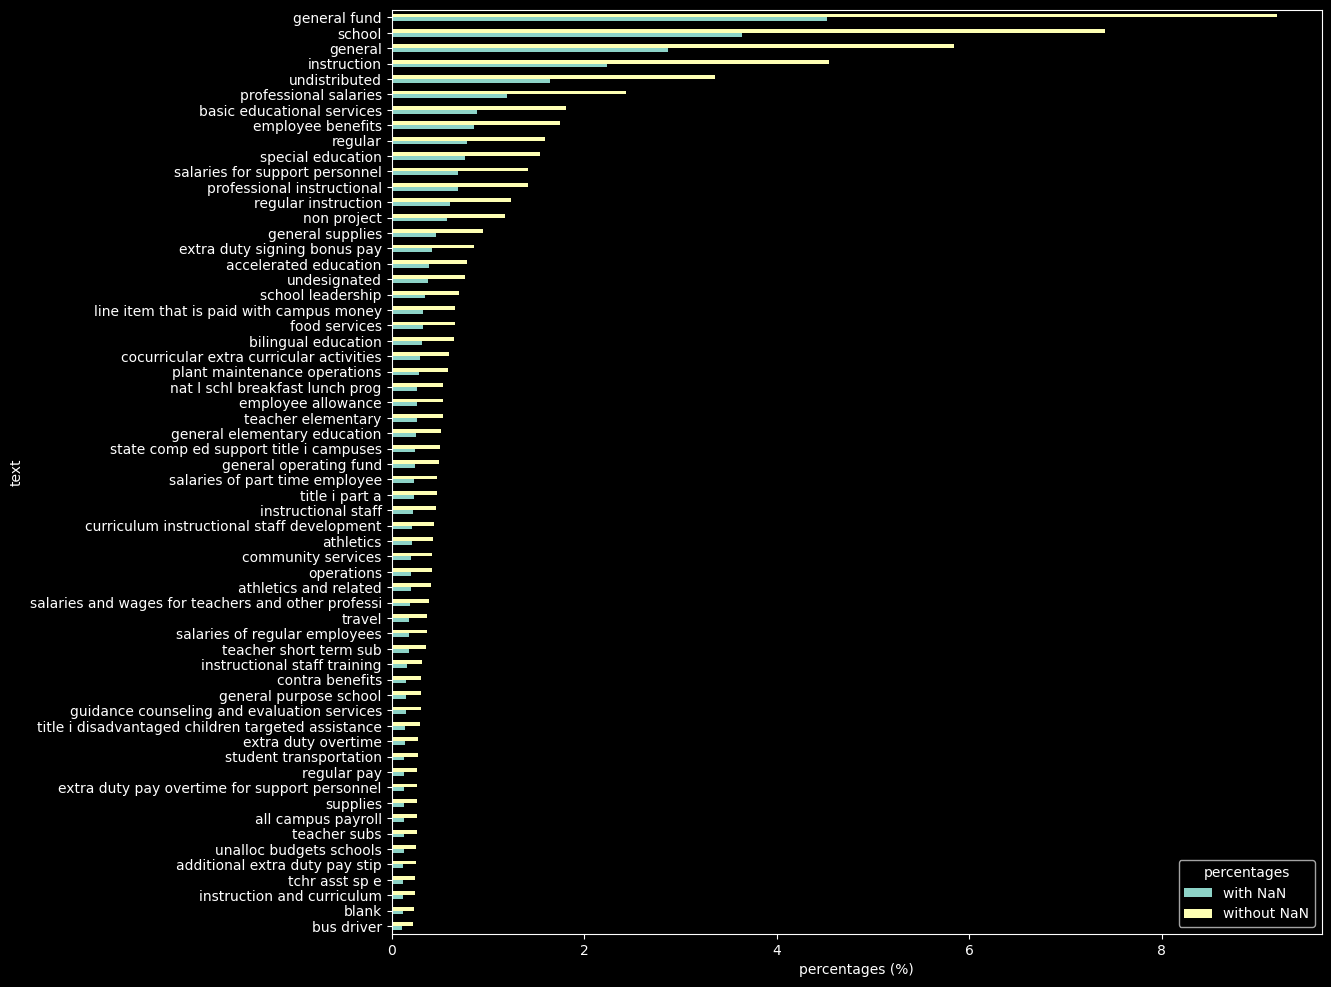

In [91]:
wwo_nan_holdout_cvcs = pd.concat({'with NaN': holdout_cvcs['% w/NaN'].drop('NaN'),
                          'without NaN': holdout_cvcs['% wo/NaN'].drop('NaN')},
                         axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
wwo_nan_holdout_cvcs.index.name='text'
wwo_nan_holdout_cvcs.columns.name='percentages'
wwo_nan_holdout_cvcs.tail(60).plot(kind='barh', stacked=False, figsize=(12, 12))
plt.xlabel('percentages (%)')
plt.show()

### Comparing training-holdout text frequency summaries

percentages,train,holdout
text,,
general fund,6.139676,9.202308
employee benefits,3.843661,1.747439
regular,3.527663,1.592595
professional instructional,3.133313,1.413349
regular instruction,2.679211,1.236135
...,...,...
wan manager,0.000000,0.000291
web manager,0.000000,0.000291
welder,0.000000,0.000291


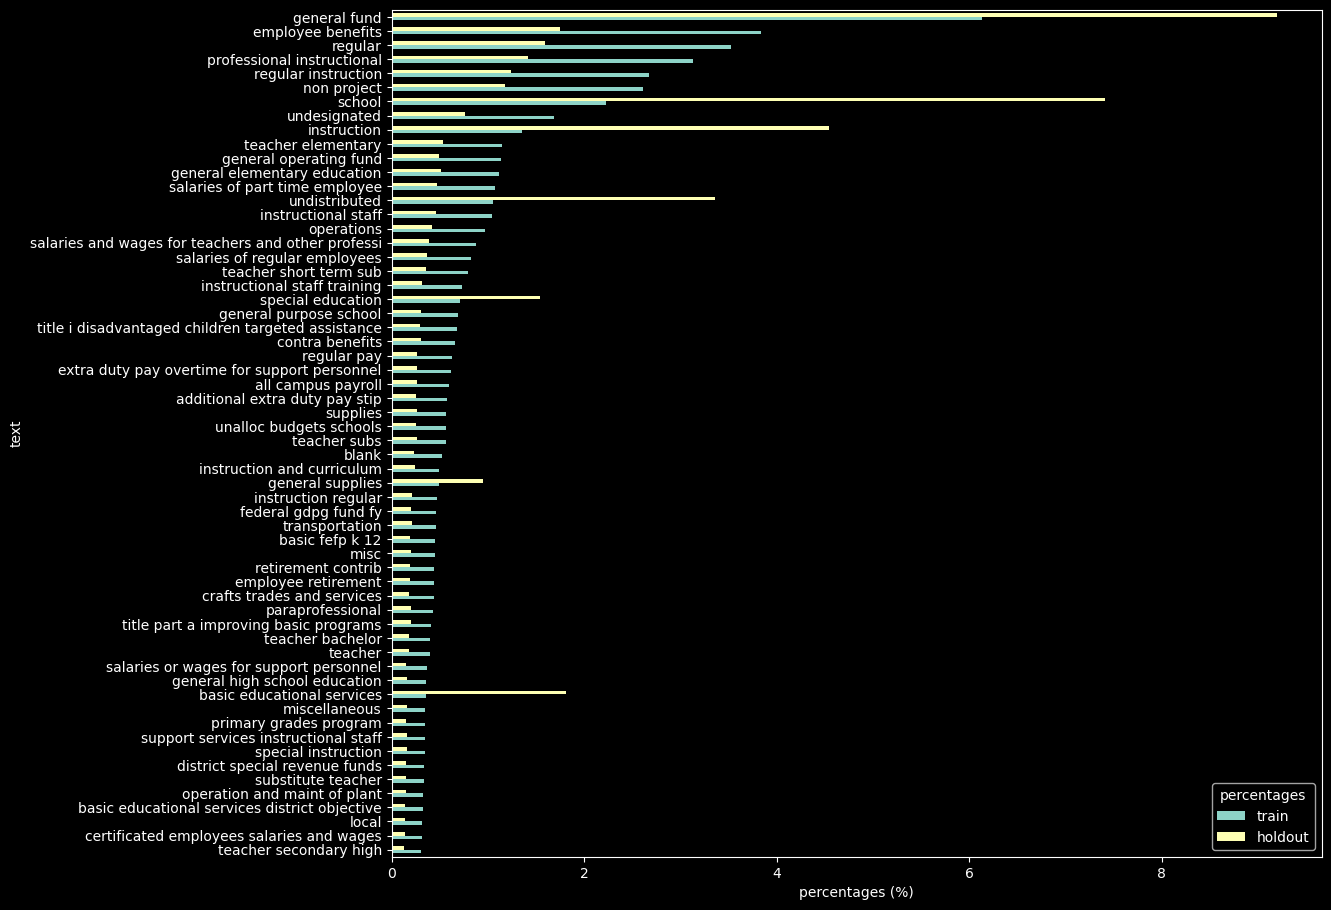

In [92]:
compare_cvcs = pd.concat({'train': cvcs['% wo/NaN'], 'holdout': holdout_cvcs['% wo/NaN']},
                         axis=1, sort=True).fillna(0).sort_values(['train', 'holdout'], ascending=False)
compare_cvcs.index.name='text'
compare_cvcs.columns.name='percentages'
display(compare_cvcs)
compare_cvcs.sort_values(['train', 'holdout']).tail(60).plot(kind='barh', stacked=False, figsize=(12, 11))
plt.xlabel('percentages (%)')
plt.show()

# Imputation strategy

There won't be text feature imputation.

For numeric features:
* Generate binary indicators for missing `FTE`, `Total_FTE` and `Total`
* Impute zero on `FTE`, `Total`, and `Total_FTE`

In [93]:
from sklearn.impute import SimpleImputer
SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)\
    .fit_transform(df[NUMERIC_FEATURES])

array([[1.000000e+00, 0.000000e+00, 5.047181e+04, 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [0.000000e+00, 3.477860e+03, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00],
       [1.000000e+00, 0.000000e+00, 6.223713e+04, 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       ...,
       [1.000000e+00, 0.000000e+00, 4.902290e+03, 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [0.000000e+00, 4.020290e+03, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 4.653000e+01, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]], dtype=float32)

# The log loss

Log loss for binary classification
$$logloss = - \frac{1}{N}\sum^N_{i=1}{(y_i log(p_i) + (1-y_i)log(1-p_i))}$$

>Better to be less confident than confident and wrong

In [94]:
from metrics.log_loss import log_loss

Wrong and confident       : 34.538776394910684
Wrong and not confident   : 0.916290731874155
Correct and not confident : 0.5108256237659907
Correct and confident     : 9.992007221626415e-16


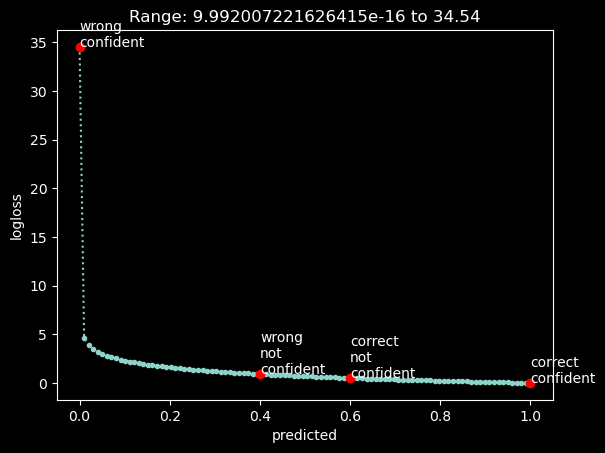

In [95]:
print('Wrong and confident       :', log_loss(actual =1, predicted=0))
print('Wrong and not confident   :', log_loss(actual=1, predicted=0.4))
print('Correct and not confident :', log_loss(actual=1, predicted=0.6))
print('Correct and confident     :', log_loss(actual=1, predicted=1))
predicts = np.linspace(0,1,100)
lloss = [log_loss(1,x) for x in predicts]
plt.plot(predicts, lloss, marker='.', linestyle='dotted')
points = [0, 0.4, 0.6, 1]
classes = ['wrong\nconfident', 'wrong\nnot\nconfident', 'correct\nnot\nconfident', 'correct\nconfident']
for i, x in enumerate(points):
    y=log_loss(actual=1, predicted=x)
    plt.plot(x, y, 'ro')
    plt.text(x, y, s=classes[i])
plt.title('Range: {0:} to {1:.2f}'.format(lloss[-1], lloss[0]))
plt.xlabel('predicted')
plt.ylabel('logloss')
plt.show()

 Log loss penalizes highly confident wrong answers much more than any other type. This is a good metric to use in this model and required by the competition.

# The multi-class multi-label log loss

In [96]:
from metrics.log_loss import multi_multi_log_loss
from dummies import get_dummies_indices
cci = get_dummies_indices(df[LABELS])

# Simple model: only numeric features

In [97]:
from model_selection.multilabel import multilabel_train_test_split

## Setting up a train-test split

* Selecting just numeric features: `df[NUMERIC_FEATURES]`

* Selecting labels as binary variables for multi-label targets: `dummy_labels`

In [98]:
# reproducibility reloads data to avoid things done during EDA
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
NUMERIC_FEATURES=['FTE', 'Total']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES
#

In [99]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NUMERIC_FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)

## Allways pre-process after splitting

In [100]:
X_train = disambiguate(X_train, 'FTE', 'Total')
X_test = disambiguate(X_test, 'FTE', 'Total')

# Logistic regression requires non missing values and also added missing indicators
X_train = SimpleImputer(strategy='constant', fill_value=0, add_indicator=True).fit_transform(X_train)
X_test = SimpleImputer(strategy='constant', fill_value=0, add_indicator=True).fit_transform(X_test)

# Scaling
from sklearn.preprocessing import maxabs_scale
X_train = maxabs_scale(X_train)
X_test = maxabs_scale(X_test)
X_train

array([[2.1929825e-02, 0.0000000e+00, 8.6885527e-02, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.6814650e-05, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [2.1929825e-02, 0.0000000e+00, 1.0713913e-01, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       ...,
       [2.1929825e-02, 0.0000000e+00, 8.4391283e-03, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 3.0996838e-05, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 3.5875095e-07, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00]], dtype=float32)

## Training a model

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [102]:
clf = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)

In [103]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(), n_jobs=-1)

## Model metrics

In [104]:
print("Training Accuracy:", clf.score(X_train, y_train))
y_pred = clf.predict_proba(X_train)
print("Training Logloss:", multi_multi_log_loss(y_train, y_pred, class_column_indices=cci))
print("Testing Accuracy:", clf.score(X_test, y_test))
y_pred = clf.predict_proba(X_test)
print("Testing Logloss:", multi_multi_log_loss(y_test, y_pred, class_column_indices=cci))
y_pred = clf.predict(X_test)
print("Testing Classification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.027221739917931934
Training Logloss: 1.2748620561833368
Testing Accuracy: 0.02218474798575979
Testing Logloss: 1.2808897397155974


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3892
           1       0.00      0.00      0.00       604
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00      1472
           4       0.00      0.00      0.00       678
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00      2152
           7       0.00      0.00      0.00      1652
           8       0.00      0.00      0.00      3969
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00       470
          11       1.00      0.00      0.00      2831
          12       0.00      0.00      0.00       141
          13       0.00      0.00      0.00       240
          14       0.00      0.00      0.00      3845
          15       0.00      0.00      0.00        12
          16       0.00      0.00      0.00      

```
Last executed at 2022-09-14 01:56:26 in 3.01s

Training Accuracy: 0.027221739917931934
Training Logloss: 1.2748620561833368
Testing Accuracy: 0.02218474798575979
Testing Logloss: 1.2808897397155974
```

## Use your model to predict values on holdout data

Pre-process holdout

In [105]:
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)

In [106]:
# Numeric disambiguation
holdout_numeric = disambiguate(holdout, 'FTE', 'Total')
# Logistic regression requires non missing values and also added missing indicators
holdout_numeric = SimpleImputer(strategy='constant', fill_value=0, add_indicator=True).fit_transform(holdout_numeric)
# Scaling
holdout_numeric = maxabs_scale(holdout_numeric)
holdout_numeric

array([[0.0000000e+00, 3.5796627e-05, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 3.0851304e-05, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [8.4336622e-05, 0.0000000e+00, 4.5717559e-05, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       ...,
       [8.4336622e-05, 0.0000000e+00, 1.2720732e-05, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [4.2168311e-05, 0.0000000e+00, 9.5408695e-06, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [4.2168311e-05, 0.0000000e+00, 1.2512675e-05, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [107]:
predictions = clf.predict_proba(holdout_numeric)
predictions

array([[0.03632471, 0.00649866, 0.00087765, ..., 0.11504914, 0.06258739,
        0.00115572],
       [0.03632476, 0.00649866, 0.00087765, ..., 0.11504902, 0.06258752,
        0.00115572],
       [0.13860212, 0.00699581, 0.00054554, ..., 0.13610827, 0.05655503,
        0.00020433],
       ...,
       [0.13866467, 0.00699446, 0.00054551, ..., 0.13615245, 0.05655164,
        0.00020434],
       [0.13853908, 0.00699462, 0.0005455 , ..., 0.13604259, 0.05656619,
        0.00020434],
       [0.13853345, 0.00699475, 0.0005455 , ..., 0.13603861, 0.0565665 ,
        0.00020434]])

## Writing out your results to a zip for submission
At last, you're ready to submit some predictions for scoring. In this exercise, you'll write your predictions to a .csv using the .to_csv() method on a pandas DataFrame. Then you'll evaluate your performance according to the LogLoss metric discussed earlier!

You'll need to make sure your submission obeys the correct format.

To do this, you'll use your predictions values to create a new DataFrame, prediction_df.

Interpreting LogLoss & Beating the Benchmark:

When interpreting your log loss score, keep in mind that the score will change based on the number of samples tested. To get a sense of how this very basic model performs, compare your score to the DrivenData benchmark model performance: 2.0455, which merely submitted uniform probabilities for each class.

Remember, the lower the log loss the better. Is your model's log loss lower than 2.0455?

In [108]:
prediction_df = pd.DataFrame(columns=dummy_labels.columns,
                             index=holdout.index,
                             data=predictions)
prediction_df.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.036325,0.006499,0.000878,0.024395,0.008791,0.000186,0.032003,0.024285,0.052381,0.000097,...,0.087015,0.519512,0.016225,0.073580,0.441252,0.038965,0.250339,0.115049,0.062587,0.001156
28872,0.036325,0.006499,0.000878,0.024395,0.008791,0.000186,0.032003,0.024285,0.052382,0.000097,...,0.087015,0.519514,0.016225,0.073580,0.441255,0.038965,0.250336,0.115049,0.062588,0.001156
186915,0.138602,0.006996,0.000546,0.012380,0.006125,0.000412,0.023921,0.033061,0.049067,0.000061,...,0.120572,0.688287,0.012081,0.042037,0.673542,0.029871,0.071377,0.136108,0.056555,0.000204
412396,0.138574,0.006996,0.000546,0.012379,0.006125,0.000412,0.023917,0.033053,0.049065,0.000061,...,0.120574,0.688278,0.012082,0.042038,0.673547,0.029874,0.071377,0.136089,0.056557,0.000204
427740,0.138640,0.006995,0.000546,0.012381,0.006124,0.000412,0.023927,0.033072,0.049069,0.000061,...,0.120570,0.688299,0.012080,0.042035,0.673535,0.029867,0.071376,0.136135,0.056553,0.000204


In [109]:
prediction_df.to_csv('/data/drivendata/predictions/2022/0.8-scaled-engineered-numeric-features-logistic-regression-C1.csv')

Last executed at 2022-09-09 10:47:29 in 3.11s:

Engineered 6 numeric features, zero imputed, with maxabs scaler: 1.2951

# Improving your model: NLP

## Combining text features for tokenization

Here all text features are concatenated in each row.

Each row becomes a single document.

**But which order concatenate the text features?**

The order of the text feature concatenation makes difference in resulting n-grams where n > 1 (bigrams, etc.).

When using sentence tokenization rather than word tokenization, the text feature concatenation should use "." rather than " ".

Concatenating using some semantics from: https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/page/86/#features_list

In [110]:
TEXT_FEATURES = ['Object_Description', 'Sub_Object_Description', 'Function_Description', 'Fund_Description',
                 'SubFund_Description', 'Program_Description', 'Location_Description', 'Facility_or_Department',
                 'Job_Title_Description', 'Position_Extra', 'Text_1', 'Text_2', 'Text_3', 'Text_4']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES

In [111]:
from preprocessing.combine_text_columns import combine_text_columns

In [112]:
text_vector = combine_text_columns(df[TEXT_FEATURES], to_drop=LABELS, sep=' ')
text_vector

134338                                                                                                                                                                                                                                                                                         General Fund KINDERGARTEN Teacher-Elementary  KINDERGARTEN 
206341                                                                                                                                                                                               CONTRACTOR SERVICES RGN  GOB BUILDING FUND BUILDING IMPROVEMENT SERVICES (blank) UNDESIGNATED BUILDING IMPROVEMENT SERVICES BOND EXPENDITURES Regular
326408                                                                                                                                                                                                                               Personal Services - Teachers General Purpose School Instruction - Regular TCH

In [113]:
print(f'Memory size {size(sys.getsizeof(text_vector))}')

Memory size 86.5 MiB


## Bag-of-Words

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from nlp import custom_word_tokenizer, custom_sentence_tokenizer

Unigram statistics:

<400277x3758 sparse matrix of type '<class 'numpy.uint8'>'
	with 6441095 stored elements in Compressed Sparse Row format>

,00a,12,1st,2nd,3rd,4,4th,5,56,5th,...,yrbs,yrs,yth,z,zero,zeta,zone,zoo,zuni,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sparsity                           : 0.995718043089115
Max term frequency in a document   : 6
Max term frequency in all documents: 331001
Max words in a document            : 53
Mean words per document            : 19.8
Median words per document          : 19.0
Sparse matrix memory usage         : 32.2 MiB
Dense matrix memory equivalence    : 1.4 GiB
Non-zero probabilities:

,bin,count,proportion
0,1,5222873,0.810867
1,2,996854,0.154765
2,3,176893,0.027463
3,4,35572,0.005523
4,5,7678,0.001192
5,6,1225,0.000190


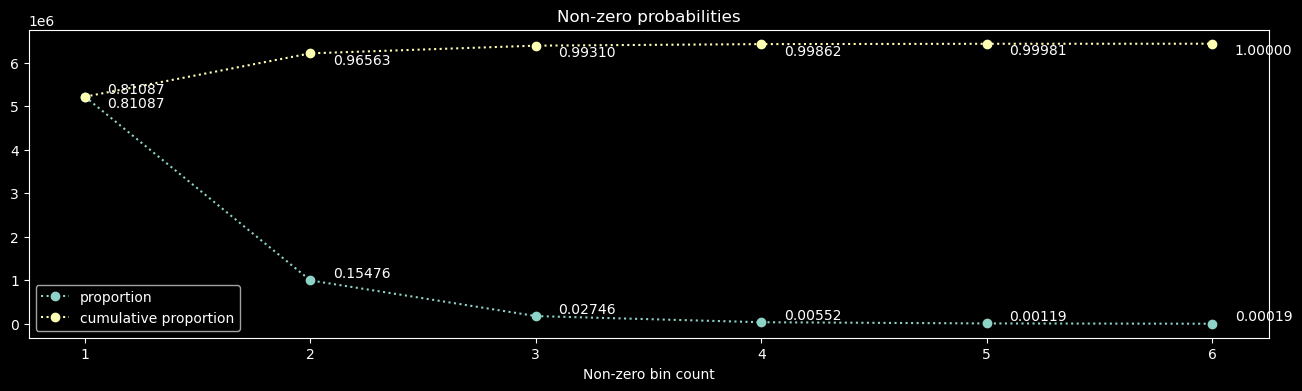

In [119]:
vec = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', dtype='uint8').fit(text_vector)
tdm = vec.transform(text_vector)
display(tdm)
display(pd.DataFrame(tdm.toarray(), columns=vec.get_feature_names_out()))

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max term frequency in a document   : {}'.format(tdm.max()))
print('Max term frequency in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max words in a document            : {}'.format(tdm.sum(axis=1).max()))
print('Mean words per document            : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median words per document          : {}'.format(np.median(np.array(tdm.sum(axis=1)))))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, tdm.max() + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

* **`81%` of the words appear only `1`  time in the rows.**
* **`99%` of the words appear from `1` to `3` times in the rows.**
* **`19%` of the words appear `2` or more times, in fact up to `6` times in the rows.**

Observations with 6 duplicate words:

In [155]:
df.loc[((tdm==6).sum(axis=1)==1), TEXT_FEATURES]\
    .set_axis([x.replace('_',' ') for x in TEXT_FEATURES], axis=1)

,Object Description,Sub Object Description,Function Description,Fund Description,SubFund Description,Program Description,Location Description,Facility or Department,Job Title Description,Position Extra,Text 1,Text 2,Text 3,Text 4
93057,SALARIES OF PART TIME EMPLOYEE,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker I,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
302258,SALARIES FOR OVERTIME,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker I,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
2057,SALARIES FOR OVERTIME,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,"Manager, Food Service II","CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
327398,SALARIES OF PART TIME EMPLOYEE,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker I,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
321957,SALARIES OF REGULAR EMPLOYEES,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,"Manager, Food Service III","CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17586,SALARIES OF PART TIME EMPLOYEE,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker I,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
270184,SALARIES FOR OVERTIME,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,"Manager, Food Service","CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
366708,SALARIES OF PART TIME EMPLOYEE,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker II,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
150124,SALARIES FOR OVERTIME,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,"Manager, Food Service II","CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN


Vocabulary

In [136]:
vec.vocabulary_

{'general': 1478,
 'fund': 1438,
 'kindergarten': 1974,
 'teacher': 3405,
 'elementary': 1155,
 'contractor': 790,
 'services': 3093,
 'rgn': 2951,
 'gob': 1504,
 'building': 468,
 'improvement': 1688,
 'blank': 408,
 'undesignated': 3576,
 'bond': 426,
 'expenditures': 1283,
 'regular': 2857,
 'personal': 2567,
 'teachers': 3406,
 'purpose': 2783,
 'school': 3037,
 'instruction': 1767,
 'tcher': 3397,
 '2nd': 3,
 'grade': 1513,
 'employee': 1169,
 'benefits': 382,
 'unalloc': 3572,
 'budgets': 466,
 'schools': 3040,
 'middle': 2234,
 'junior': 1949,
 'high': 1601,
 'sch': 3024,
 'short': 3129,
 'term': 3438,
 'sub': 3287,
 'professional': 2716,
 'instructional': 1768,
 'subs': 3294,
 'coverage': 856,
 'for': 1395,
 'non': 2351,
 'project': 2735,
 'education': 1127,
 'secondary': 3065,
 'alternative': 180,
 'contra': 786,
 'custodian': 905,
 'pt': 2764,
 'jobs': 1936,
 'educational': 1128,
 'local': 2086,
 'special': 3192,
 'supplies': 3334,
 'and': 198,
 'materials': 2179,
 'district'

Single char vocabulary

In [132]:
({k:v for k, v in vec.vocabulary_.items() if len(k)==1})

{'s': 3000,
 'p': 2483,
 'e': 1105,
 'i': 1655,
 'k': 1953,
 '9': 26,
 'b': 336,
 'd': 911,
 'a': 28,
 '8': 21,
 '6': 10,
 'l': 1983,
 'g': 1454,
 'w': 3661,
 'c': 484,
 'o': 2383,
 't': 3374,
 'v': 3609,
 'z': 3751,
 'x': 3733,
 'm': 2117,
 'h': 1553,
 'f': 1301,
 'u': 3570,
 'j': 1927,
 'n': 2306,
 'r': 2796,
 '7': 14,
 '5': 7,
 '4': 5}

## Vocabulary size as function of ngram_range

Vocabulary size for each ngram_range

In [118]:
# Pre-fetch unigram max unique tokens in a document
# max_unigrams = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', dtype='uint8', binary=True).fit_transform(text_vector).sum(axis=1).max().astype(int)
max_unigrams = 39
print(f'Max unique unigram tokens: {max_unigrams}')

Max unique unigram tokens: 39


In [129]:
from nlp2 import ngram_vocabulary_size
# Pre-fetch vocabulary sizes
# vocabulary_sizes = Parallel(n_jobs=-1)(delayed(ngram_vocabulary_size)(text_vector, ngram_range=(1, ngram) for ngram in range(1, max_unigrams+1)) # 3min15s
vocabulary_sizes = [3758, 32011, 86424, 165642, 267225, 390038, 531563, 689377, 860680, 1042527, 1231386, 1422522, 1612185, 1796647, 1972122, 2135623,
                    2284785, 2418729, 2536972, 2639838, 2728430, 2804263, 2869149, 2924946, 2973322, 3015715, 3053344, 3086975, 3117272, 3144635,
                    3169278, 3191394, 3211161, 3228702, 3244177, 3257666, 3269245, 3279027, 3287190]

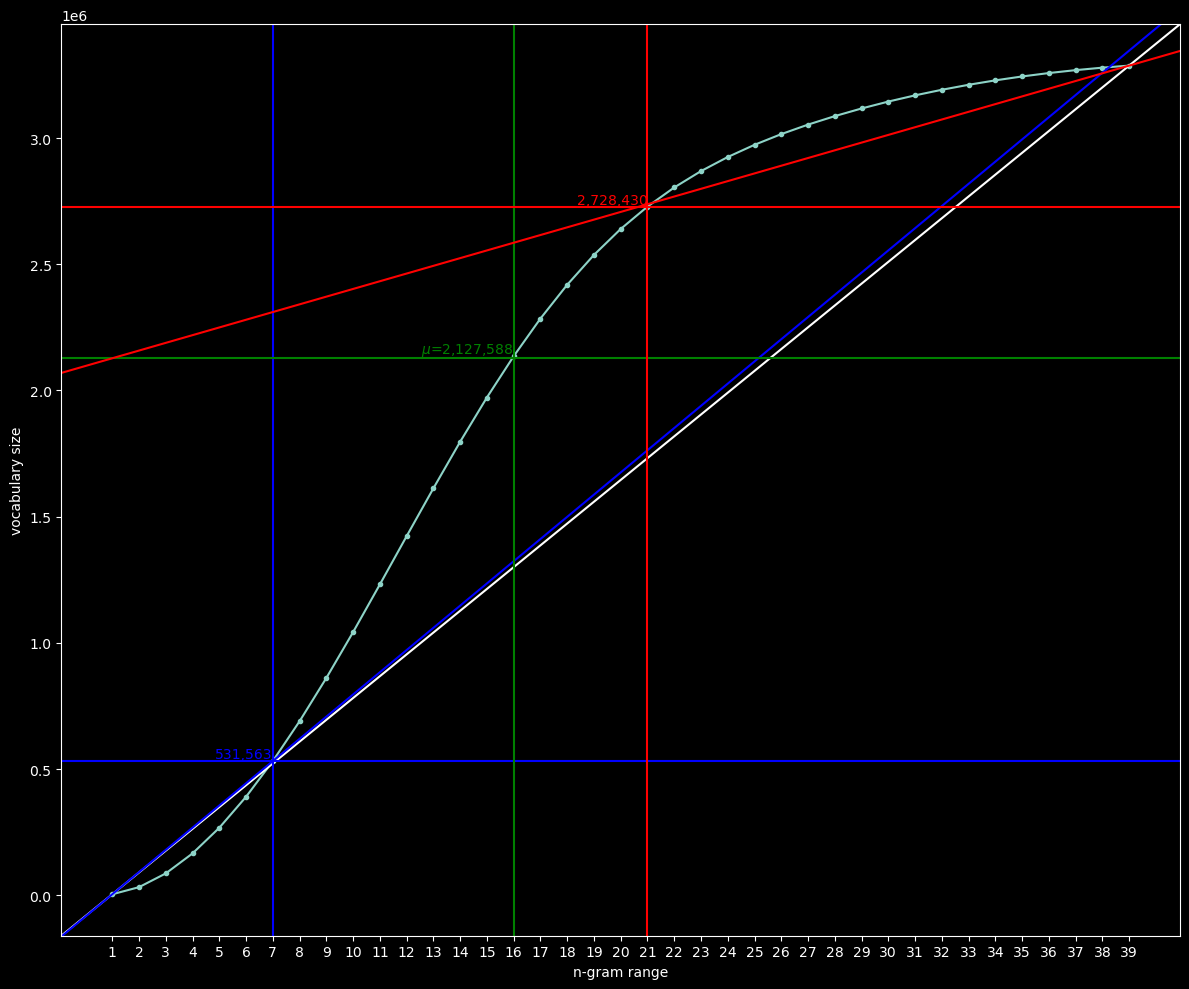

In [117]:
mu = np.mean(vocabulary_sizes)
x=range(1, max_unigrams+1)

plt.figure(figsize=(12,10))
plt.plot(x, vocabulary_sizes, '.-')
plt.xlabel('n-gram range'); plt.ylabel('vocabulary size')
plt.xticks(range(1, max_unigrams+1))
# plt.yticks(vocabulary_sizes)
# for i,j in zip(range(1, len(vocabulary_sizes)), vocabulary_sizes):
#     plt.text(i,j,f'{j:,.0f}', horizontalalignment='right', verticalalignment='bottom', size=8)
#     plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')

# plot to endpoints
plt.axline(xy1=(1,vocabulary_sizes[0]), xy2=(len(vocabulary_sizes), vocabulary_sizes[-1]))
# plot first break
plt.axline(xy1=(1,vocabulary_sizes[0]), xy2=(7, vocabulary_sizes[6]), color='b')
plt.axvline(7, color='b')
plt.axhline(vocabulary_sizes[6], color='b')
plt.text(x=7, y=vocabulary_sizes[6], s=f'{vocabulary_sizes[6]:,.0f}', horizontalalignment='right', verticalalignment='bottom', color='b')
# plot mean
plt.axhline(np.mean(vocabulary_sizes), color='g')
plt.text(x=16, y=mu, s=f'$\mu$={mu:,.0f}', horizontalalignment='right', verticalalignment='bottom', color='g')
plt.axvline(16, color='g')
# plot from mean to max
plt.axline(xy1=(1,mu), xy2=(len(vocabulary_sizes), vocabulary_sizes[-1]), color='r')
plt.axvline(21, color='r')
plt.axhline(vocabulary_sizes[20], color='r')
plt.text(x=21, y=vocabulary_sizes[20], s=f'{vocabulary_sizes[20]:,.0f}', horizontalalignment='right', verticalalignment='bottom', color='r')
plt.tight_layout()
plt.show()

The `ngram_range` afffects the number of non zeros (nnz) thus, the memory usage.
It'll be assumed the limit of 7 which is more than hundred times bigger than unigram's:

In [118]:
vocabulary_sizes[6] / vocabulary_sizes [0]

141.44837679616816

## Tokenizing n-gram ranges

The `CountVectorizer` default `dtype` is `int64`.

As the maximum frequency of any token in a single observation is 6, the 8-bits unsigned integer `uint8` (0 to 255) could be enough to store counts of any ngram range.

In [119]:
# def func(ngram_range, text_vector):
#     tracemalloc.start()
#     tracemalloc.reset_peak()
#     t=time()
#     tdm = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range = ngram_range, dtype='uint8').fit_transform(text_vector)
#     t=time()-t
#     current, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#     msg = 'ngram:{},{} cols:{} maxtf:{} maxtfall:{} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
#     msg = msg.format(ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(), tdm.sum(axis=0).max(), tdm.nnz,
#                      (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes), size(current), size(peak), t)
#     return msg

# messages = Parallel(n_jobs=-1)(delayed(func)(ngram_range, text_vector) for ngram_range in [(1,x) for x in range(1, 8)])

# for message in messages:
#     print(message)

```
Last executed at 2022-09-16 20:27:12 in 47.20s

ngram:1,1 cols:3758 maxtf:6 maxtfall:331001 nnz:6441095 sparse:99.57% size:32.2 MiB cur:32.4 MiB peak:119.4 MiB 7s
ngram:1,2 cols:32011 maxtf:6 maxtfall:331001 nnz:13478633 sparse:99.89% size:65.8 MiB cur:66.0 MiB peak:238.6 MiB 14s
ngram:1,3 cols:86424 maxtf:6 maxtfall:331001 nnz:20372670 sparse:99.94% size:98.7 MiB cur:98.8 MiB peak:357.4 MiB 20s
ngram:1,4 cols:165642 maxtf:6 maxtfall:331001 nnz:26957695 sparse:99.96% size:130.1 MiB cur:130.2 MiB peak:474.2 MiB 27s
ngram:1,5 cols:267225 maxtf:6 maxtfall:331001 nnz:33195723 sparse:99.97% size:159.8 MiB cur:160.0 MiB peak:600.5 MiB 33s
ngram:1,6 cols:390038 maxtf:6 maxtfall:331001 nnz:39080590 sparse:99.97% size:187.9 MiB cur:188.0 MiB peak:731.1 MiB 39s
ngram:1,7 cols:531563 maxtf:6 maxtfall:331001 nnz:44603334 sparse:99.98% size:214.2 MiB cur:214.4 MiB peak:850.7 MiB 44s
```

## n-gram range frequency plot

In [120]:
# stop_words = CountVectorizer(stop_words='english').get_stop_words()
# def func(ngram_range, text_vector):
#     vec = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range=ngram_range, dtype='uint8')
#     tdm = vec.fit_transform(text_vector)
#     return ngram_range, pd.DataFrame({'term': vec.get_feature_names_out(), 'proportion': tdm.mean(axis=0).tolist()[0],
#                                       'frequency': tdm.sum(axis=0).tolist()[0],
#                                       # whether the term contains a stop word
#                                       'stop_word': [True if any([True if word in stop_words else False for word in str.split(words)])
#                                                     else False
#                                                     for words in vec.get_feature_names_out()]}).sort_values(['frequency','term'],
#                                                                                                             ascending=(False, True)).head(100)


# for ngram_range, plot_df in Parallel(n_jobs=-1)(delayed(func)(ngram_range, text_vector) for ngram_range in [(1,x) for x in range(1, 8)]):
#     plt.figure(figsize=(15,12))
#     plt.grid()
#     ax = sns.barplot(x='frequency', y='term', data=plot_df, hue='stop_word', dodge=False)
#     patches = ax.patches
#     for i in range(len(patches)):
#         y = patches[i].get_y() + patches[i].get_height()
#         x = patches[i].get_x() + patches[i].get_width()
#         ax.annotate('{:.2f}%'.format(plot_df['proportion'].iloc[i%plot_df.shape[0]]*100), (x, y))#, ha='center')
#     plt.title('n-gram range {} frequency'.format(ngram_range))
#     plt.tight_layout()
#     plt.show()    

## Hashing Trick

* Adding new features (e.g. 3-grams, 4-grams) may cause enormous increase in array size
* Hashing is a way of increasing memory efficiency
* Want to make array of features as small as possible: dimensionality Reduction
* Hash functions limits possible outputs, fixing array size
* Particularly useful on large datasets: e.g. lots of text data!

In [121]:
from sklearn.feature_extraction.text import HashingVectorizer

The parameters `norm=None`, `alternate_sign=False` and `binary=False` let us drop in the `HashingVectorizer()` as a replacement for `CounterVectorizer()`

[From sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-hashing):
> Since the hash function might cause collisions between (unrelated) features, a signed hash function is used and the sign of the hash value determines the sign of the value stored in the output matrix for a feature. This way, collisions are likely to cancel out rather than accumulate error, and the expected mean of any output feature’s value is zero. This mechanism is enabled by default with `alternate_sign=True` and is particularly useful for small hash table sizes (`n_features < 10000`). For large hash table sizes, it can be disabled, to allow the output to be passed to estimators like `sklearn.naive_bayes.MultinomialNB` or `sklearn.feature_selection.chi2` feature selectors that expect non-negative inputs.

Why is hashing a useful trick?

A hash function takes an input, in your case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.

A familiar python datatype, a dictionary, makes this mapping concept a bit more explicit. In fact, python dictionaries ARE hash tables!

`{'petro': 354, 'vend': 785, 'fuel': 895, 'and': 780, 'fluids': 354}`

By explicitly stating how many possible outputs the hashing function may have, we limit the size of the objects that need to be processed. With these limits known, computation can be made more efficient and we can get results faster, even on large datasets.

The default limit is `n_features=1048576` $(2^{20})$.  The number of features (columns) in the output matrices. Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

Some problems are memory-bound and not easily parallelizable, and hashing enforces a fixed length computation instead of using a mutable datatype (like a dictionary).  Enforcing a fixed length can speed up calculations drastically, especially on large datasets!

Tokenizing unigram (words)

<400277x1048576 sparse matrix of type '<class 'numpy.uint8'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                    : 0.9984653860024352
Max count of a hashed token in a document   : 6
Max count of a hashed token in all documents: 331001
Max unique hashed tokens per document       : 53
Mean unique hashed tokens per document      : 19.8
Median unique tokens per document           : 19.0
Sparse matrix memory usage                  : 32.2 MiB
Dense matrix memory equivalence             : 390.9 GiB
Non-zero probabilities:

,bin,count,proportion
0,1,5222873,0.810867
1,2,996854,0.154765
2,3,176893,0.027463
3,4,35572,0.005523
4,5,7678,0.001192
5,6,1225,0.000190


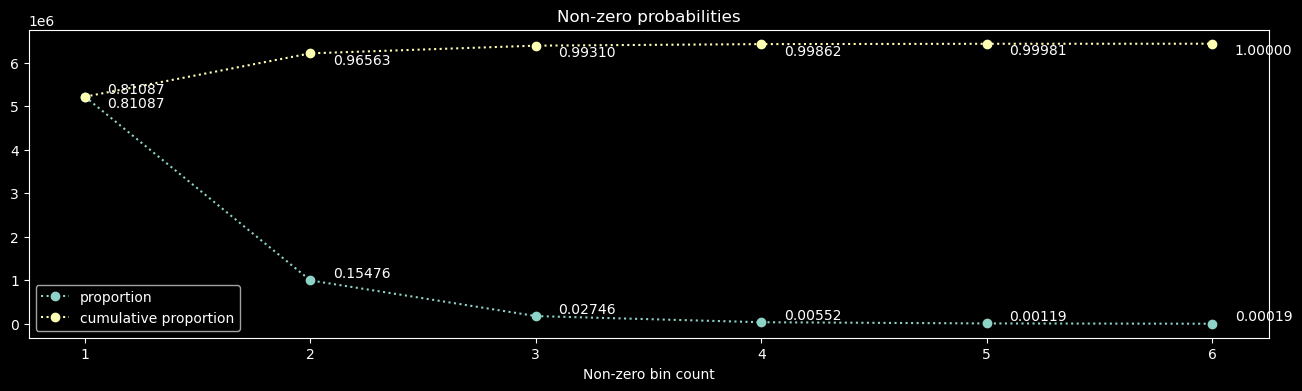

In [122]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, n_features=2**20, token_pattern='(?u)\\b\\w+\\b', dtype='uint8')
tdm = vec.fit_transform(text_vector)
display(tdm)
print('Sparsity                                    : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1]) * 100))
print('Max count of a hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document       : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document      : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document           : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                  :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence             :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, int(tdm.max()) + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

The maximum frequency of any hashed 1-gram token in a single observation is also 6 so the 8-bits unsigned integer `uint8` (0 to 255) also could be enough to store counts of any ngram range as long as there are sufficient `n_features`.

## Tokenizing hashed n-gram ranges

Iterating over `n_features` from the default $2^{20}$ to the maximum $2^{30}$ ([Murmurhash3 32-bit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)) and n-gram range from 1 to 7 in order to understand hashing collisions and memory usage.

In [123]:
# def func(ngram_range, i, text_vector):
#     tracemalloc.start()
#     tracemalloc.reset_peak()
#     t=time()
#     tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
#                                 ngram_range=ngram_range, n_features=2**i-(i//31), dtype='uint8').fit_transform(text_vector)
#     t=time()-t
#     current, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     _, hash_counts = np.unique(tdm.data, return_counts=True)
#     tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)

#     msg = 'features:2^{}-{}={} ngram:{},{} cols:{} maxtf:{:.0f} maxtfall:{:.0f} hashcount:{} nnz:{} sparse:{:.4f}% size:{} cur:{} peak:{} {:.0f}s'
#     msg = msg.format(i, (i//31), 2**i-(i//31), ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(),
#                      tdm.sum(axis=0).max(), len(hash_counts), tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100,
#                      size(tdm_nbytes), size(current), size(peak), t)
#     return msg

# messages = Parallel(n_jobs=-1)(delayed(func)(ngram_range, i, text_vector)
#                                for ngram_range in [(1,x) for x in range(1, 8)]
#                                for i in range(18, 32) # from 18 (recommended large enough) to 2^31-1 (Mumuhash3 32-bit)
#                               )
# for message in messages:
#     print(message)

```
Last executed at 2022-09-16 17:49:50 in 6m 46.99s

features:2^18-0=262144 ngram:1,1 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441089 sparse:99.9939% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 16s
features:2^19-0=524288 ngram:1,1 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441094 sparse:99.9969% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^20-0=1048576 ngram:1,1 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9985% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 16s
features:2^21-0=2097152 ngram:1,1 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9992% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^22-0=4194304 ngram:1,1 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9996% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 16s
features:2^23-0=8388608 ngram:1,1 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9998% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 16s
features:2^24-0=16777216 ngram:1,1 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9999% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^25-0=33554432 ngram:1,1 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^26-0=67108864 ngram:1,1 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^27-0=134217728 ngram:1,1 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^28-0=268435456 ngram:1,1 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^29-0=536870912 ngram:1,1 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^30-0=1073741824 ngram:1,1 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^31-1=2147483647 ngram:1,1 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^18-0=262144 ngram:1,2 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478586 sparse:99.9872% size:65.8 MiB cur:17.6 MiB peak:24.0 MiB 35s
features:2^19-0=524288 ngram:1,2 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478607 sparse:99.9936% size:65.8 MiB cur:17.6 MiB peak:24.0 MiB 35s
features:2^20-0=1048576 ngram:1,2 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9968% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^21-0=2097152 ngram:1,2 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9984% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^22-0=4194304 ngram:1,2 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9992% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^23-0=8388608 ngram:1,2 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9996% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^24-0=16777216 ngram:1,2 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9998% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^25-0=33554432 ngram:1,2 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9999% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^26-0=67108864 ngram:1,2 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9999% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^27-0=134217728 ngram:1,2 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^28-0=268435456 ngram:1,2 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^29-0=536870912 ngram:1,2 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 36s
features:2^30-0=1073741824 ngram:1,2 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^31-1=2147483647 ngram:1,2 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^18-0=262144 ngram:1,3 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:20371267 sparse:99.9806% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^19-0=524288 ngram:1,3 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372027 sparse:99.9903% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^20-0=1048576 ngram:1,3 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372345 sparse:99.9951% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^21-0=2097152 ngram:1,3 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372662 sparse:99.9976% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^22-0=4194304 ngram:1,3 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372668 sparse:99.9988% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^23-0=8388608 ngram:1,3 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372669 sparse:99.9994% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^24-0=16777216 ngram:1,3 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:99.9997% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^25-0=33554432 ngram:1,3 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:99.9998% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^26-0=67108864 ngram:1,3 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:99.9999% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^27-0=134217728 ngram:1,3 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^28-0=268435456 ngram:1,3 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^29-0=536870912 ngram:1,3 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^30-0=1073741824 ngram:1,3 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^31-1=2147483647 ngram:1,3 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^18-0=262144 ngram:1,4 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:26955689 sparse:99.9743% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^19-0=524288 ngram:1,4 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:26956768 sparse:99.9872% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 63s
features:2^20-0=1048576 ngram:1,4 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957325 sparse:99.9936% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 63s
features:2^21-0=2097152 ngram:1,4 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957645 sparse:99.9968% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^22-0=4194304 ngram:1,4 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957651 sparse:99.9984% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^23-0=8388608 ngram:1,4 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957652 sparse:99.9992% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 66s
features:2^24-0=16777216 ngram:1,4 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:99.9996% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^25-0=33554432 ngram:1,4 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:99.9998% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^26-0=67108864 ngram:1,4 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:99.9999% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 63s
features:2^27-0=134217728 ngram:1,4 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:99.9999% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^28-0=268435456 ngram:1,4 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.0000% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^29-0=536870912 ngram:1,4 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.0000% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^30-0=1073741824 ngram:1,4 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.0000% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^31-1=2147483647 ngram:1,4 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.0000% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 65s
features:2^18-0=262144 ngram:1,5 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:33192778 sparse:99.9684% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 78s
features:2^19-0=524288 ngram:1,5 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:33194134 sparse:99.9842% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 78s
features:2^20-0=1048576 ngram:1,5 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195262 sparse:99.9921% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 78s
features:2^21-0=2097152 ngram:1,5 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195621 sparse:99.9960% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^22-0=4194304 ngram:1,5 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195630 sparse:99.9980% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^23-0=8388608 ngram:1,5 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195677 sparse:99.9990% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 78s
features:2^24-0=16777216 ngram:1,5 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195720 sparse:99.9995% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^25-0=33554432 ngram:1,5 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195720 sparse:99.9998% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 79s
features:2^26-0=67108864 ngram:1,5 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195720 sparse:99.9999% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^27-0=134217728 ngram:1,5 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:99.9999% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 79s
features:2^28-0=268435456 ngram:1,5 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.0000% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^29-0=536870912 ngram:1,5 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.0000% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^30-0=1073741824 ngram:1,5 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.0000% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^31-1=2147483647 ngram:1,5 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.0000% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^18-0=262144 ngram:1,6 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:39076758 sparse:99.9628% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^19-0=524288 ngram:1,6 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:39078725 sparse:99.9814% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 92s
features:2^20-0=1048576 ngram:1,6 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080009 sparse:99.9907% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^21-0=2097152 ngram:1,6 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080451 sparse:99.9953% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^22-0=4194304 ngram:1,6 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080488 sparse:99.9977% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^23-0=8388608 ngram:1,6 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080542 sparse:99.9988% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^24-0=16777216 ngram:1,6 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080587 sparse:99.9994% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^25-0=33554432 ngram:1,6 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080587 sparse:99.9997% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^26-0=67108864 ngram:1,6 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080587 sparse:99.9999% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^27-0=134217728 ngram:1,6 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:99.9999% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^28-0=268435456 ngram:1,6 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.0000% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^29-0=536870912 ngram:1,6 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.0000% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^30-0=1073741824 ngram:1,6 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.0000% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 89s
features:2^31-1=2147483647 ngram:1,6 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.0000% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^18-0=262144 ngram:1,7 cols:262144 maxtf:6 maxtfall:331072 hashcount:6 nnz:44596942 sparse:99.9575% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 103s
features:2^19-0=524288 ngram:1,7 cols:524288 maxtf:6 maxtfall:331072 hashcount:6 nnz:44600006 sparse:99.9787% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 101s
features:2^20-0=1048576 ngram:1,7 cols:1048576 maxtf:6 maxtfall:331072 hashcount:6 nnz:44602296 sparse:99.9894% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 102s
features:2^21-0=2097152 ngram:1,7 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603017 sparse:99.9947% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 103s
features:2^22-0=4194304 ngram:1,7 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603226 sparse:99.9973% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 100s
features:2^23-0=8388608 ngram:1,7 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603283 sparse:99.9987% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 87s
features:2^24-0=16777216 ngram:1,7 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603328 sparse:99.9993% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 80s
features:2^25-0=33554432 ngram:1,7 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603328 sparse:99.9997% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 92s
features:2^26-0=67108864 ngram:1,7 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603331 sparse:99.9998% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 84s
features:2^27-0=134217728 ngram:1,7 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:99.9999% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 81s
features:2^28-0=268435456 ngram:1,7 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.0000% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 78s
features:2^29-0=536870912 ngram:1,7 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.0000% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 62s
features:2^30-0=1073741824 ngram:1,7 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.0000% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 65s
features:2^31-1=2147483647 ngram:1,7 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.0000% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 54s
```

As stated in [HashVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html):
> there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).

The previous experiment shows that:
* For any n-gram from 1 to 3, the max feature count in any cell as well as the hash count stabilizes from `n_features=2**12` on: `6`
* For any n-gram from 1 to 3, the max feature count in a column stabilizes from `n_features=2**18` on: `331001`.  If considering only `1-gram`, it stablizes from `2**11` on.
* The max hash value of 6 allows to downcast the hash `dtype` from the default `float64` to `uint8` (0 to 255).
* The NNZ for `HashingVectorizer(n_features=2**20, ngram_range=(1,1))` is the same of `CountVectorizer(ngram_range=(1,1))`
* The NNZ for `HashingVectorizer(n_features=2**20, ngram_range=(1,2))` is the same of `CountVectorizer(ngram_range=(1,2))`
* The NNZ for `HashingVectorizer(n_features=2**24, ngram_range=(1,3))` is the same of `CountVectorizer(ngram_range=(1,3))`
* The NNZ for `HashingVectorizer(n_features=2**24, ngram_range=(1,4))` is the same of `CountVectorizer(ngram_range=(1,4))`
* The NNZ for `HashingVectorizer(n_features=2**27, ngram_range=(1,5))` is the same of `CountVectorizer(ngram_range=(1,5))`
* The NNZ for `HashingVectorizer(n_features=2**27, ngram_range=(1,6))` is the same of `CountVectorizer(ngram_range=(1,6))`
* The NNZ for `HashingVectorizer(n_features=2**27, ngram_range=(1,7))` is the same of `CountVectorizer(ngram_range=(1,7))`

In order to preserve the same number of non-zero elements as the  1-gram's `CountVectorizer`, a final hashing could be the default `HashingVectorizer`(`n_features=2**20`). 

In [124]:
tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b', n_features=2**20,
                        dtype='uint8').fit_transform(text_vector)

display(tdm)

print('Sparsity                                            : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max count of a unigram hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x1048576 sparse matrix of type '<class 'numpy.uint8'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                            : 0.9999846538600243
Max count of a unigram hashed token in a document   : 6
Max count of a unigram hashed token in all documents: 331001
Max unique hashed tokens per document               : 53
Mean unique hashed tokens per document              : 19.8
Median unique tokens per document                   : 19.0
Sparse matrix memory usage                          : 32.2 MiB
Dense matrix memory equivalence                     : 390.9 GiB


## Dimension reduction

### About linear models

To train a linear model, the predictors $p$ should not be greater than the observations $n$.

Number of features resulting from 2nd degree interactions: $$i = \frac{x (x + 1)}{2} \implies x^2 + x - 2i = 0$$

Applying Baskara formula $$x=\frac{-b\pm\sqrt{b^2-4ac}}{2a} \implies x=\frac{-1\pm\sqrt{1+8i}}{2} \implies x=\frac{\pm\sqrt{8i+1}-1}{2}$$

$$max\ features\ for\ 2^{nd} degree\ interactions =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

Considering the existing 6 (six) numeric features, the $k$ parameter of `SelectKBest` should be decreased in 6 units:

In [125]:
from max_interactions import max_interactions

In [126]:
max_k = max_interactions(df.shape[0], minus=6)
max_k

888

### `chi2` stress test

In [127]:
from sklearn.feature_selection import chi2, SelectKBest

`chi2(X, y)`: Compute chi-squared stats between each non-negative feature and class.  
During its execution it allocates 2 arrays of `n_classes` times `n_features` times `float64` size of 8 bytes.

Simulating `chi2` peak memory usage for Murmuhash feature space:

In [128]:
[f'2^{i} => 2 X {2**i-(i//31):,} features X {dummy_labels.shape[1]} labels X {np.float64().itemsize} => '
 f'{size(2 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize)}' for i in range(18,32)]

['2^18 => 2 X 262,144 features X 104 labels X 8 => 416.0 MiB',
 '2^19 => 2 X 524,288 features X 104 labels X 8 => 832.0 MiB',
 '2^20 => 2 X 1,048,576 features X 104 labels X 8 => 1.6 GiB',
 '2^21 => 2 X 2,097,152 features X 104 labels X 8 => 3.2 GiB',
 '2^22 => 2 X 4,194,304 features X 104 labels X 8 => 6.5 GiB',
 '2^23 => 2 X 8,388,608 features X 104 labels X 8 => 13.0 GiB',
 '2^24 => 2 X 16,777,216 features X 104 labels X 8 => 26.0 GiB',
 '2^25 => 2 X 33,554,432 features X 104 labels X 8 => 52.0 GiB',
 '2^26 => 2 X 67,108,864 features X 104 labels X 8 => 104.0 GiB',
 '2^27 => 2 X 134,217,728 features X 104 labels X 8 => 208.0 GiB',
 '2^28 => 2 X 268,435,456 features X 104 labels X 8 => 416.0 GiB',
 '2^29 => 2 X 536,870,912 features X 104 labels X 8 => 832.0 GiB',
 '2^30 => 2 X 1,073,741,824 features X 104 labels X 8 => 1.6 TiB',
 '2^31 => 2 X 2,147,483,647 features X 104 labels X 8 => 3.2 TiB']

We must limit `n_features` to $2^{25}$ to fit `chi2` runtime in current physical 64GB RAM, avoiding memory swapping.

However, from `ngram_range` (1,5) on, only `n_features` $2^{27}$ will avoid hashing collisions.

In [129]:
# i=25
# tracemalloc.start()
# tracemalloc.reset_peak()
# tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
#                         ngram_range=(1,1), n_features=2**i-(i//31), dtype='uint8').fit_transform(text_vector)
# current, peak = tracemalloc.get_traced_memory()
# print(f'current memory {size(current)} peak {size(peak)}')

Last executed at 2022-09-21 15:42:07 in 9.58s

current memory 9.5 MiB peak 12.0 MiB

`chi2()` stress

In [130]:
# tracemalloc.reset_peak()
# # chi2_stats, chi2_p_values = chi2(tdm, dummy_labels)
# chi2(tdm, dummy_labels)
# current, peak = tracemalloc.get_traced_memory()
# print(f'current memory {size(current)} peak {size(peak)}')

Last executed at 2022-09-21 15:45:02 in 2m 55.29s

current memory 9.6 MiB peak 52.9 GiB

`SelectKBest(chi2)` stress

In [131]:
# k='all'
# tracemalloc.reset_peak()
# red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
# current, peak = tracemalloc.get_traced_memory()
# print(f'current memory {size(current)} peak {size(peak)}')
# tracemalloc.stop()

Last executed at 2022-09-21 15:47:59 in 2m 56.65s

current memory 41.8 MiB peak 52.9 GiB

**The next simulation:**

* Performs `HashingVectorizer` on different `n_features` up to $2^{31}-1$ and `ngram_range` from (1,1) to (1,7).
* Each iteration above will result a crescent number of features.
* For each interation, run parallelized `SelectKBest(chi2)` using a 16-point logspace $k$ of respective vocabulary size.

Max `num_jobs` as function of `n_features`

In [132]:
# [{f'2**{i}' :max(0, min(16, int(psutil.virtual_memory().available * 0.88 / 
#                                 (2 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize)) )) }
#  for i in range(18, 32)]
max_jobs = [min(15, int(psutil.virtual_memory().available / (2.5 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize))) + 1
            for i in range(18, 26)]
max_jobs

[16, 16, 16, 14, 7, 4, 2, 1]

In [133]:
# print(f'Available virtual memory: {size(psutil.virtual_memory().available)}')
# for i in range(20, 26): # stress up to the limit of n_features: 2^25 => 2 X 33,554,432 features X 104 labels X 8 => 52.0 GiB
#     for n in range(1, 8): # ngram_range (1,7) has 140X bigger vocabulary than ngram_range (1,1)
        
#         t1=time()
#         tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
#                                 ngram_range=(1, n), n_features=2**i-(i//31), dtype='uint8').fit_transform(text_vector)
#         print(f'HashingVectorizer(ngram_range=(1,{n}), n_features=2**{i}): {time()-t1:.2f}s')
#         _, hash_counts = np.unique(tdm.data, return_counts=True)
#         tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
       
#         def func(k, text_vector):
#             if k > 2**i-(i//31): # avoid selecting more k features than in n_features
#                 return f'k={k} exceeded n_feature=2**{i}-{(i//31)}={2**i-(i//31)}', 0
#             tracemalloc.start()
#             tracemalloc.reset_peak()
#             t2 = time()
#             red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
#             t2 = time() - t2
#             current, peak = tracemalloc.get_traced_memory()
#             tracemalloc.stop()
#             red_nbytes = (red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)
#             _, hash_counts2 = np.unique(red.data, return_counts=True)
#             msg = ' 2^{} ng:{},{} col:{} maxtf:{} hashes:{} nnz:{} sparse:{:.4f}% size:{} k:{} maxtf:{} hashes:{} nnz:{} sparse:{:.4f}% size:{} cur:{} peak:{} {:.0f}s'
#             msg = msg.format(i, 1, n, tdm.shape[1], tdm.max(), len(hash_counts), tdm.nnz,
#                              (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes), k, red.max(),
#                              len(hash_counts2), red.nnz, (1 - red.nnz / (red.shape[0] * red.shape[1])) * 100,
#                              size(red_nbytes), size(current), size(peak), t2)
#             return msg, peak

#         # k feature logspace from 2 to vocabulary size of the n_feature and ngram_range combination
#         # 16 points according to number of jobs
#         k_space = np.logspace(np.log10(2), np.log10(vocabulary_sizes[n-1]), 16).round().astype(int).tolist()
#         # max number of 16 cores for available memory
#         max_jobs = min(15, int(psutil.virtual_memory().available /
#                                (2.5 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize)) ) + 1
      
#         print(f'Start Parallel(n_jobs={max_jobs})')
#         tp=time()
#         messages = Parallel(n_jobs = max_jobs)(delayed(func)(k, text_vector) for k in k_space)
#         tp=time()-tp

#         max_peak = 0
#         for message, peak in messages:
#             max_peak = max(max_peak, peak)
#             # if (peak >= psutil.virtual_memory().available * threshold):
#             #     max_peak = peak
#             print(message)

#         print(f'Finish Parallel(n_jobs={max_jobs}) time {tp:.0f}s')
            
#         if max_peak * max_jobs > psutil.virtual_memory().available * threshold:
#             print(f'Threshold {size(psutil.virtual_memory().available * threshold)} reached: {size(max_peak)} * {max_jobs} = {size(max_peak*max_jobs)}', )
#             break
      
#     else:
#         continue
#     # break # catches inner break


```
Last executed at 2022-09-21 08:06:26 in 8h 12m 55s

Available virtual memory: 59.3 GiB
HashingVectorizer(ngram_range=(1,1), n_features=2**20): 2.46s
Start Parallel(n_jobs=16)
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.8 MiB peak:1.8 GiB 19s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.8 MiB peak:1.8 GiB 23s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:2.0 MiB peak:1.8 GiB 20s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.5 MiB peak:1.8 GiB 23s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.6 MiB peak:1.8 GiB 24s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.4 MiB peak:1.8 GiB 25s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.6 MiB peak:1.8 GiB 26s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:11.0 MiB peak:1.8 GiB 27s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.2 MiB peak:1.8 GiB 28s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:22.1 MiB peak:1.8 GiB 26s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.2 MiB peak:1.8 GiB 25s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.1 MiB peak:1.8 GiB 26s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6257998 sparse:98.1209% size:31.4 MiB cur:31.5 MiB peak:1.8 GiB 27s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382777 sparse:98.8403% size:32.0 MiB cur:32.1 MiB peak:1.8 GiB 27s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432421 sparse:99.2933% size:32.2 MiB cur:32.3 MiB peak:1.8 GiB 25s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.4 MiB peak:1.8 GiB 25s
Finish Parallel(n_jobs=16) time 31s
HashingVectorizer(ngram_range=(1,2), n_features=2**20): 4.35s
Start Parallel(n_jobs=16)
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:1.8 GiB 20s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54832 sparse:96.5754% size:1.8 MiB cur:1.8 MiB peak:1.8 GiB 22s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133306 sparse:95.2424% size:2.2 MiB cur:2.2 MiB peak:1.8 GiB 23s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256446 sparse:95.4238% size:2.7 MiB cur:2.8 MiB peak:1.8 GiB 22s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591086 sparse:94.3204% size:4.3 MiB cur:4.4 MiB peak:1.8 GiB 22s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338539 sparse:93.3119% size:7.9 MiB cur:7.9 MiB peak:1.8 GiB 27s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181838 sparse:94.3221% size:11.9 MiB cur:11.9 MiB peak:1.8 GiB 28s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704962 sparse:94.9421% size:19.2 MiB cur:19.2 MiB peak:1.8 GiB 24s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162995 sparse:95.5883% size:30.9 MiB cur:30.9 MiB peak:1.8 GiB 30s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8799646 sparse:96.6991% size:43.5 MiB cur:43.5 MiB peak:1.8 GiB 30s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10542456 sparse:97.9261% size:51.8 MiB cur:51.8 MiB peak:1.8 GiB 27s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11995240 sparse:98.7627% size:58.7 MiB cur:58.7 MiB peak:1.8 GiB 29s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12749129 sparse:99.3103% size:62.3 MiB cur:62.3 MiB peak:1.8 GiB 27s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13221689 sparse:99.6249% size:64.6 MiB cur:64.6 MiB peak:1.8 GiB 29s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13423449 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:1.8 GiB 27s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:1.8 GiB 27s
Finish Parallel(n_jobs=16) time 32s
HashingVectorizer(ngram_range=(1,3), n_features=2**20): 5.99s
Start Parallel(n_jobs=16)
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:1.9 GiB 25s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54832 sparse:96.5754% size:1.8 MiB cur:1.8 MiB peak:1.9 GiB 29s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190707 sparse:94.0445% size:2.4 MiB cur:2.4 MiB peak:1.9 GiB 26s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:297056 sparse:95.6346% size:2.9 MiB cur:3.0 MiB peak:1.9 GiB 25s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770168 sparse:94.3409% size:5.2 MiB cur:5.2 MiB peak:1.9 GiB 28s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671744 sparse:94.0336% size:9.5 MiB cur:9.5 MiB peak:1.9 GiB 29s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2909547 sparse:94.9169% size:15.4 MiB cur:15.4 MiB peak:1.9 GiB 29s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4684140 sparse:95.9786% size:23.9 MiB cur:23.9 MiB peak:1.9 GiB 28s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8248242 sparse:96.5251% size:40.9 MiB cur:40.9 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11983158 sparse:97.5238% size:58.7 MiB cur:58.7 MiB peak:1.9 GiB 32s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14918131 sparse:98.4868% size:72.7 MiB cur:72.7 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17418547 sparse:99.1326% size:84.6 MiB cur:84.6 MiB peak:1.9 GiB 32s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18814813 sparse:99.5401% size:91.2 MiB cur:91.3 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19801480 sparse:99.7624% size:95.9 MiB cur:96.0 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20238142 sparse:99.8808% size:98.0 MiB cur:98.0 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372345 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:1.9 GiB 30s
Finish Parallel(n_jobs=16) time 35s
HashingVectorizer(ngram_range=(1,4), n_features=2**20): 7.67s
Start Parallel(n_jobs=16)
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:2.0 GiB 27s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54857 sparse:96.5738% size:1.8 MiB cur:1.8 MiB peak:2.0 GiB 28s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192257 sparse:94.6632% size:2.4 MiB cur:2.5 MiB peak:2.0 GiB 29s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355484 sparse:95.3258% size:3.2 MiB cur:3.2 MiB peak:2.0 GiB 29s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059902 sparse:93.5417% size:6.6 MiB cur:6.6 MiB peak:2.0 GiB 27s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868898 sparse:94.6333% size:10.4 MiB cur:10.4 MiB peak:2.0 GiB 30s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3408540 sparse:95.3971% size:17.8 MiB cur:17.8 MiB peak:2.0 GiB 35s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5641493 sparse:96.4319% size:28.4 MiB cur:28.4 MiB peak:2.0 GiB 35s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9927090 sparse:97.0476% size:48.9 MiB cur:48.9 MiB peak:2.0 GiB 37s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14692915 sparse:97.9447% size:71.6 MiB cur:71.6 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18841357 sparse:98.7613% size:91.4 MiB cur:91.4 MiB peak:2.0 GiB 36s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22279813 sparse:99.3116% size:107.8 MiB cur:107.8 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24416326 sparse:99.6454% size:118.0 MiB cur:118.0 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25993300 sparse:99.8225% size:125.5 MiB cur:125.5 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26726791 sparse:99.9142% size:129.0 MiB cur:129.0 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957325 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:2.0 GiB 33s
Finish Parallel(n_jobs=16) time 38s
HashingVectorizer(ngram_range=(1,5), n_features=2**20): 9.37s
Start Parallel(n_jobs=16)
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:2.1 GiB 30s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54857 sparse:96.5738% size:1.8 MiB cur:1.8 MiB peak:2.1 GiB 32s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212224 sparse:94.6981% size:2.5 MiB cur:2.5 MiB peak:2.1 GiB 30s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395422 sparse:95.2959% size:3.4 MiB cur:3.4 MiB peak:2.1 GiB 36s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1177525 sparse:93.7409% size:7.1 MiB cur:7.2 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2081968 sparse:94.9007% size:11.5 MiB cur:11.5 MiB peak:2.1 GiB 34s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4061707 sparse:95.4901% size:20.9 MiB cur:20.9 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6509185 sparse:96.7015% size:32.6 MiB cur:32.6 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11313047 sparse:97.3903% size:55.5 MiB cur:55.5 MiB peak:2.1 GiB 37s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16854634 sparse:98.2308% size:81.9 MiB cur:81.9 MiB peak:2.1 GiB 37s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22231920 sparse:98.9374% size:107.5 MiB cur:107.5 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26633668 sparse:99.4205% size:128.5 MiB cur:128.5 MiB peak:2.1 GiB 37s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29562309 sparse:99.7071% size:142.5 MiB cur:142.5 MiB peak:2.1 GiB 37s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31781570 sparse:99.8567% size:153.1 MiB cur:153.1 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32857440 sparse:99.9325% size:158.2 MiB cur:158.2 MiB peak:2.1 GiB 36s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195262 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:2.1 GiB 34s
Finish Parallel(n_jobs=16) time 41s
HashingVectorizer(ngram_range=(1,6), n_features=2**20): 11.09s
Start Parallel(n_jobs=16)
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:2.1 GiB 32s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76721 sparse:96.1666% size:1.9 MiB cur:1.9 MiB peak:2.1 GiB 32s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212224 sparse:94.6981% size:2.5 MiB cur:2.5 MiB peak:2.1 GiB 36s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416887 sparse:95.4718% size:3.5 MiB cur:3.5 MiB peak:2.1 GiB 36s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1219619 sparse:94.0256% size:7.3 MiB cur:7.4 MiB peak:2.1 GiB 37s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2492413 sparse:94.6321% size:13.4 MiB cur:13.4 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4192717 sparse:95.9868% size:21.5 MiB cur:21.5 MiB peak:2.1 GiB 36s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7294206 sparse:96.9009% size:36.3 MiB cur:36.3 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12723082 sparse:97.6029% size:62.2 MiB cur:62.2 MiB peak:2.1 GiB 39s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:19067661 sparse:98.4047% size:92.4 MiB cur:92.5 MiB peak:2.1 GiB 39s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25223763 sparse:99.0631% size:121.8 MiB cur:121.8 MiB peak:2.1 GiB 39s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30481188 sparse:99.4974% size:146.9 MiB cur:146.9 MiB peak:2.1 GiB 40s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34322379 sparse:99.7487% size:165.2 MiB cur:165.2 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:37201654 sparse:99.8791% size:178.9 MiB cur:178.9 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38641298 sparse:99.9442% size:185.8 MiB cur:185.8 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080009 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:2.1 GiB 38s
Finish Parallel(n_jobs=16) time 44s
HashingVectorizer(ngram_range=(1,7), n_features=2**20): 12.64s
Start Parallel(n_jobs=16)
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19405 sparse:97.5761% size:1.6 MiB cur:1.6 MiB peak:2.2 GiB 39s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76728 sparse:96.1663% size:1.9 MiB cur:1.9 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:250640 sparse:94.3076% size:2.7 MiB cur:2.7 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437729 sparse:95.4435% size:3.6 MiB cur:3.6 MiB peak:2.2 GiB 37s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1449083 sparse:93.5354% size:8.4 MiB cur:8.4 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2674190 sparse:94.8210% size:14.3 MiB cur:14.3 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4285158 sparse:96.3833% size:22.0 MiB cur:22.0 MiB peak:2.2 GiB 43s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7866371 sparse:97.1100% size:39.0 MiB cur:39.0 MiB peak:2.2 GiB 40s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:14049916 sparse:97.7557% size:68.5 MiB cur:68.5 MiB peak:2.2 GiB 43s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20889866 sparse:98.5483% size:101.1 MiB cur:101.1 MiB peak:2.2 GiB 42s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27848641 sparse:99.1585% size:134.3 MiB cur:134.3 MiB peak:2.2 GiB 42s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:34035492 sparse:99.5527% size:163.8 MiB cur:163.8 MiB peak:2.2 GiB 42s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38690042 sparse:99.7789% size:186.0 MiB cur:186.0 MiB peak:2.2 GiB 43s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:42270664 sparse:99.8950% size:203.1 MiB cur:203.1 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:44073971 sparse:99.9524% size:211.7 MiB cur:211.7 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44602296 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:2.2 GiB 41s
Finish Parallel(n_jobs=16) time 47s
HashingVectorizer(ngram_range=(1,1), n_features=2**21): 2.53s
Start Parallel(n_jobs=15)
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.4 GiB 40s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.7 MiB peak:3.4 GiB 44s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:3.4 GiB 48s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.3 MiB peak:3.4 GiB 47s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.5 MiB peak:3.4 GiB 47s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.3 MiB peak:3.4 GiB 44s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.4 MiB peak:3.4 GiB 48s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:10.8 MiB peak:3.4 GiB 44s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:3.4 GiB 50s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:3.4 GiB 46s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:3.4 GiB 49s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.0 MiB peak:3.4 GiB 49s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:3.4 GiB 49s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:3.4 GiB 47s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432350 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:3.4 GiB 48s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.2 MiB peak:3.4 GiB 15s
Finish Parallel(n_jobs=15) time 56s
HashingVectorizer(ngram_range=(1,2), n_features=2**21): 4.60s
Start Parallel(n_jobs=15)
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.5 GiB 46s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:3.5 GiB 44s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:3.5 GiB 50s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:3.5 GiB 47s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.4 MiB peak:3.5 GiB 40s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:3.5 GiB 48s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181757 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:3.5 GiB 50s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704881 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:3.5 GiB 51s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162907 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:3.5 GiB 52s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8799522 sparse:96.6992% size:43.5 MiB cur:43.5 MiB peak:3.5 GiB 44s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10541588 sparse:97.9263% size:51.8 MiB cur:51.8 MiB peak:3.5 GiB 49s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11993197 sparse:98.7629% size:58.7 MiB cur:58.7 MiB peak:3.5 GiB 52s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12745653 sparse:99.3105% size:62.3 MiB cur:62.3 MiB peak:3.5 GiB 49s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13219292 sparse:99.6249% size:64.6 MiB cur:64.6 MiB peak:3.5 GiB 49s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13422263 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:3.5 GiB 51s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:3.5 GiB 16s
Finish Parallel(n_jobs=15) time 58s
HashingVectorizer(ngram_range=(1,3), n_features=2**21): 6.10s
Start Parallel(n_jobs=15)
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.6 GiB 38s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:3.6 GiB 46s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:3.6 GiB 48s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:3.0 MiB peak:3.6 GiB 48s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:3.6 GiB 47s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671661 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:3.6 GiB 44s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908964 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:3.6 GiB 51s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683538 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:3.6 GiB 48s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270704 sparse:96.5156% size:41.0 MiB cur:41.0 MiB peak:3.6 GiB 55s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11977717 sparse:97.5249% size:58.6 MiB cur:58.7 MiB peak:3.6 GiB 55s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14914169 sparse:98.4872% size:72.6 MiB cur:72.7 MiB peak:3.6 GiB 51s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17411803 sparse:99.1330% size:84.6 MiB cur:84.6 MiB peak:3.6 GiB 52s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18807060 sparse:99.5403% size:91.2 MiB cur:91.2 MiB peak:3.6 GiB 52s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19790397 sparse:99.7626% size:95.9 MiB cur:95.9 MiB peak:3.6 GiB 51s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20232014 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:3.6 GiB 52s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372662 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:3.6 GiB 20s
Finish Parallel(n_jobs=15) time 59s
HashingVectorizer(ngram_range=(1,4), n_features=2**21): 7.90s
Start Parallel(n_jobs=15)
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.6 GiB 50s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54782 sparse:96.5785% size:1.8 MiB cur:1.8 MiB peak:3.6 GiB 54s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192182 sparse:94.6653% size:2.4 MiB cur:2.5 MiB peak:3.6 GiB 47s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355409 sparse:95.3268% size:3.2 MiB cur:3.2 MiB peak:3.6 GiB 42s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059827 sparse:93.5421% size:6.6 MiB cur:6.6 MiB peak:3.6 GiB 55s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868807 sparse:94.6336% size:10.4 MiB cur:10.4 MiB peak:3.6 GiB 49s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3407946 sparse:95.3979% size:17.8 MiB cur:17.8 MiB peak:3.6 GiB 58s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5633645 sparse:96.4369% size:28.4 MiB cur:28.4 MiB peak:3.6 GiB 59s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9929153 sparse:97.0469% size:48.9 MiB cur:48.9 MiB peak:3.6 GiB 55s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14677000 sparse:97.9470% size:71.5 MiB cur:71.5 MiB peak:3.6 GiB 57s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18786726 sparse:98.7649% size:91.1 MiB cur:91.1 MiB peak:3.6 GiB 58s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22257216 sparse:99.3123% size:107.7 MiB cur:107.7 MiB peak:3.6 GiB 57s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24384559 sparse:99.6458% size:117.8 MiB cur:117.8 MiB peak:3.6 GiB 56s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25963475 sparse:99.8228% size:125.3 MiB cur:125.3 MiB peak:3.6 GiB 54s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26705308 sparse:99.9143% size:128.9 MiB cur:128.9 MiB peak:3.6 GiB 51s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957645 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:3.6 GiB 19s
Finish Parallel(n_jobs=15) time 63s
HashingVectorizer(ngram_range=(1,5), n_features=2**21): 9.68s
Start Parallel(n_jobs=15)
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.7 GiB 49s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54782 sparse:96.5785% size:1.8 MiB cur:1.8 MiB peak:3.7 GiB 37s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212149 sparse:94.6999% size:2.5 MiB cur:2.5 MiB peak:3.7 GiB 58s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395344 sparse:95.2968% size:3.4 MiB cur:3.4 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164517 sparse:93.8100% size:7.1 MiB cur:7.1 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077964 sparse:94.9105% size:11.4 MiB cur:11.4 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4038197 sparse:95.5162% size:20.8 MiB cur:20.8 MiB peak:3.7 GiB 54s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6508275 sparse:96.7019% size:32.6 MiB cur:32.6 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11339876 sparse:97.3841% size:55.6 MiB cur:55.6 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16832618 sparse:98.2331% size:81.8 MiB cur:81.8 MiB peak:3.7 GiB 61s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22206936 sparse:98.9386% size:107.4 MiB cur:107.4 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26569231 sparse:99.4219% size:128.2 MiB cur:128.2 MiB peak:3.7 GiB 61s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29486552 sparse:99.7079% size:142.1 MiB cur:142.1 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31720498 sparse:99.8569% size:152.8 MiB cur:152.8 MiB peak:3.7 GiB 56s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32813526 sparse:99.9326% size:158.0 MiB cur:158.0 MiB peak:3.7 GiB 56s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195621 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:3.7 GiB 28s
Finish Parallel(n_jobs=15) time 66s
HashingVectorizer(ngram_range=(1,6), n_features=2**21): 11.41s
Start Parallel(n_jobs=15)
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.8 GiB 58s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76646 sparse:96.1704% size:1.9 MiB cur:1.9 MiB peak:3.8 GiB 55s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212149 sparse:94.6999% size:2.5 MiB cur:2.5 MiB peak:3.8 GiB 62s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416809 sparse:95.4726% size:3.5 MiB cur:3.5 MiB peak:3.8 GiB 33s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206683 sparse:94.0890% size:7.3 MiB cur:7.3 MiB peak:3.8 GiB 59s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461209 sparse:94.6993% size:13.3 MiB cur:13.3 MiB peak:3.8 GiB 57s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4190067 sparse:95.9893% size:21.5 MiB cur:21.5 MiB peak:3.8 GiB 62s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7286557 sparse:96.9041% size:36.3 MiB cur:36.3 MiB peak:3.8 GiB 61s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12648852 sparse:97.6169% size:61.8 MiB cur:61.9 MiB peak:3.8 GiB 60s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:19007601 sparse:98.4097% size:92.2 MiB cur:92.2 MiB peak:3.8 GiB 63s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25147169 sparse:99.0659% size:121.4 MiB cur:121.4 MiB peak:3.8 GiB 60s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30391390 sparse:99.4988% size:146.4 MiB cur:146.5 MiB peak:3.8 GiB 61s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34196639 sparse:99.7497% size:164.6 MiB cur:164.6 MiB peak:3.8 GiB 62s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:37075154 sparse:99.8795% size:178.3 MiB cur:178.3 MiB peak:3.8 GiB 61s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38553060 sparse:99.9444% size:185.4 MiB cur:185.4 MiB peak:3.8 GiB 59s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080451 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:3.8 GiB 35s
Finish Parallel(n_jobs=15) time 71s
HashingVectorizer(ngram_range=(1,7), n_features=2**21): 12.94s
Start Parallel(n_jobs=15)
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.8 GiB 54s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76646 sparse:96.1704% size:1.9 MiB cur:1.9 MiB peak:3.8 GiB 64s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:250558 sparse:94.3094% size:2.7 MiB cur:2.7 MiB peak:3.8 GiB 61s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437644 sparse:95.4444% size:3.6 MiB cur:3.6 MiB peak:3.8 GiB 38s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299860 sparse:94.2011% size:7.7 MiB cur:7.7 MiB peak:3.8 GiB 66s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2666474 sparse:94.8360% size:14.2 MiB cur:14.3 MiB peak:3.8 GiB 66s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4283753 sparse:96.3845% size:22.0 MiB cur:22.0 MiB peak:3.8 GiB 63s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7687651 sparse:97.1756% size:38.2 MiB cur:38.2 MiB peak:3.8 GiB 64s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13927117 sparse:97.7753% size:67.9 MiB cur:67.9 MiB peak:3.8 GiB 64s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20775141 sparse:98.5563% size:100.6 MiB cur:100.6 MiB peak:3.8 GiB 67s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27748866 sparse:99.1615% size:133.8 MiB cur:133.9 MiB peak:3.8 GiB 66s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33871271 sparse:99.5549% size:163.0 MiB cur:163.0 MiB peak:3.8 GiB 67s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38513638 sparse:99.7799% size:185.2 MiB cur:185.2 MiB peak:3.8 GiB 65s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:42050921 sparse:99.8955% size:202.0 MiB cur:202.1 MiB peak:3.8 GiB 66s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43929751 sparse:99.9525% size:211.0 MiB cur:211.0 MiB peak:3.8 GiB 62s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603017 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:3.8 GiB 34s
Finish Parallel(n_jobs=15) time 75s
Threshold 57.3 GiB reached: 3.8 GiB * 15 = 57.6 GiB
HashingVectorizer(ngram_range=(1,1), n_features=2**22): 2.68s
Start Parallel(n_jobs=8)
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.8 MiB peak:6.7 GiB 52s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.8 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:2.0 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.5 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.6 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.4 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.6 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:11.0 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:6.7 GiB 49s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:6.7 GiB 52s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:6.7 GiB 52s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.0 MiB peak:6.7 GiB 52s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432346 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.3 MiB peak:6.7 GiB 52s
Finish Parallel(n_jobs=8) time 109s
HashingVectorizer(ngram_range=(1,2), n_features=2**22): 4.53s
Start Parallel(n_jobs=8)
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:6.8 GiB 54s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:6.8 GiB 56s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.4 MiB peak:6.8 GiB 56s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:6.8 GiB 56s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181757 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:6.8 GiB 56s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704880 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162903 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:6.8 GiB 49s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8801140 sparse:96.6986% size:43.5 MiB cur:43.5 MiB peak:6.8 GiB 51s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10539588 sparse:97.9267% size:51.8 MiB cur:51.8 MiB peak:6.8 GiB 53s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11990854 sparse:98.7632% size:58.7 MiB cur:58.7 MiB peak:6.8 GiB 54s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12743288 sparse:99.3106% size:62.3 MiB cur:62.3 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13218305 sparse:99.6250% size:64.6 MiB cur:64.6 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13421612 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:6.8 GiB 54s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:6.8 GiB 54s
Finish Parallel(n_jobs=8) time 112s
HashingVectorizer(ngram_range=(1,3), n_features=2**22): 6.13s
Start Parallel(n_jobs=8)
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:3.0 MiB peak:6.9 GiB 58s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:6.9 GiB 58s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671661 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:6.9 GiB 58s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908962 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683527 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270526 sparse:96.5157% size:41.0 MiB cur:41.0 MiB peak:6.9 GiB 52s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11974919 sparse:97.5255% size:58.6 MiB cur:58.6 MiB peak:6.9 GiB 54s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14909187 sparse:98.4877% size:72.6 MiB cur:72.6 MiB peak:6.9 GiB 56s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17399733 sparse:99.1336% size:84.5 MiB cur:84.5 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18799457 sparse:99.5405% size:91.2 MiB cur:91.2 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19782341 sparse:99.7627% size:95.9 MiB cur:95.9 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20228841 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372668 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:6.9 GiB 56s
Finish Parallel(n_jobs=8) time 116s
HashingVectorizer(ngram_range=(1,4), n_features=2**22): 7.72s
Start Parallel(n_jobs=8)
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:6.9 GiB 58s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54782 sparse:96.5785% size:1.8 MiB cur:1.8 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192182 sparse:94.6653% size:2.4 MiB cur:2.5 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355409 sparse:95.3268% size:3.2 MiB cur:3.2 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059824 sparse:93.5421% size:6.6 MiB cur:6.6 MiB peak:6.9 GiB 60s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868803 sparse:94.6336% size:10.4 MiB cur:10.4 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3407925 sparse:95.3979% size:17.8 MiB cur:17.8 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5631375 sparse:96.4383% size:28.4 MiB cur:28.4 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9928443 sparse:97.0472% size:48.9 MiB cur:48.9 MiB peak:6.9 GiB 51s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14680457 sparse:97.9465% size:71.5 MiB cur:71.5 MiB peak:6.9 GiB 57s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18777219 sparse:98.7655% size:91.1 MiB cur:91.1 MiB peak:6.9 GiB 58s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22241149 sparse:99.3127% size:107.6 MiB cur:107.6 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24363625 sparse:99.6461% size:117.7 MiB cur:117.7 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25947985 sparse:99.8229% size:125.3 MiB cur:125.3 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26693221 sparse:99.9143% size:128.8 MiB cur:128.8 MiB peak:6.9 GiB 58s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957651 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:6.9 GiB 58s
Finish Parallel(n_jobs=8) time 120s
HashingVectorizer(ngram_range=(1,5), n_features=2**22): 9.31s
Start Parallel(n_jobs=8)
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:7.0 GiB 59s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54782 sparse:96.5785% size:1.8 MiB cur:1.8 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212149 sparse:94.6999% size:2.5 MiB cur:2.5 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395344 sparse:95.2968% size:3.4 MiB cur:3.4 MiB peak:7.0 GiB 62s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164514 sparse:93.8101% size:7.1 MiB cur:7.1 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077960 sparse:94.9105% size:11.4 MiB cur:11.4 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4037899 sparse:95.5166% size:20.8 MiB cur:20.8 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6456094 sparse:96.7284% size:32.3 MiB cur:32.3 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11314901 sparse:97.3899% size:55.5 MiB cur:55.5 MiB peak:7.0 GiB 50s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16825911 sparse:98.2338% size:81.8 MiB cur:81.8 MiB peak:7.0 GiB 58s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22162289 sparse:98.9407% size:107.2 MiB cur:107.2 MiB peak:7.0 GiB 60s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26540092 sparse:99.4225% size:128.1 MiB cur:128.1 MiB peak:7.0 GiB 60s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29449004 sparse:99.7083% size:142.0 MiB cur:142.0 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31689226 sparse:99.8571% size:152.6 MiB cur:152.6 MiB peak:7.0 GiB 60s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32786628 sparse:99.9327% size:157.9 MiB cur:157.9 MiB peak:7.0 GiB 60s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195630 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:7.0 GiB 60s
Finish Parallel(n_jobs=8) time 124s
HashingVectorizer(ngram_range=(1,6), n_features=2**22): 11.02s
Start Parallel(n_jobs=8)
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76646 sparse:96.1704% size:1.9 MiB cur:1.9 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212149 sparse:94.6999% size:2.5 MiB cur:2.5 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416809 sparse:95.4726% size:3.5 MiB cur:3.5 MiB peak:7.1 GiB 63s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206679 sparse:94.0890% size:7.3 MiB cur:7.3 MiB peak:7.1 GiB 63s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461151 sparse:94.6995% size:13.3 MiB cur:13.3 MiB peak:7.1 GiB 63s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4189529 sparse:95.9898% size:21.5 MiB cur:21.5 MiB peak:7.1 GiB 63s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7268263 sparse:96.9119% size:36.2 MiB cur:36.2 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12494290 sparse:97.6460% size:61.1 MiB cur:61.1 MiB peak:7.1 GiB 57s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:18953353 sparse:98.4142% size:91.9 MiB cur:91.9 MiB peak:7.1 GiB 60s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25099140 sparse:99.0677% size:121.2 MiB cur:121.2 MiB peak:7.1 GiB 61s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30353549 sparse:99.4995% size:146.3 MiB cur:146.3 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34127681 sparse:99.7502% size:164.3 MiB cur:164.3 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:37011678 sparse:99.8797% size:178.0 MiB cur:178.0 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38508559 sparse:99.9444% size:185.2 MiB cur:185.2 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080488 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:7.1 GiB 62s
Finish Parallel(n_jobs=8) time 127s
HashingVectorizer(ngram_range=(1,7), n_features=2**22): 12.73s
Start Parallel(n_jobs=8)
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:7.1 GiB 63s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76646 sparse:96.1704% size:1.9 MiB cur:1.9 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:232116 sparse:94.7283% size:2.6 MiB cur:2.6 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437598 sparse:95.4448% size:3.6 MiB cur:3.6 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299803 sparse:94.2013% size:7.7 MiB cur:7.7 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2666305 sparse:94.8363% size:14.2 MiB cur:14.2 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4283781 sparse:96.3844% size:22.0 MiB cur:22.0 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7682046 sparse:97.1777% size:38.2 MiB cur:38.2 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13868469 sparse:97.7847% size:67.7 MiB cur:67.7 MiB peak:7.1 GiB 58s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20713021 sparse:98.5606% size:100.3 MiB cur:100.3 MiB peak:7.1 GiB 59s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27668394 sparse:99.1640% size:133.5 MiB cur:133.5 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33791454 sparse:99.5559% size:162.7 MiB cur:162.7 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38416998 sparse:99.7805% size:184.7 MiB cur:184.7 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:41942272 sparse:99.8958% size:201.5 MiB cur:201.5 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43849748 sparse:99.9526% size:210.6 MiB cur:210.6 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603226 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:7.1 GiB 63s
Finish Parallel(n_jobs=8) time 131s
HashingVectorizer(ngram_range=(1,1), n_features=2**23): 2.53s
Start Parallel(n_jobs=4)
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.8 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.8 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:2.0 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.5 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.5 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.3 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.4 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:10.8 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:13.3 GiB 65s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.0 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:13.3 GiB 64s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:13.3 GiB 65s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432346 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.2 MiB peak:13.3 GiB 66s
Finish Parallel(n_jobs=4) time 268s
HashingVectorizer(ngram_range=(1,2), n_features=2**23): 4.30s
Start Parallel(n_jobs=4)
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.4 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181756 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704879 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162902 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:13.4 GiB 65s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8801139 sparse:96.6986% size:43.5 MiB cur:43.5 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10539459 sparse:97.9267% size:51.8 MiB cur:51.8 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11989744 sparse:98.7633% size:58.7 MiB cur:58.7 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12742912 sparse:99.3106% size:62.3 MiB cur:62.3 MiB peak:13.4 GiB 64s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13217497 sparse:99.6250% size:64.6 MiB cur:64.6 MiB peak:13.4 GiB 66s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13421082 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:13.4 GiB 67s
Finish Parallel(n_jobs=4) time 271s
HashingVectorizer(ngram_range=(1,3), n_features=2**23): 5.98s
Start Parallel(n_jobs=4)
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:3.0 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:13.5 GiB 67s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671659 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908957 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683521 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270520 sparse:96.5157% size:41.0 MiB cur:41.0 MiB peak:13.5 GiB 66s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11966770 sparse:97.5272% size:58.6 MiB cur:58.6 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14908846 sparse:98.4878% size:72.6 MiB cur:72.6 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17397216 sparse:99.1337% size:84.5 MiB cur:84.5 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18797291 sparse:99.5405% size:91.2 MiB cur:91.2 MiB peak:13.5 GiB 60s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19779101 sparse:99.7627% size:95.8 MiB cur:95.8 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20227335 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372669 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:13.5 GiB 68s
Finish Parallel(n_jobs=4) time 275s
HashingVectorizer(ngram_range=(1,4), n_features=2**23): 7.46s
Start Parallel(n_jobs=4)
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192157 sparse:94.6660% size:2.4 MiB cur:2.5 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355384 sparse:95.3271% size:3.2 MiB cur:3.2 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059799 sparse:93.5423% size:6.6 MiB cur:6.6 MiB peak:13.5 GiB 68s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868776 sparse:94.6337% size:10.4 MiB cur:10.4 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3384872 sparse:95.4290% size:17.7 MiB cur:17.7 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5631293 sparse:96.4384% size:28.4 MiB cur:28.4 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9928238 sparse:97.0472% size:48.9 MiB cur:48.9 MiB peak:13.5 GiB 66s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14679408 sparse:97.9466% size:71.5 MiB cur:71.5 MiB peak:13.5 GiB 69s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18769050 sparse:98.7660% size:91.0 MiB cur:91.0 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22227245 sparse:99.3132% size:107.5 MiB cur:107.5 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24358786 sparse:99.6462% size:117.7 MiB cur:117.7 MiB peak:13.5 GiB 60s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25939673 sparse:99.8229% size:125.2 MiB cur:125.2 MiB peak:13.5 GiB 68s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26687665 sparse:99.9144% size:128.8 MiB cur:128.8 MiB peak:13.5 GiB 68s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957652 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:13.5 GiB 68s
Finish Parallel(n_jobs=4) time 279s
HashingVectorizer(ngram_range=(1,5), n_features=2**23): 9.09s
Start Parallel(n_jobs=4)
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395318 sparse:95.2971% size:3.4 MiB cur:3.4 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164486 sparse:93.8102% size:7.1 MiB cur:7.1 MiB peak:13.6 GiB 70s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077932 sparse:94.9106% size:11.4 MiB cur:11.4 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4037817 sparse:95.5166% size:20.8 MiB cur:20.8 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6455975 sparse:96.7284% size:32.3 MiB cur:32.3 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11314604 sparse:97.3899% size:55.5 MiB cur:55.5 MiB peak:13.6 GiB 67s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16817957 sparse:98.2346% size:81.7 MiB cur:81.7 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22131767 sparse:98.9422% size:107.1 MiB cur:107.1 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26526920 sparse:99.4228% size:128.0 MiB cur:128.0 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29435021 sparse:99.7084% size:141.9 MiB cur:141.9 MiB peak:13.6 GiB 59s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31669710 sparse:99.8572% size:152.5 MiB cur:152.5 MiB peak:13.6 GiB 69s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32774821 sparse:99.9327% size:157.8 MiB cur:157.8 MiB peak:13.6 GiB 69s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195677 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:13.6 GiB 69s
Finish Parallel(n_jobs=4) time 284s
HashingVectorizer(ngram_range=(1,6), n_features=2**23): 10.78s
Start Parallel(n_jobs=4)
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416783 sparse:95.4729% size:3.5 MiB cur:3.5 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206605 sparse:94.0894% size:7.3 MiB cur:7.3 MiB peak:13.7 GiB 70s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461072 sparse:94.6996% size:13.3 MiB cur:13.3 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4189155 sparse:95.9902% size:21.5 MiB cur:21.5 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7267124 sparse:96.9124% size:36.2 MiB cur:36.2 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12483327 sparse:97.6481% size:61.1 MiB cur:61.1 MiB peak:13.7 GiB 67s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:18886381 sparse:98.4199% size:91.6 MiB cur:91.6 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25082339 sparse:99.0684% size:121.1 MiB cur:121.1 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30326577 sparse:99.4999% size:146.1 MiB cur:146.1 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34096167 sparse:99.7504% size:164.1 MiB cur:164.1 MiB peak:13.7 GiB 54s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:36979675 sparse:99.8798% size:177.9 MiB cur:177.9 MiB peak:13.7 GiB 70s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38480465 sparse:99.9445% size:185.0 MiB cur:185.0 MiB peak:13.7 GiB 69s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080542 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:13.7 GiB 69s
Finish Parallel(n_jobs=4) time 287s
HashingVectorizer(ngram_range=(1,7), n_features=2**23): 12.45s
Start Parallel(n_jobs=4)
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:13.7 GiB 73s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:232091 sparse:94.7289% size:2.6 MiB cur:2.6 MiB peak:13.7 GiB 73s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437572 sparse:95.4451% size:3.6 MiB cur:3.6 MiB peak:13.7 GiB 73s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299729 sparse:94.2017% size:7.7 MiB cur:7.7 MiB peak:13.7 GiB 70s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2671964 sparse:94.8254% size:14.3 MiB cur:14.3 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4283026 sparse:96.3851% size:21.9 MiB cur:22.0 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7676874 sparse:97.1796% size:38.1 MiB cur:38.1 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13835119 sparse:97.7900% size:67.5 MiB cur:67.5 MiB peak:13.7 GiB 63s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20695912 sparse:98.5618% size:100.2 MiB cur:100.2 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27650878 sparse:99.1645% size:133.4 MiB cur:133.4 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33753975 sparse:99.5564% size:162.5 MiB cur:162.5 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38358603 sparse:99.7808% size:184.4 MiB cur:184.4 MiB peak:13.7 GiB 51s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:41889590 sparse:99.8959% size:201.3 MiB cur:201.3 MiB peak:13.7 GiB 67s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43811987 sparse:99.9527% size:210.4 MiB cur:210.4 MiB peak:13.7 GiB 67s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603283 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:13.7 GiB 66s
Finish Parallel(n_jobs=4) time 286s
HashingVectorizer(ngram_range=(1,1), n_features=2**24): 2.44s
Start Parallel(n_jobs=2)
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.8 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.8 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.3 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.5 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.3 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.4 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:10.8 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.0 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:26.5 GiB 104s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:26.5 GiB 104s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432346 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.2 MiB peak:26.5 GiB 103s
Finish Parallel(n_jobs=2) time 829s
HashingVectorizer(ngram_range=(1,2), n_features=2**24): 4.31s
Start Parallel(n_jobs=2)
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.4 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181756 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704879 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162902 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8801129 sparse:96.6986% size:43.5 MiB cur:43.5 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10538941 sparse:97.9268% size:51.8 MiB cur:51.8 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11989666 sparse:98.7633% size:58.7 MiB cur:58.7 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12742674 sparse:99.3106% size:62.3 MiB cur:62.3 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13216439 sparse:99.6250% size:64.5 MiB cur:64.6 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13420969 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:26.6 GiB 104s
Finish Parallel(n_jobs=2) time 834s
HashingVectorizer(ngram_range=(1,3), n_features=2**24): 5.87s
Start Parallel(n_jobs=2)
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:3.0 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671659 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908957 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683521 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270520 sparse:96.5157% size:41.0 MiB cur:41.0 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11965320 sparse:97.5275% size:58.6 MiB cur:58.6 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14907267 sparse:98.4879% size:72.6 MiB cur:72.6 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17396787 sparse:99.1337% size:84.5 MiB cur:84.5 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18796595 sparse:99.5406% size:91.2 MiB cur:91.2 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19777812 sparse:99.7627% size:95.8 MiB cur:95.8 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20226546 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372670 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:26.6 GiB 105s
Finish Parallel(n_jobs=2) time 840s
HashingVectorizer(ngram_range=(1,4), n_features=2**24): 7.53s
Start Parallel(n_jobs=2)
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192157 sparse:94.6660% size:2.4 MiB cur:2.5 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355384 sparse:95.3271% size:3.2 MiB cur:3.2 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059799 sparse:93.5423% size:6.6 MiB cur:6.6 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868776 sparse:94.6337% size:10.4 MiB cur:10.4 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3384872 sparse:95.4290% size:17.7 MiB cur:17.7 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5631293 sparse:96.4384% size:28.4 MiB cur:28.4 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9928118 sparse:97.0472% size:48.9 MiB cur:48.9 MiB peak:26.7 GiB 106s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14677843 sparse:97.9469% size:71.5 MiB cur:71.5 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18760276 sparse:98.7666% size:91.0 MiB cur:91.0 MiB peak:26.7 GiB 106s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22224841 sparse:99.3133% size:107.5 MiB cur:107.5 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24351768 sparse:99.6463% size:117.6 MiB cur:117.7 MiB peak:26.7 GiB 106s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25935755 sparse:99.8229% size:125.2 MiB cur:125.2 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26685286 sparse:99.9144% size:128.8 MiB cur:128.8 MiB peak:26.7 GiB 106s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957695 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:26.7 GiB 105s
Finish Parallel(n_jobs=2) time 846s
HashingVectorizer(ngram_range=(1,5), n_features=2**24): 9.16s
Start Parallel(n_jobs=2)
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395318 sparse:95.2971% size:3.4 MiB cur:3.4 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164486 sparse:93.8102% size:7.1 MiB cur:7.1 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077932 sparse:94.9106% size:11.4 MiB cur:11.4 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4037817 sparse:95.5166% size:20.8 MiB cur:20.8 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6443674 sparse:96.7347% size:32.3 MiB cur:32.3 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11314279 sparse:97.3900% size:55.5 MiB cur:55.5 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16811097 sparse:98.2354% size:81.7 MiB cur:81.7 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22118278 sparse:98.9428% size:107.0 MiB cur:107.0 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26518260 sparse:99.4230% size:128.0 MiB cur:128.0 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29428454 sparse:99.7085% size:141.9 MiB cur:141.9 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31661415 sparse:99.8572% size:152.5 MiB cur:152.5 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32767958 sparse:99.9327% size:157.8 MiB cur:157.8 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195720 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:26.8 GiB 106s
Finish Parallel(n_jobs=2) time 852s
HashingVectorizer(ngram_range=(1,6), n_features=2**24): 10.85s
Start Parallel(n_jobs=2)
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.9 GiB 106s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:26.9 GiB 106s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416783 sparse:95.4729% size:3.5 MiB cur:3.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206605 sparse:94.0894% size:7.3 MiB cur:7.3 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461071 sparse:94.6996% size:13.3 MiB cur:13.3 MiB peak:26.9 GiB 106s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4190269 sparse:95.9891% size:21.5 MiB cur:21.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7266428 sparse:96.9127% size:36.2 MiB cur:36.2 MiB peak:26.9 GiB 106s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12482906 sparse:97.6481% size:61.1 MiB cur:61.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:18867798 sparse:98.4214% size:91.5 MiB cur:91.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25074377 sparse:99.0687% size:121.1 MiB cur:121.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30319039 sparse:99.5000% size:146.1 MiB cur:146.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34080748 sparse:99.7505% size:164.0 MiB cur:164.0 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:36968680 sparse:99.8799% size:177.8 MiB cur:177.8 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38468550 sparse:99.9445% size:185.0 MiB cur:185.0 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080587 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:26.9 GiB 107s
Finish Parallel(n_jobs=2) time 855s
HashingVectorizer(ngram_range=(1,7), n_features=2**24): 12.49s
Start Parallel(n_jobs=2)
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:232091 sparse:94.7289% size:2.6 MiB cur:2.6 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437572 sparse:95.4451% size:3.6 MiB cur:3.6 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299729 sparse:94.2017% size:7.7 MiB cur:7.7 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2670813 sparse:94.8276% size:14.3 MiB cur:14.3 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4285047 sparse:96.3834% size:22.0 MiB cur:22.0 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7675822 sparse:97.1800% size:38.1 MiB cur:38.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13834352 sparse:97.7902% size:67.5 MiB cur:67.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20685406 sparse:98.5625% size:100.2 MiB cur:100.2 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27620974 sparse:99.1654% size:133.2 MiB cur:133.2 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33728393 sparse:99.5568% size:162.4 MiB cur:162.4 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38328041 sparse:99.7810% size:184.3 MiB cur:184.3 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:41859150 sparse:99.8960% size:201.1 MiB cur:201.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43791528 sparse:99.9527% size:210.3 MiB cur:210.3 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603328 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:26.9 GiB 107s
Finish Parallel(n_jobs=2) time 859s
HashingVectorizer(ngram_range=(1,1), n_features=2**25): 2.46s
Start Parallel(n_jobs=1)
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.7 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.3 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.5 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.3 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.4 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:10.8 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:29.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432346 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.2 MiB peak:52.9 GiB 176s
Finish Parallel(n_jobs=1) time 2814s
HashingVectorizer(ngram_range=(1,2), n_features=2**25): 4.37s
Start Parallel(n_jobs=1)
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.3 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181756 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704879 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162902 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8801129 sparse:96.6986% size:43.5 MiB cur:43.5 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10538938 sparse:97.9268% size:51.8 MiB cur:51.8 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11989663 sparse:98.7633% size:58.7 MiB cur:58.7 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12742618 sparse:99.3106% size:62.3 MiB cur:62.3 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13216314 sparse:99.6250% size:64.5 MiB cur:64.5 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13420851 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:52.9 GiB 176s
Finish Parallel(n_jobs=1) time 2821s
HashingVectorizer(ngram_range=(1,3), n_features=2**25): 5.95s
Start Parallel(n_jobs=1)
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:2.9 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671659 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908957 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683521 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270520 sparse:96.5157% size:41.0 MiB cur:41.0 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11965309 sparse:97.5275% size:58.6 MiB cur:58.6 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14907252 sparse:98.4879% size:72.6 MiB cur:72.6 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17396992 sparse:99.1337% size:84.5 MiB cur:84.5 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18795813 sparse:99.5406% size:91.2 MiB cur:91.2 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19777246 sparse:99.7627% size:95.8 MiB cur:95.8 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20226033 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372670 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:53.0 GiB 177s
Finish Parallel(n_jobs=1) time 2829s
HashingVectorizer(ngram_range=(1,4), n_features=2**25): 7.58s
Start Parallel(n_jobs=1)
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192157 sparse:94.6660% size:2.4 MiB cur:2.4 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355384 sparse:95.3271% size:3.2 MiB cur:3.2 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059799 sparse:93.5423% size:6.6 MiB cur:6.6 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868776 sparse:94.6337% size:10.4 MiB cur:10.4 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3384870 sparse:95.4290% size:17.7 MiB cur:17.7 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5631275 sparse:96.4384% size:28.4 MiB cur:28.4 MiB peak:53.1 GiB 176s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9928100 sparse:97.0473% size:48.9 MiB cur:48.9 MiB peak:53.1 GiB 176s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14677751 sparse:97.9469% size:71.5 MiB cur:71.5 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18760105 sparse:98.7666% size:91.0 MiB cur:91.0 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22222290 sparse:99.3133% size:107.5 MiB cur:107.5 MiB peak:53.1 GiB 176s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24349509 sparse:99.6463% size:117.6 MiB cur:117.6 MiB peak:53.1 GiB 176s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25933469 sparse:99.8230% size:125.2 MiB cur:125.2 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26683831 sparse:99.9144% size:128.8 MiB cur:128.8 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957695 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:53.1 GiB 177s
Finish Parallel(n_jobs=1) time 2830s
HashingVectorizer(ngram_range=(1,5), n_features=2**25): 9.26s
Start Parallel(n_jobs=1)
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395318 sparse:95.2971% size:3.4 MiB cur:3.4 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164486 sparse:93.8102% size:7.1 MiB cur:7.1 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077932 sparse:94.9106% size:11.4 MiB cur:11.4 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4037800 sparse:95.5167% size:20.8 MiB cur:20.8 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6443641 sparse:96.7347% size:32.3 MiB cur:32.3 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11314180 sparse:97.3900% size:55.5 MiB cur:55.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16810924 sparse:98.2354% size:81.7 MiB cur:81.7 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22117879 sparse:98.9429% size:107.0 MiB cur:107.0 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26512001 sparse:99.4231% size:127.9 MiB cur:127.9 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29424212 sparse:99.7085% size:141.8 MiB cur:141.8 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31655831 sparse:99.8572% size:152.5 MiB cur:152.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32763746 sparse:99.9327% size:157.8 MiB cur:157.8 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195720 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:53.2 GiB 177s
Finish Parallel(n_jobs=1) time 2835s
HashingVectorizer(ngram_range=(1,6), n_features=2**25): 10.89s
Start Parallel(n_jobs=1)
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416783 sparse:95.4729% size:3.5 MiB cur:3.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206605 sparse:94.0894% size:7.3 MiB cur:7.3 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461071 sparse:94.6996% size:13.3 MiB cur:13.3 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4190236 sparse:95.9891% size:21.5 MiB cur:21.5 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7266395 sparse:96.9127% size:36.2 MiB cur:36.2 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12482797 sparse:97.6482% size:61.0 MiB cur:61.1 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:18867480 sparse:98.4214% size:91.5 MiB cur:91.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25070753 sparse:99.0688% size:121.1 MiB cur:121.1 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30314138 sparse:99.5001% size:146.1 MiB cur:146.1 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34069343 sparse:99.7506% size:164.0 MiB cur:164.0 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:36958828 sparse:99.8799% size:177.8 MiB cur:177.8 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38462547 sparse:99.9445% size:184.9 MiB cur:184.9 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080587 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:53.2 GiB 178s
Finish Parallel(n_jobs=1) time 2843s
HashingVectorizer(ngram_range=(1,7), n_features=2**25): 12.57s
Start Parallel(n_jobs=1)
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:232091 sparse:94.7289% size:2.6 MiB cur:2.6 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437572 sparse:95.4451% size:3.6 MiB cur:3.6 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299729 sparse:94.2017% size:7.7 MiB cur:7.7 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2670812 sparse:94.8276% size:14.3 MiB cur:14.3 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4285013 sparse:96.3834% size:22.0 MiB cur:22.0 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7675748 sparse:97.1800% size:38.1 MiB cur:38.1 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13834202 sparse:97.7902% size:67.5 MiB cur:67.5 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20673190 sparse:98.5634% size:100.1 MiB cur:100.1 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27615123 sparse:99.1656% size:133.2 MiB cur:133.2 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33721270 sparse:99.5569% size:162.3 MiB cur:162.3 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38315130 sparse:99.7810% size:184.2 MiB cur:184.2 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:41846671 sparse:99.8960% size:201.1 MiB cur:201.1 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43776367 sparse:99.9527% size:210.3 MiB cur:210.3 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603328 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:53.3 GiB 178s
Finish Parallel(n_jobs=1) time 2851s
```

`n_features` $2^{20}$ allows pipeline parallelization in 16 cores.  
`n_features` $2^{21}$ allows pipeline parallelization in 15 cores.  
`n_features` $2^{22}$ allows pipeline parallelization in 8 cores.  
`n_features` $2^{23}$ allows pipeline parallelization in 4 cores.  
`n_features` $2^{24}$ allows pipeline parallelization in 2 cores.  
`n_features` $2^{25}$ allows no pipeline parallelization.  

In [134]:
tracemalloc.reset_peak()
#             t2 = time()
#             red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
#             t2 = time() - t2
#             current, peak = tracemalloc.get_traced_memory()
#             tracemalloc.stop()

tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
                        n_features=2**20, dtype='uint8').fit_transform(text_vector)
tracemalloc.start()
tracemalloc.reset_peak()
red = SelectKBest(chi2, k='all').fit_transform(tdm, dummy_labels)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
display(red)
print('Sparsity                                            : {:.3f}%'.format((1 - red.nnz / (red.shape[0]*red.shape[1])) * 100))
print('Max count of a unigram hashed token in a document   : {}'.format(red.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(red.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(red.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(red.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(red.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(red.shape[0]*red.shape[1]*tdm.dtype.itemsize))
print('Current memory                                      :', size(current))
print('Peak memory                                         :', size(peak))

<400277x1048576 sparse matrix of type '<class 'numpy.uint8'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                            : 99.998%
Max count of a unigram hashed token in a document   : 6
Max count of a unigram hashed token in all documents: 331001
Max unique hashed tokens per document               : 53
Mean unique hashed tokens per document              : 19.8
Median unique tokens per document                   : 19.0
Sparse matrix memory usage                          : 32.2 MiB
Dense matrix memory equivalence                     : 390.9 GiB
Current memory                                      : 32.2 MiB
Peak memory                                         : 1.8 GiB


**Cross-validation and multiprocessing considerations:**

Considering these results and as intended to perform a multi-processed k-fold cross-validation over the complete pipeline, the number of processors times the memory `n_features` must be tunned to fit within the 58GiB or less, otherwise it would be necessary to tune `n_features` and `k`.

Althought `k` hasn't very affected memory usage in the current step (`SelectKBest`) it surely will in the step (`PolynomialFeatures`).

## Feature union

In [135]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
get_numeric_data = FunctionTransformer(disambiguate, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total', 'sparse':True})
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': LABELS, 'sep':' '})
union = FeatureUnion([
    ('numeric_features', Pipeline([
        ('numeric_selector', get_numeric_data),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True))
    ])),
    ('text_features', Pipeline([
        ('text_selector', get_text_data),
        ('vectorizer', HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b', dtype='uint8')),
        ('reduction', SelectKBest(score_func=chi2))
    ]))
])

In [136]:
# reproducibility reloads data to avoid things done during EDA
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
NUMERIC_FEATURES=['FTE', 'Total']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES
#
union.set_params(text_features__reduction__k = 2)
tdm = union.fit_transform(df[FEATURES], dummy_labels)
display(tdm)
display(pd.DataFrame(tdm[0:5].toarray()))

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x8 sparse matrix of type '<class 'numpy.float32'>'
	with 1867808 stored elements in Compressed Sparse Row format>

,0,1,2,3,4,5,6,7
0,1.0,0.000000,50471.808594,0.0,1.0,0.0,0.0,0.0
1,0.0,3477.860107,0.000000,1.0,0.0,1.0,0.0,0.0
2,1.0,0.000000,62237.128906,0.0,1.0,0.0,0.0,0.0
3,0.0,22.299999,0.000000,1.0,0.0,1.0,0.0,0.0
4,0.0,54.166000,0.000000,1.0,0.0,1.0,0.0,0.0


Sparsity                           : 0.41671392560651743
Sparse matrix memory usage         : 15.8 MiB
Dense matrix memory equivalence    : 12.2 MiB


`FeatureUnion` haven't increased memory usage significantly more than the previous step `SelectKBest`.

`n_features=2**20` is still the goal and `k` must be assessed in the next step *Adding interaction terms*.

## Adding interaction terms

In [137]:
from sklearn.preprocessing import PolynomialFeatures

* Interaction terms are statistical tools that lets your model express what happens if two features appear together in the same row.
* `degree` tells what polynomial degree of interactions to compute.
* Pipelines with interaction terms take a while to train because the number of features in the output array scales polynomially in the number of features of the input array, and exponentially in the degree. High degrees can cause overfitting.

Trying different number of features: $\beta_1x_1 + \beta_2x_2 + \beta_3(x_1x_2)$

When `interaction_only = True` only interaction features are produced: features that are products of at most degree distinct input features (so not x[1] ** 2, x[0] * x[2] ** 3, etc.):

$$interactions = \frac{features \times (features + 1)}{2}$$

**Dense interactions**

In [138]:
dense_matrix = np.array([[0,0],[0,1],[1,0],[1,1]], dtype='float32')
print(f'{dense_matrix.shape[0]}x{dense_matrix.shape[1]} matrix:\n', dense_matrix)
interacted_matrix = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(dense_matrix).astype('float32')
print(f'{interacted_matrix.shape[0]}x{interacted_matrix.shape[1]} interactions:\n', interacted_matrix)

4x2 matrix:
 [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
4x3 interactions:
 [[0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]


**Sparse interactions**

In [139]:
from scipy.sparse import csr_matrix
sparse_matrix=csr_matrix(dense_matrix)
print(repr(sparse_matrix))
print(sparse_matrix)

<4x2 sparse matrix of type '<class 'numpy.float32'>'
	with 4 stored elements in Compressed Sparse Row format>
  (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0


In [140]:
interactor = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interactor.fit(sparse_matrix)
interacted_sparse_matrix = interactor.transform(sparse_matrix)
print('Feature names:', interactor.get_feature_names_out())
print(repr(interacted_sparse_matrix))
print(interacted_sparse_matrix)

Feature names: ['x0' 'x1' 'x0 x1']
<4x3 sparse matrix of type '<class 'numpy.float32'>'
	with 5 stored elements in Compressed Sparse Row format>
  (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0
  (3, 2)	1.0


Estimating interactions on a feature space:

In [141]:
['{} features result {:.0f} interactions'.format(x, x*(x+1)/2) for x in [894]]

['894 features result 400065 interactions']

Plotting interactions as a function of the number of features.  The red lines show the maximum of number of features whose interactions are smaller than the dataset observations, by the formula:

$$max\ features =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

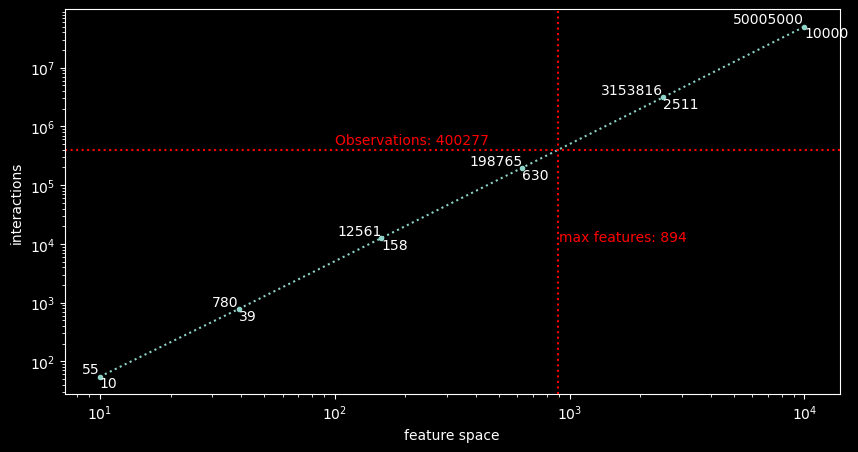

In [142]:
feature_space = np.logspace(np.log10(10), np.log10(10000), 6, dtype='int64')
interactions = (feature_space * (feature_space + 1) / 2).astype('int64')
max_features = int((np.sqrt(8 * df.shape[0] + 1) - 1) / 2)

plt.figure(figsize=(10,5))
plt.loglog(feature_space, interactions, marker='.', linestyle='dotted')
plt.axhline(df.shape[0] , linestyle='dotted', color='red')
plt.text(x=100, y=df.shape[0]*1.1, s='Observations: {}'.format(df.shape[0]), verticalalignment='bottom', color='red')

plt.axvline(max_features , linestyle='dotted', color='red')
plt.text(x=max_features*1.01, y=10**4, s='max features: {}'.format(max_features), verticalalignment='bottom', color='red')
for i,j in zip(feature_space, interactions):
    plt.text(i,j,j, horizontalalignment='right', verticalalignment='bottom')
    plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')
plt.xlabel('feature space')
plt.ylabel('interactions')
plt.show()

## Interaction stress

In [143]:
union.set_params(text_features__reduction__k = 'all')
tdm = union.fit_transform(df[FEATURES], dummy_labels)
print(f'Memory available before         : {size(psutil.virtual_memory().available)}')
tracemalloc.start()
tracemalloc.reset_peak()
tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(tdm)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
display(tdm)
print(f'Sparsity                       : {1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])}')
print(f'Sparse matrix memory usage     : {size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes))}')
print(f'Dense matrix memory equivalence: {size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize)}')
print(f'Current memory usage           : {size(current)}')
print(f'Peak memory usage              : {size(peak)}')
print(f'Memory available after         : {size(psutil.virtual_memory().available)}')

Memory available before         : 56.2 GiB


<400277x549762629653 sparse matrix of type '<class 'numpy.float32'>'
	with 97063179 stored elements in Compressed Sparse Row format>

Sparsity                       : 0.9999999995589187
Sparse matrix memory usage     : 1.1 GiB
Dense matrix memory equivalence: 781.8 PiB
Current memory usage           : 1.1 GiB
Peak memory usage              : 3.2 GiB
Memory available after         : 55.3 GiB


## Feature scaling

[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), also known as data normalization, is a method used to normalize the range of independent variables or features of data.

See [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

One can use different **scalers, transformers, and normalizers** to bring the data within a pre-defined range.

Scalers are **linear transformers** (more precisely [affine transformers](https://en.wikipedia.org/wiki/Affine_transformation)) and differ from each other in the way to estimate the parameters used to shift and scale **each feature**:
* `StandardScaler` - standardizes features by removing the mean and scaling to unit variance
```
(x - np.mean(x)) / np.std(x)
```
* `MinMaxScaler` - transforms features by scaling each feature to a given range, default (0, 1)
```
a = 0; b = 1; a + ( (x-min(x)) * (b-a) ) / (max(x) - min(x))
```
* `MaxAbsScaler` - scales each feature by its maximum absolute value to a range (-1, 1)
```
x / np.max(np.abs(x))
```
* `RobustScaler` - scales features using statistics that are robust to outliers

Transformers provides non-linear transformations:
* `QuantileTransformer` - transforms features using quantiles information, where distances between marginal outliers and inliers are shrunk.
* `PowerTransformer` - applies a power transform featurewise to make data more Gaussian-like, where data is mapped to a normal distribution to stabilize variance and minimize skewness.

Unlike the previous transformations, normalization refers to a **per sample** transformation instead of a **per feature** transformation:
* `Normalizer` - normalizes samples individually to unit norm
> Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community.

Initial considerations:
* `StandardScaler`, `MinMaxScaler` and `MaxAbsScaler` are very sensitive to the presence of outliers when computing mean and standard deviations therefore cannot guarantee balanced feature scales in the presence of outliers.
* `MinMaxScaler` doesn't support sparse input
* `MaxAbsScaler` values are mapped across 3 ranges depending on whether negative OR positive values are present. If only positive values are present, the range is [0, 1]. If only negative values are present, the range is [-1, 0]. If both negative and positive values are present, the range is [-1, 1]. 
* On positive only data, `MaxAbsScaler` behaves similarly to MinMaxScaler.
* The centering and scaling statistics of the `RobustScaler` are based on percentiles and not influenced by a few number of very large marginal outliers. The resulting range of the 
transformed feature values is larger than for the previous scalers and are approximately similar.
* `PowerTransformer(method='Yeo-Johnson')` can be applied to both negative and positive data. Requires dense input.
* `PowerTransformer(method='Box-Cox')` can only be applied to strictly positive data. Requires dense input.
* `QuantileTransformer(output_distribution='gaussian')`: Note that this non-parametetric transformer introduces saturation artifacts for outliers.
* `QuantileTransformer(output_distribution='uniform')` as `RobustScaler`, are robust to outliers but they will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

Final considerations:

For this problem, we need to scale a sparse matrix without destroying any sparsity, i.e., non-stored zero values should continue being like that.  The scalers/settings supporting that are:
* `StandardScaler(with_mean=False)`
* `MaxAbsScaler`
* `RobustScaler(with_centering=False)`
* `Normalizer(norm='l2')`
* `Normalizer(norm='l1')`

From these, the only scaler not sensible to outliers is the `RobustScaler`

In [144]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, Normalizer

Although sparse interactions allows virtually any number of resulting features, those features may be limited by the RAM requirements of the next step, scaling.

It's needed to find the $k$ best number of features that after interactions will fit into the scaler memory.

**`Normalizer l1/l2`**

They scale all features without memory impact

In [145]:
# max_k = 'all'
# print(f'Memory available: {size(psutil.virtual_memory().available)}, k: {max_k}')
# union.set_params(text_features__reduction__k = max_k)
# tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)\
#         .fit_transform(union.fit_transform(df[FEATURES], dummy_labels))
# display(tdm)

# tracemalloc.start()
# tracemalloc.reset_peak()
# t = time()
# tdm2 = Normalizer(norm='l1').fit_transform(tdm, dummy_labels)
# t = time() - t
# current, peak = tracemalloc.get_traced_memory()
# print(f'Normalizer(norm=\'l1\') min:{tdm2.min()} max:{tdm2.max()} current: {size(current)} peak: {size(peak)} {t:.2f}s')

# tracemalloc.reset_peak()
# t = time()
# tdm2 = Normalizer(norm='l2').fit_transform(tdm, dummy_labels)
# t = time() - t
# current, peak = tracemalloc.get_traced_memory()
# print(f'Normalizer(norm=\'l2\') min:{tdm2.min()} max:{tdm2.max()} current: {size(current)} peak: {size(peak)} {t:.2f}s')

# tracemalloc.stop()

```
Last executed at 2022-09-20 11:23:06 in 20.52s

Memory available: 54.2 GiB, k: all

<400277x549762629653 sparse matrix of type '<class 'numpy.float32'>'
	with 97063179 stored elements in Compressed Sparse Row format>

Normalizer(norm='l1') min:-0.26315557956695557 max:0.8096736073493958 current: 1.1 GiB peak: 1.1 GiB 0.48s
Normalizer(norm='l2') min:-0.8006407618522644 max:0.9952402114868164 current: 1.1 GiB peak: 2.2 GiB 0.49s
```

**`MaxAbsScaler`**

It affords up to $2^{16}=65536$ features

In [146]:
# tracemalloc.start()
# for k in np.logspace(1, 16, 16, base=2).round().astype(int):
#     print(f'k: {k:,}', end=' ')
#     union.set_params(text_features__reduction__k = k)
#     t = time()
#     tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)\
#             .fit_transform(union.fit_transform(df[FEATURES], dummy_labels))
#     print(f'interactions: {tdm.shape[1]:,} time: {time()-t:.2f}s', end= ' ')
   
#     tracemalloc.reset_peak()
#     t=time()
#     tdm2 = MaxAbsScaler().fit_transform(tdm, dummy_labels)
#     current, peak = tracemalloc.get_traced_memory()
#     print(f'MaxAbsScaler() current: {size(current)} peak: {size(peak)} time: {time()-t:.2f}s')
# tracemalloc.stop()

```
Last executed at 2022-09-20 11:35:58 in 12m 0.22s

k: 2 interactions: 36 time: 41.33s MaxAbsScaler() current: 304.3 MiB peak: 365.9 MiB time: 0.04s
k: 4 interactions: 55 time: 39.01s MaxAbsScaler() current: 349.9 MiB peak: 456.2 MiB time: 0.04s
k: 8 interactions: 105 time: 40.56s MaxAbsScaler() current: 401.6 MiB peak: 516.1 MiB time: 0.05s
k: 16 interactions: 253 time: 38.90s MaxAbsScaler() current: 348.5 MiB peak: 491.7 MiB time: 0.06s
k: 32 interactions: 741 time: 40.81s MaxAbsScaler() current: 453.6 MiB peak: 659.7 MiB time: 0.14s
k: 64 interactions: 2,485 time: 40.44s MaxAbsScaler() current: 618.2 MiB peak: 946.9 MiB time: 0.22s
k: 128 interactions: 9,045 time: 40.81s MaxAbsScaler() current: 995.6 MiB peak: 1.6 GiB time: 0.56s
k: 256 interactions: 34,453 time: 40.86s MaxAbsScaler() current: 1.4 GiB peak: 2.5 GiB time: 1.09s
k: 512 interactions: 134,421 time: 41.29s MaxAbsScaler() current: 1.7 GiB peak: 3.2 GiB time: 1.52s
k: 1,024 interactions: 530,965 time: 41.42s MaxAbsScaler() current: 1.9 GiB peak: 3.6 GiB time: 1.80s
k: 2,048 interactions: 2,110,485 time: 41.33s MaxAbsScaler() current: 2.0 GiB peak: 3.8 GiB time: 1.96s
k: 4,096 interactions: 8,415,253 time: 41.39s MaxAbsScaler() current: 2.0 GiB peak: 3.9 GiB time: 2.10s
k: 8,192 interactions: 33,607,701 time: 40.80s MaxAbsScaler() current: 2.0 GiB peak: 4.2 GiB time: 2.39s
k: 16,384 interactions: 134,324,245 time: 41.84s MaxAbsScaler() current: 2.1 GiB peak: 5.4 GiB time: 3.55s
k: 32,768 interactions: 537,083,925 time: 40.86s MaxAbsScaler() current: 2.1 GiB peak: 12.1 GiB time: 8.15s
k: 65,536 interactions: 2,147,909,653 time: 41.77s MaxAbsScaler() current: 2.9 GiB peak: 43.6 GiB time: 43.01s
```

**`StandardScaler`**

It affords up to $2^{15}=32768$ features

In [147]:
# tracemalloc.start()
# for k in np.logspace(1, 15, 15, base=2).round().astype(int):
#     print(f'k: {k:,}', end=' ')
#     union.set_params(text_features__reduction__k = k)
#     t = time()
#     tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)\
#             .fit_transform(union.fit_transform(df[FEATURES], dummy_labels))
#     print(f'interactions: {tdm.shape[1]:,} time: {time()-t:.2f}s', end= ' ')
   
#     tracemalloc.reset_peak()
#     t=time()
#     tdm2 = StandardScaler(with_mean=False).fit_transform(tdm, dummy_labels)
#     current, peak = tracemalloc.get_traced_memory()
#     print(f'StandardScaler(with_mean=False) current: {size(current)} peak: {size(peak)} time: {time()-t:.2f}s')
# tracemalloc.stop()

```
Last executed at 2022-09-20 11:53:23 in 10m 29.09s

k: 2 interactions: 36 time: 37.98s StandardScaler(with_mean=False) current: 143.9 MiB peak: 226.0 MiB time: 0.05s
k: 4 interactions: 55 time: 37.86s StandardScaler(with_mean=False) current: 146.8 MiB peak: 274.3 MiB time: 0.05s
k: 8 interactions: 105 time: 38.73s StandardScaler(with_mean=False) current: 198.5 MiB peak: 336.4 MiB time: 0.05s
k: 16 interactions: 253 time: 38.42s StandardScaler(with_mean=False) current: 273.7 MiB peak: 448.5 MiB time: 0.07s
k: 32 interactions: 741 time: 38.14s StandardScaler(with_mean=False) current: 378.7 MiB peak: 632.0 MiB time: 0.10s
k: 64 interactions: 2,485 time: 38.60s StandardScaler(with_mean=False) current: 543.4 MiB peak: 949.7 MiB time: 0.18s
k: 128 interactions: 9,045 time: 38.84s StandardScaler(with_mean=False) current: 920.7 MiB peak: 1.7 GiB time: 0.36s
k: 256 interactions: 34,453 time: 39.61s StandardScaler(with_mean=False) current: 1.4 GiB peak: 2.7 GiB time: 0.65s
k: 512 interactions: 134,421 time: 38.79s StandardScaler(with_mean=False) current: 1.7 GiB peak: 3.5 GiB time: 0.96s
k: 1,024 interactions: 530,965 time: 39.71s StandardScaler(with_mean=False) current: 1.8 GiB peak: 3.9 GiB time: 1.21s
k: 2,048 interactions: 2,110,485 time: 39.51s StandardScaler(with_mean=False) current: 1.9 GiB peak: 4.1 GiB time: 1.39s
k: 4,096 interactions: 8,415,253 time: 39.56s StandardScaler(with_mean=False) current: 1.9 GiB peak: 4.3 GiB time: 1.77s
k: 8,192 interactions: 33,607,701 time: 39.62s StandardScaler(with_mean=False) current: 2.0 GiB peak: 5.1 GiB time: 2.38s
k: 16,384 interactions: 134,324,245 time: 39.78s StandardScaler(with_mean=False) current: 2.0 GiB peak: 11.5 GiB time: 4.99s
k: 32,768 interactions: 537,083,925 time: 39.74s StandardScaler(with_mean=False) current: 1.5 GiB peak: 39.5 GiB time: 15.18s
```

**Max $k$ best features (i.e., before interactions) supported per scaler in 64GB RAM**

In [148]:
scalers = {
    'Normalizer(norm=\'l2\')' : [Normalizer(norm='l2'), 'all'],
    'Normalizer(norm=\'l1\')' : [Normalizer(norm='l1'), 'all'],
    'StandardScaler(with_mean=False)': [StandardScaler(with_mean=False), 2**15],
    'MaxAbsScaler()' : [MaxAbsScaler(), 2**16]
    }
scalers

{"Normalizer(norm='l2')": [Normalizer(), 'all'],
 "Normalizer(norm='l1')": [Normalizer(norm='l1'), 'all'],
 'StandardScaler(with_mean=False)': [StandardScaler(with_mean=False), 32768],
 'MaxAbsScaler()': [MaxAbsScaler(), 65536]}

## Pipeline: Logistic Regression

In [229]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, PolynomialFeatures
from preprocessing.combine_text_columns import combine_text_columns
from sklearn.metrics import classification_report
from metrics.log_loss import multi_multi_log_loss
from metrics.log_loss import log_loss_report_part, log_loss_report
from dummies import get_dummies_indices
from model_selection.multilabel import multilabel_train_test_split, multilabel_sample_dataframe

get_numeric_data = FunctionTransformer(disambiguate, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total', 'sparse':True})
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': LABELS, 'sep':' '})
pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', Pipeline([
            ('numeric_selector', get_numeric_data),
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True))
        ], verbose=True #, memory='/data/drivendata/cache'
        )),
        ('text_features' , Pipeline([
            ('text_selector', get_text_data),
            ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, dtype='uint8',
                                             token_pattern='(?u)\\b\\w+\\b')),
            ('reducer', SelectKBest(score_func=chi2))
        ], verbose=True #, memory='/data/drivendata/cache'
        ))
    ], verbose=True, n_jobs=None
    )),
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', MaxAbsScaler()),
    ('classifier', OneVsRestClassifier(LogisticRegression(random_state=1),
                                       n_jobs=-1))
], verbose=True #, memory='/data/drivendata/cache'
)

### 1% sample, 90/10 split

In [219]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.01, min_count=28, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'), size=0.1, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6) # k:78-> interactions: ((78+6) * ((78+6)+1))/2 = 3570
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]}, k: {max_k}, C:{C}')

Training: 3602, testing: 400, k: 78, C:1


In [220]:
pl.set_params(union__text_features__reducer__k = max_k)
# pl.set_params(classifier__estimator__max_iter = 100)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'3602-k78-logistic-regression-C1'

In [221]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

Fitting started on 2022-09-21T22:05
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.6s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   5.7s
[Pipeline] ............. (step 1 of 4) Processing union, total=   5.7s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.8s
Done: 0.1 minutes
Saving cache 3602-k78-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-21T22:05
Training accuracy         : 0.4250
Training log loss

```
Last executed at 2022-09-21 19:06:38 in 7.20s

Fitting started on 2022-09-21T19:06
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   5.7s
[Pipeline] ............. (step 1 of 4) Processing union, total=   5.7s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0937s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  62 out of 104 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    1.1s finished

[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.1s
Done: 0.1 minutes
Saving cache 3602-k78-logistic-regression-C1 ... Done: 0.0 minutes
.fit() current: 19.4 MiB peak: 1.7 GiB
Training report started on 2022-09-21T19:06
Training accuracy         : 0.4250
Training log loss         : 0.4820
Training report finished on 2022-09-21T19:06, elapsed 0.0 minutes

Testing report started on 2022-09-21T19:06
Testing accuracy         : 0.3550
Testing log loss         : 0.6382
Testing report finished on 2022-09-21T19:06, elapsed 0.0 minutes
```

In [222]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


### 10% sample, 90/10 split

In [223]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.1, min_count=28, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'), size=0.1, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6)  # k:261-> interactions: ((261+6) * ((261+6)+1))/2 = 35778
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

Training: 36025, testing: 4002 k: 261 C:1


In [224]:
pl.set_params(union__text_features__reducer__k = max_k)
# pl.set_params(classifier__estimator__max_iter = 300)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'36025-k261-logistic-regression-C1'

In [226]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

Fitting started on 2022-09-21T22:07
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.4s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.2s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.7s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   6.3s
[Pipeline] ............. (step 1 of 4) Processing union, total=   6.4s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed:   51.7s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:   58.9s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:  1.0min finished


[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.0min
Done: 1.2 minutes
Saving cache 36025-k261-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-21T22:08
Training accuracy         : 0.8799
Training log loss         : 0.0927
Training report finished on 2022-09-21T22:09, elapsed 0.1 minutes

Testing report started on 2022-09-21T22:09
Testing accuracy         : 0.8126
Testing log loss         : 0.1567
Testing report finished on 2022-09-21T22:09, elapsed 0.0 minutes



```
Last executed at 2022-09-21 19:25:14 in 1m 15.73s

Fitting started on 2022-09-21T19:23
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   1.8s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.2s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.6s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   8.5s
[Pipeline] ............. (step 1 of 4) Processing union, total=   8.6s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed:   51.9s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:   59.0s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:  1.0min finished

[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.0min
Done: 1.2 minutes
Saving cache 36025-k261-logistic-regression-C1 ... Done: 0.0 minutes
.fit() current: 45.1 MiB peak: 1.7 GiB
Training report started on 2022-09-21T19:25
Training accuracy         : 0.8799
Training log loss         : 0.0927
Training report finished on 2022-09-21T19:25, elapsed 0.1 minutes

Testing report started on 2022-09-21T19:25
Testing accuracy         : 0.8126
Testing log loss         : 0.1567
Testing report finished on 2022-09-21T19:25, elapsed 0.0 minutes
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

### 60/40 split

In [203]:
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.4, min_count=20, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6)   # k:686-> interactions: ((686+6) * ((686+6)+1))/2 = 239778
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

Training: 240167, testing: 160110 k: 686 C:1


In [201]:
pl.set_params(union__text_features__reducer__k = max_k)
# pl.set_params(classifier__estimator__max_iter = 600)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'240167-k686-logistic-regression-C1'

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

```
Last executed at 2022-09-21 20:00:39 in 20m 35.08s

Fitting started on 2022-09-21T19:40
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=  11.5s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   7.7s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   6.5s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  25.7s
[Pipeline] ............. (step 1 of 4) Processing union, total=  25.8s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.4s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.0s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed: 16.1min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed: 18.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed: 19.1min finished

[Pipeline] ........ (step 4 of 4) Processing classifier, total=19.1min
Done: 19.6 minutes
Saving cache 240167-k686-logistic-regression-C1 ... Done: 0.0 minutes
.fit() current: 216.6 MiB peak: 1.8 GiB
Training report started on 2022-09-21T19:59
Training accuracy         : 0.9437
Training log loss         : 0.0476
Training report finished on 2022-09-21T20:00, elapsed 0.6 minutes

Testing report started on 2022-09-21T20:00
Testing accuracy         : 0.9188
Testing log loss         : 0.0686
Testing report finished on 2022-09-21T20:00, elapsed 0.4 minutes
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Your score for this submission is: 0.4930

### 80/20 split

In [204]:
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=25, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6)    # k:793-> interactions: ((793+6) * ((793+6)+1))/2 = 319600
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

Training: 320222, testing: 80055 k: 793 C:1


In [206]:
pl.set_params(union__text_features__reducer__k = max_k)
# pl.set_params(classifier__estimator__max_iter = 600)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'320222-k793-logistic-regression-C1'

In [207]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

Fitting started on 2022-09-21T20:23
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=  15.1s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  10.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.0s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  32.2s
[Pipeline] ............. (step 1 of 4) Processing union, total=  32.3s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed: 26.4min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed: 28.7min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed: 30.7min finished


[Pipeline] ........ (step 4 of 4) Processing classifier, total=30.7min
Done: 31.3 minutes
Saving cache 320222-k793-logistic-regression-C1 ... Done: 0.0 minutes
.fit() current: 280.7 MiB peak: 2.0 GiB
Training report started on 2022-09-21T20:54
Training accuracy         : 0.9464
Training log loss         : 0.0460
Training report finished on 2022-09-21T20:55, elapsed 0.8 minutes

Testing report started on 2022-09-21T20:55
Testing accuracy         : 0.9237
Testing log loss         : 0.0645
Testing report finished on 2022-09-21T20:55, elapsed 0.2 minutes



```
Last executed at 2022-09-21 20:55:21 in 32m 19.95s

Fitting started on 2022-09-21T20:23
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=  15.1s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  10.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.0s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  32.2s
[Pipeline] ............. (step 1 of 4) Processing union, total=  32.3s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.4s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed: 26.4min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed: 28.7min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed: 30.7min finished

[Pipeline] ........ (step 4 of 4) Processing classifier, total=30.7min
Done: 31.3 minutes
Saving cache 320222-k793-logistic-regression-C1 ... Done: 0.0 minutes
.fit() current: 280.7 MiB peak: 2.0 GiB
Training report started on 2022-09-21T20:54
Training accuracy         : 0.9464
Training log loss         : 0.0460
Training report finished on 2022-09-21T20:55, elapsed 0.8 minutes

Testing report started on 2022-09-21T20:55
Testing accuracy         : 0.9237
Testing log loss         : 0.0645
Testing report finished on 2022-09-21T20:55, elapsed 0.2 minutes
```
Your score for this submission is: 0.5039


In [208]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


### 100%

In [214]:
train_sample_size = df.shape[0]
max_k = max_interactions(train_sample_size, minus=6)    # k:889-> interactions: ((888+6) * ((888+6)+1))/2 = 400065
C=1
print(f'Training: {train_sample_size} k: {max_k} C:{C}')

Training: 400277 k: 888 C:1


In [215]:
pl.set_params(union__text_features__reducer__k = max_k)
# pl.set_params(classifier__estimator__max_iter = 500)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'400277-k888-logistic-regression-C1'

In [216]:
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]), summary=True)

Fitting started on 2022-09-21T21:11
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   4.9s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.5s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  14.8s
[Pipeline] ............. (step 1 of 4) Processing union, total=  15.0s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.6s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed: 38.5min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed: 43.8min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed: 45.4min finished


[Pipeline] ........ (step 4 of 4) Processing classifier, total=45.4min
Done: 45.7 minutes
Saving cache 400277-k888-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-21T21:57
Training accuracy         : 0.9465
Training log loss         : 0.0455
Training report finished on 2022-09-21T21:58, elapsed 1.0 minutes



```
Last executed at 2022-09-21 21:58:24 in 46m 43.02s

Fitting started on 2022-09-21T21:11
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   4.9s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.5s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  14.8s
[Pipeline] ............. (step 1 of 4) Processing union, total=  15.0s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.6s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.8s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed: 38.5min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed: 43.8min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed: 45.4min finished

[Pipeline] ........ (step 4 of 4) Processing classifier, total=45.4min
Done: 45.7 minutes
Saving cache 400277-k888-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-21T21:57
Training accuracy         : 0.9465
Training log loss         : 0.0455
Training report finished on 2022-09-21T21:58, elapsed 1.0 minutes
```

Your score for this submission is: 0.5180

In [217]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


## Pipeline: Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl.steps[3] = ('classifier',
               OneVsRestClassifier(
                   RandomForestClassifier(n_estimators=100,  # default 100
                                          criterion="gini", # default "gini"
                                          max_depth=None,  # default None (leaves are pure or < min_samples_split)
                                          min_samples_split=2,  # default 2
                                          min_samples_leaf=1,  # default 1
                                          max_features='sqrt',  # default 'auto' (sqrt(n_features))
                                          bootstrap=True,  # default=True
                                          n_jobs=None,  # default None
                                          random_state=1, #default None
                                          ), n_jobs=-1))

# n_estimators=1, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 197s
# n_estimators=1, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 215s
# n_estimators=1, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 201s
# n_estimators=10, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 274s
# n_estimators=1, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 455s
# * n_estimators=10, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 1720s
# n_estimators=10, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 289s
# n_estimators=10, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 300s
# n_estimators=10, n_jobs=-1, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 362s
# n_estimators=10, n_jobs=-1, max_depth=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 22m
# n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): ~4h

### 80/20 split

In [ ]:
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=25, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6)
n_estimators = 10
max_depth = 10
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} n_estimators: {n_estimators} max_depth: {max_depth}')

In [ ]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__n_estimators = n_estimators)
pl.set_params(classifier__estimator__max_depth = max_depth)
modelname = f'{train_sample_size}-k{max_k}-random-forest-estimators{n_estimators}-depth{max_depth}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

```
Last executed at 2022-09-08 18:50:21 in 3m 33.77s

Fitting started on 2022-09-08T18:46
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   3.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.9s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.1s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  12.8s
[Pipeline] ............. (step 1 of 4) Processing union, total=  12.9s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.4s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.1min
Done: 1.4 minutes
Saving cache 320222-k794-random-forest-estimators10-depth10 ... Done: 0.0 minutes
Training report started on 2022-09-08T18:48
Training accuracy         : 0.2539
Training log loss         : 0.6642
Training report finished on 2022-09-08T18:49, elapsed 1.7 minutes

Testing report started on 2022-09-08T18:49
Testing accuracy         : 0.2487
Testing log loss         : 0.6724
Testing report finished on 2022-09-08T18:50, elapsed 0.4 minutes
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

### 100%

In [ ]:
train_sample_size = df.shape[0]
max_k = max_interactions(train_sample_size, minus=6)
n_estimators = 10
max_depth = 10
print(f'Training: {train_sample_size} k: {max_k} n_estimators: {n_estimators} max_depth: {max_depth}')

In [ ]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__n_estimators = n_estimators)
pl.set_params(classifier__estimator__max_depth = max_depth)
modelname = f'{train_sample_size}-k{max_k}-random-forest-estimators{n_estimators}-depth{max_depth}'
modelname

In [ ]:
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]), summary=True)

```
Last executed at 2022-09-08 18:55:49 in 4m 6.70s

Fitting started on 2022-09-08T18:51
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   4.6s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.4s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  14.4s
[Pipeline] ............. (step 1 of 4) Processing union, total=  14.5s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.5min
Done: 1.8 minutes
Saving cache 400277-k889-random-forest-estimators10-depth10 ... Done: 0.0 minutes
Training report started on 2022-09-08T18:53
Training accuracy         : 0.2354
Training log loss         : 0.6801
Training report finished on 2022-09-08T18:55, elapsed 2.3 minutes
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

# Learning from the Experts

* NLP tricks: Range of n-grams, punctuation tokenization (regular expression)
* Stats trick: Interaction terms
* Computation trick: Hashing vectorizer
* What class of model to use?
    * Deep Convolutional Neural Network?
    * Extreme Gradient Boosted Trees
    * An ensemble of local-expert elasticnet regressions?
* **No, the winning model was the Logistic Regression and not a cutting edge algorithm**
    * Carefully create features
    * Easily implemented tricks

> Rather than reaching advanced alghoritms hard to interpret and expensive to train it's always worth it to see how far you can get with simpler methods.

# Can you do better?

Ways to improve:

* NLP: Stemming, stop-word removal
* Model: RandomForest, k-NN, Naïve Bayes
* Numeric preprocessing: Imputation strategies
* Optimization: Grid search over pipeline objects
* Experiment new scikit-learn tech docs